# Data Augmentation - Conditional Wasserstein GANs - GP - Binary

### Dataset: Grapevine Dataset

This notebook presents the CWGAN-GP model to generate Feature Occurrence or Binary Data from the experimental grapevine dataset.

Notebook Organization:
- Read the dataset
- Setup the CWGAN-GP-Binary model and train the model with grapevine feature occurrence data
- Generate artificial samples in an artificial dataset and compare them to the experimental data
- Train 11 models each leaving three different samples of the experimental data leftover to use as a test set and see performance of supervised analysis
- Some of the optimizations made to the model

#### Due to stochasticity, re-running the notebook will get slightly different results. Thus, figures in the report can be slightly different than the ones shown here (since some parts of the notebooks were re-ran after submission).

Warnings in certain cells are suppressed with %%capture --no-stdout. Erase the line to see warnings.

#### Needed Imports

In [ ]:
from pathlib import Path

# json for persistence
import json
from time import perf_counter

import numpy as np
import pandas as pd

import scipy.spatial.distance as dist
import scipy.cluster.hierarchy as hier
import scipy.stats as stats

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
from matplotlib import ticker

import seaborn as sns
from collections import namedtuple, Counter

from tqdm import tqdm
from IPython import display as ipythondisplay

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
import sklearn.ensemble as skensemble

import tensorflow as tf
import os
from keras import backend

# Metabolinks package
#import metabolinks as mtl
#import metabolinks.transformations as transf

# Python files in the repository
import multianalysis as ma
from elips import plot_confidence_ellipse
import gan_evaluation_metrics as gem
import linear_augmentation_functions as laf

In [ ]:
%matplotlib inline

Reading the data to be analysed and augmented

In [3]:
path = Path.cwd() / "store_data" / 'processed_data_GD.json'
storepath = Path.cwd() / "store_data" / 'processed_data_GD.h5'
with pd.HDFStore(storepath) as store:

    with open(path, encoding='utf8') as read_file:
        datasets = json.load(read_file)
    
    for dskey, dataset in datasets.items():
        dataset['iter_fold_splits'] = {}
        for key in dataset:
            if 'iter_fold_splits' == key:
                continue
            value = dataset[key]
            if isinstance(value, str) and value.startswith("INSTORE"):
                storekey = value.split("_", 1)[1]
                # Load the data from 'iter_fold_splits' carefully restoring the nested dictionaries
                if len(storekey.split("AA_")) > 1: # This separation was made to identify the 'iter_fold_splits' data
                    dictkeys = (storekey.split("AA_")[1]).split('_',3)
                    if int(dictkeys[0]) not in dataset['iter_fold_splits'].keys():
                        dataset['iter_fold_splits'][int(dictkeys[0])] = {}
                    if dictkeys[1] not in dataset['iter_fold_splits'][int(dictkeys[0])].keys():
                        dataset['iter_fold_splits'][int(dictkeys[0])][dictkeys[1]] = {}
                    if int(dictkeys[2]) not in dataset['iter_fold_splits'][int(dictkeys[0])][dictkeys[1]].keys():
                        dataset['iter_fold_splits'][int(dictkeys[0])][dictkeys[1]][int(dictkeys[2])] = {}
                    dataset['iter_fold_splits'][int(dictkeys[0])][dictkeys[1]][int(dictkeys[2])][dictkeys[3]] = store[storekey]

                else:
                    dataset[key] = store[storekey]
                
            # convert colors to tuples, since they are read as lists from json file
            elif key == 'label_colors':
                dataset[key] = {lbl: tuple(c) for lbl, c in value.items()}
            elif key == 'sample_colors':
                dataset[key] = [tuple(c) for c in value]
            elif key.endswith('target') and key.startswith(dskey):
                dictkeys = ((key.split("_", 1)[1]).split("AA_")[1]).split('_',3)
                dataset['iter_fold_splits'][int(dictkeys[0])][dictkeys[1]][int(dictkeys[2])][dictkeys[3]] = value

Linear Augmentation / Interpolation (with Feature Occurrence Methods) the experimental data and corresponding sample labels/classes to use as training data for the GAN network

In [4]:
start = perf_counter()
data_bin, lbls_bin = laf.artificial_dataset_generator(datasets['vitis_types']['BinSim'], labels=datasets['vitis_types'][
    'target'], max_new_samples_per_label=768, binary='random sampling', rnd=list(np.linspace(0.1,0.9,9)), 
                                        binary_rnd_state=314, rnd_state=341)
end = perf_counter()
print(f'Simple augmentation of data done! took {(end - start):.3f} s')

Simple augmentation of data done! took 99.179 s


In [5]:
#data_bin = pd.read_csv('store_data/generated_data_BinSim.csv')
#data_bin = data_bin.set_index(data_bin.columns[0])
lbls = lbls_bin
data_bin

,97.2482,97.5887,97.588885,97.590015,97.5902,97.59094999999999,97.59188,97.72991999999999,98.153385,98.195875,...,966.00612,966.0547300000001,966.0576149999999,966.0663999999999,966.138205,966.140155,966.14212,966.1445,966.245005,977.114775
"Arti ('CS', 30)-('REG', 40)_rnd0.9",0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
"Arti ('CS', 29)-('PN', 25)_rnd0.3",0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
"Arti ('REG', 39)-('RL', 26)_rnd0.6",0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
"Arti ('CS', 31)-('REG', 39)_rnd0.8",0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
"Arti ('CS', 30)-('TRI', 32)_rnd0.9",0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Arti ('ROT', 22)-('SYL', 11)_rnd0.1",1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Arti ('RIP', 18)-('RU', 35)_rnd0.1",0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
"Arti ('LAB', 10)-('SYL', 12)_rnd0.5",0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Arti ('CAN', 16)-('ROT', 20)_rnd0.3",0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Obtaining Inputs for GAN model

In [6]:
# Get distribution of intensity values of the dataset
hist = np.histogram(datasets['vitis_types']['BinSim'].values.flatten(), bins=100)
input_realdata_dist = stats.rv_histogram(hist)

Set up colours for each of the classes. Generated samples will have the corresponding label with 'gen_' from generated before them.

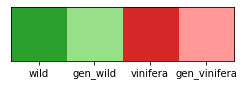

In [7]:
colours2 = sns.color_palette('tab20', 10)[4:8]

ordered_labels_test = ('wild','gen_wild','vinifera','gen_vinifera')
label_colors_test = {lbl: c for lbl, c in zip(ordered_labels_test, colours2)}

sns.palplot(label_colors_test.values())
new_ticks_test = plt.xticks(range(len(ordered_labels_test)), ordered_labels_test)

## Conditional Wasserstein GAN - GP model for binary / feature occurrence data

This model construction for the ususal CWGAN-GP was made by joining WGAN-GP models with Conditional GAN models. WGAN-GP models were originally made according to / originally based in https://keras.io/examples/generative/wgan_gp/#wasserstein-gan-wgan-with-gradient-penalty-gp and Conditional GAN models - https://machinelearningmastery.com/how-to-develop-a-conditional-generative-adversarial-network-from-scratch/ (generator and discriminator model) and https://keras.io/examples/generative/conditional_gan/ without using OOP (loss functions and training/training steps).

However, this time we have discrete data instead of continuous data. Thus, we have to perform alterations to our CWGAN-GP model. 

The strategy followed was suggested by Gulrajani et al. (https://arxiv.org/pdf/1704.00028.pdf). Since this data can have 2 values in each feature (0 or 1), the previous final dense layer generates two times the number of features in the data: 2 values for each feature, one representing 0 and the other 1. Then, they are passed to a softmax layer that for generates probabilities for each set of 2 values for each feature as the output of the generator. This output is directly given to the critic. When real data is passed to the critic, it is transformed to have this format (having 100% or 1 probability of having one of the values and 0% of having the other). The critic now receives this altered output, but the remaining architecture stays the same as before. After GAN training, samples are generated by the generator and, for each feature, the vector with 2 values is transformed to 1 or 0 depending on which had the highest probability.

In [8]:
# Import needed functions from GAN_functions
from GAN_functions import softmax
from GAN_functions import gradient_penalty_cwgan_bin
from GAN_functions import critic_loss_wgan
from GAN_functions import generator_loss_wgan

In [9]:
batch_size = 32

all_data = data_bin.iloc[np.random.RandomState(seed=145).permutation(len(data_bin))]#/(2*data_NGP.values.std())
#test.shuffle(buffer_size=len(test), seed=145)#.batch(batch_size)
true_labels = pd.get_dummies(np.array(lbls_bin)[np.random.RandomState(seed=145).permutation(len(data_bin))]).values[:,0]

test_labels = tf.constant(true_labels[-3*batch_size:])
test_data = tf.constant(all_data[-3*batch_size:])

In [10]:
def generator_model(len_input, len_output, n_labels, n_hidden_nodes): 
    "Make the generator model of CWGAN-GP-Binary."

    data_input = tf.keras.Input(shape=(len_input,), name='data') # Take feature occurrence input
    label_input = tf.keras.Input(shape=(1,), name='label') # Take Label Input

    # Treat label input to concatenate after
    label_m = tf.keras.layers.Embedding(n_labels, 30, input_length=1)(label_input)
    label_m = tf.keras.layers.Dense(256, activation='linear', use_bias=True)(label_m)
    #label_m = tf.keras.layers.Reshape((len_input,1,))(label_m)
    label_m2 = tf.keras.layers.Reshape((256,))(label_m)

    joined_data = tf.keras.layers.Concatenate()([data_input, label_m2]) # Concatenate the two inputs
    # Hidden Dense Layer and Normalization
    joined_data = tf.keras.layers.Dense(n_hidden_nodes, activation=tf.nn.leaky_relu, use_bias=True)(joined_data)
    joined_data = tf.keras.layers.Dense(256, activation=tf.nn.leaky_relu, use_bias=True)(joined_data)
    joined_data = tf.keras.layers.BatchNormalization()(joined_data)
    
    # Output - number of features of sample to make with 2 values for each feature - one with a probability of the value being 0
    # and the other with a probaiblity of the value being 1.
    output = tf.keras.layers.Dense(len_output*2, activation='linear', use_bias=True)(joined_data)
    output = softmax(output, len_output) # Gives probability between the values 0 and 1 for each feature
    
    generator = tf.keras.Model(inputs=[data_input, label_input], outputs=output)
    
    return generator

In [11]:
def critic_model(len_input, n_labels, n_hidden_nodes):
    "Make the critic model of CWGAN-GP-Binary."
    
    label_input = tf.keras.Input(shape=(1,)) # Take Label Input
    data_input = tf.keras.Input(shape=(len_input,2,)) # Take input that has for each feature 2 values - one with a probability 
    # of the value being 0 and the other with a probaiblity of the value being 1.
    #data_input = tf.keras.layers.Reshape((len_input,1,))(data_input)
    
    # Treat label input to concatenate after
    label_m = tf.keras.layers.Embedding(n_labels, 30, input_length=1)(label_input)
    label_m = tf.keras.layers.Dense(256, activation='linear', use_bias=True)(label_m)
    #label_m = tf.keras.layers.Reshape((len_input,1,))(label_m)
    label_m = tf.keras.layers.Reshape((256,))(label_m)
    
    # Flatten the data
    data_m = tf.keras.layers.Reshape((len_input*2,))(data_input)
    
    joined_data = tf.keras.layers.Concatenate()([data_m, label_m]) # Concatenate feature occurrence and label data
    # Hidden Dense Layer (Normalization worsened results here)
    joined_data = tf.keras.layers.Dense(n_hidden_nodes, activation=tf.nn.leaky_relu, use_bias=True)(joined_data)
    joined_data = tf.keras.layers.Dense(512, activation=tf.nn.leaky_relu, use_bias=True)(joined_data)
    joined_data = tf.keras.layers.Dense(256, activation=tf.nn.leaky_relu, use_bias=True)(joined_data)
    #joined_data = tf.keras.layers.BatchNormalization()(joined_data)

    # Output Layer - 1 node for critic decision
    output = tf.keras.layers.Dense(1, activation='linear', use_bias=True)(joined_data)
    
    critic = tf.keras.Model(inputs=[data_input, label_input], outputs=output)

    return critic

In [12]:
# To save the models built
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

In [13]:
def generate_predictions(model, num_examples_to_generate, len_input, input_dist, uni_lbls):
    "Generate sample predictions based on a Generator model."

    # `training` is set to False.
    test_input =  tf.constant(input_dist.rvs(size=len_input*num_examples_to_generate), shape=[
        num_examples_to_generate,len_input])
    
    if len(uni_lbls) < 3:
        test_labels = tf.constant([1.0]*(num_examples_to_generate//2) + [0.0]*(num_examples_to_generate//2), 
                                  shape=(num_examples_to_generate,1))
    else:
        test_labels = []
        for i in range(len(uni_lbls)):
            test_labels.extend([i]*(num_examples_to_generate//len(uni_lbls)))
        test_labels = np.array(pd.get_dummies(test_labels))
        #np.array(pd.get_dummies([i for i in range(len(uni_lbls))]*(num_examples_to_generate//len(uni_lbls))))

    predictions = model([test_input, test_labels], training=False)
    return predictions

In [14]:
def training_montage(data, lbls, epochs, generator, discriminator, generator_optimizer, critic_optimizer, input_dist,
                    batch_size, grad_pen_weight=10, k_cov_den=50, k_crossLID=15):
    """Train a generator and critic of CWGAN-GP-Binary.
    
       Receives data and respective class labels data and lbls), divides it into training and test  data and trains a generator
    and a discriminatoc model (generator, discriminator) over a number of epochs (epochs) with a set batch size (batch_size)
    with the respective optimizers and learning rate (generator_optimizer, discriminator_optimizer). Gradient Penalty is
    calculated with grad_pen_weight as the weight of the penalty.
       The functions returns at time intervals three graphs to evaluate the progression of the models (Loss plots, coverage,
    density, crossLID and correct first cluster plots and PCA plot with generated and test data). To this end, samples need
    to be generated requiring the distribution to sample the initial input values from (input_dist). Finally the number of
    neighbors to consider for coverage/density and crossLID calculation is also needed (k_cov_den, k_crossLID).
    
       data: Pandas DataFrame with data;
       lbls: List with data class labels;
       epochs: Int value with the number of epochs to train the model;
       generator: tensorflow keras.engine.functional.Functional model for the generator;
       discriminator: tensorflow keras.engine.functional.Functional model for the discriminator;
       generator_optimizer: tensorflow keras optimizer (with learning rate) for generator;
       discriminator_optimizer: tensorflow keras optimizer (with learning rate) for discriminator;
       input_dist: scipy.stats._continuous_distns.rv_histogram object - distribution to sample input values for generator;
       batch_size: int value with size of batch for model training;
       grad_pen_weight: int value (default 10) for penalty weight in gradient penalty calculation;
       k_cov_den: int value (default 50) for number of neighbors to consider for coverage and density calculation in generated
    samples evaluation;
       k_crossLID: int value (default 15) for number of neighbors to consider for crossLID calculation in generated samples
    evaluation.
    """
    
    # Obtaining the train and test data from all_data, randomizing its order
    all_data = data.iloc[np.random.RandomState(seed=145).permutation(len(data))]
    
    # Divide data into training and test data
    test_data = all_data[-3*batch_size:].values
    training_data = all_data[:-3*batch_size]
    train_data = all_data[:-3*batch_size].values
    
    # Change class labels to numerical values while following the randomized ordered of samples
    if len(set(lbls)) < 3: # 1 and 0 for when there are only two classes
        true_labels = pd.get_dummies(
            np.array(lbls)[np.random.RandomState(seed=145).permutation(len(lbls))]).values[:,0]
    else: # One hot encoding for when there are more than two classes
        true_labels = pd.get_dummies(
            np.array(lbls)[np.random.RandomState(seed=145).permutation(len(lbls))]).values
    # Save the order of the labels
    ordered_labels = pd.get_dummies(
            np.array(lbls)[np.random.RandomState(seed=145).permutation(len(lbls))]).columns

    test_labels = true_labels[-3*batch_size:]
    train_labels = true_labels[:-3*batch_size]#, shape=(len(all_data-3*batch_size,1))

    # To save the model after
    checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                     critic_optimizer=critic_optimizer,
                                     generator=generator,
                                     critic=critic)

    half_batch = int(batch_size / 2) 
    batch_divisions = int(batch_size / len(set(lbls))) # See how many samples of each class will be in each batch
    n_steps = epochs * int(training_data.shape[0] / batch_size)
    n_critic = 5
    
    # Set up the evaluating images printed during training and the intervals they will be updated
    f, (axl, axc, axr) = plt.subplots(1, 3, figsize = (16,5))
    update1 = n_steps//200
    update2 = n_steps//20

    if hasattr(tqdm, '_instances'):
        tqdm._instances.clear() # clear if it exists
        
    i=0

    for step in tqdm(range(n_steps)):
        
        # Critic Training
        crit_loss_temp = []
        
        # Select real samples for this batch on training and order samples to put samples of the same class together
        real_samp = train_data[i*batch_size:(i+1)*batch_size]
        real_lbls = train_labels[i*batch_size:(i+1)*batch_size]

        real_samp_2 = np.empty(real_samp.shape)
        real_labels = np.empty(real_lbls.shape)
        a = 0
        for l,s in sorted(zip(real_lbls, real_samp), key=lambda pair: pair[0], reverse=True):
            real_samp_2[a] = s
            real_labels[a] = l
            a = a+1
        
        #ones = np.count_nonzero(real_labels == 1)
        #zeros = np.count_nonzero(real_labels == 0)
        
        # Transform real samples to have for each feature two values (probability of the value being 0 or 1) to give as an
        # acceptable input to the critic. In this case the probability of being 0 or 1, since the values are already set are
        # 100% (1) or 0% (0)
        real_samples = tf.one_hot(tf.cast(real_samp_2, 'int32'), 2)
            
        for _ in range(n_critic):  # For each step, train critic n_critic times
            
            # Generate artificial samples as input for generator
            artificial_samples = tf.constant(input_dist.rvs(size=all_data.shape[1]*batch_size), shape=[
                batch_size,all_data.shape[1]])
            artificial_labels = real_labels.copy()
            
            artificial_samples = generator([artificial_samples, artificial_labels], training=True) # Get the artificial samples
            
            with tf.GradientTape() as crit_tape:

                # Get the logits for the generated samples
                X_artificial = critic([artificial_samples, artificial_labels], training=True)
                # Get the logits for the real samples
                X_true = critic([real_samples, real_labels], training=True)

                # Calculate the critic loss using the generated and real sample results
                c_cost = critic_loss_wgan(X_true, X_artificial)

                # Calculate the gradient penalty
                grad_pen = gradient_penalty_cwgan_bin(batch_size, real_samples, artificial_samples,
                                                      real_labels, artificial_labels, critic)
                # Add the gradient penalty to the original discriminator loss
                crit_loss = c_cost + grad_pen * grad_pen_weight
                #print(crit_loss)
                #crit_loss = c_cost
                
            crit_loss_temp.append(crit_loss)

            # Calculate and apply the gradients obtained from the loss on the trainable variables
            gradients_of_critic = crit_tape.gradient(crit_loss, critic.trainable_variables)
            #print(gradients_of_critic)
            critic_optimizer.apply_gradients(zip(gradients_of_critic, critic.trainable_variables))
        
        crit_loss_all.append(np.mean(crit_loss_temp))

        i = i + 1
        if (step+1) % (n_steps//epochs) == 0:
            i=0
        
        # Generator Training
        # Generate inputs for generator, values and labels
        artificial_samples = tf.constant(input_dist.rvs(size=all_data.shape[1]*batch_size), shape=[
                batch_size,all_data.shape[1]])
        
        if len(set(lbls)) < 3:
            artificial_labels = tf.constant([1.0]*(batch_size//2) + [0.0]*(batch_size//2), shape=(batch_size,1))
        else:
            artificial_labels = np.array(pd.get_dummies([i for i in range(len(set(train_lbls)))]*batch_divisions))
        #artificial_labels = tf.constant([1.0]*half_batch + [0.0]*half_batch, shape=(batch_size,1))
        
        with tf.GradientTape() as gen_tape: # See the gradient for the generator
            # Generate artificial samples
            artificial_samples = generator([artificial_samples, artificial_labels], training=True)
            # Get the critic results for generated samples
            X_artificial = critic([artificial_samples, artificial_labels], training=True)
            # Calculate the generator loss
            gen_loss = generator_loss_wgan(X_artificial)
        
        # Calculate and apply the gradients obtained from the loss on the trainable variables
        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        #print(gradients_of_generator)
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        gen_loss_all.append(gen_loss)

        # Update the progress bar and evaluation graphs every update1 steps for loss plots and update2 for the others.
        if (step + 1) % update1 == 0:
            
            # Update the evaluating figures at the set intervals
            axl.clear() # Always clear the corresponding ax before redrawing it
            
            # Loss Plot
            axl.plot(gen_loss_all, color = 'blue', label='Generator Loss')
            axl.plot(crit_loss_all,color = 'red', label='Critic Loss')
            axl.set_xlabel('Number of Steps')
            axl.set_ylabel('Loss')
            axl.legend()
            
            ipythondisplay.clear_output(wait=True)
            ipythondisplay.display(plt.gcf())

        if (step + 1) % update2 == 0:
            
            # 2 steps to generate samples: 1) apply the generator; 2) then choose if the value is 0 or 1 for each feature
            # based on the probabilities generated by the generator
            f_samp = generate_predictions(generator, 96, all_data.shape[1], input_realdata_dist, ordered_labels)
            f_samples = tf.argmax(f_samp, f_samp.get_shape().ndims-1)
            saved_predictions.append(f_samples)
            
            # See density and coverage and crossLID (divided by 50 to be in the same order as the rest) of latest predictions
            artificial_labels = tf.constant([1.0]*(96//2) + [0.0]*(96//2), shape=(96,1))
            den, cov = gem.evaluation_coverage_density(
                all_data[:-3*batch_size], saved_predictions[-1], k=k_cov_den, metric='jaccard')
            clid = gem.cross_LID_estimator_byMLE(
                all_data[:-3*batch_size], saved_predictions[-1], k=k_crossLID, metric='jaccard')/50
            density.append(den)
            coverage.append(cov)
            crossLID.append(clid)

            # PCA of the latest predictions and training data
            dfs_temp = pd.concat((training_data,pd.DataFrame(
                saved_predictions[-1].numpy(), columns=training_data.columns)))
            temp_lbls = list(np.array(lbls)[np.random.RandomState(seed=145).permutation(len(lbls))][:-3*batch_size]).copy()
            temp_lbls.extend(['gen_vinifera']*(len(saved_predictions[-1])//2))
            temp_lbls.extend(['gen_wild']*(len(saved_predictions[-1])//2))
            principaldf = gem.pca_sample_projection(dfs_temp, temp_lbls, pca, whiten=True, 
                                                samp_number=len(data.index))
            lcolors = label_colors_test

            # Hierarchical clustering of the latest predictions and testing data, 
            # saving the correct 1st cluster fraction results
            dfs_temp = np.concatenate((test_data, saved_predictions[-1].numpy()))
            temp_lbls = ['real']*len(test_data) + ['gen']*len(saved_predictions[-1])
            hca_results = gem.perform_HCA(dfs_temp, temp_lbls, metric='jaccard', method='average')
            corr1stcluster.append(hca_results['correct 1st clustering'])
            
            # Plots
            axc.clear()
            axc.plot(range(update2, step+2, update2), coverage, label='coverage')
            axc.plot(range(update2, step+2, update2), density, label='density')
            axc.plot(range(update2, step+2, update2), crossLID, color='red', label='crossLID')
            axc.plot(range(update2, step+2, update2), corr1stcluster, color='purple', label='corr_cluster')
            axc.legend()

            axr.clear()
            gem.plot_PCA(principaldf, lcolors, components=(1,2), title='', ax=axr)
            axr.legend(loc='upper right', ncol=1, framealpha=1)
            
            ipythondisplay.clear_output(wait=True)
            ipythondisplay.display(plt.gcf())
            
        # Save the model every so often
        if (step + 1) % (update2*5) == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)      

In [15]:
df = datasets['vitis_types']['BinSim']
pca = PCA(n_components=2, svd_solver='full', whiten=True)
pc_coords = pca.fit_transform(df)

In [16]:
def gradient_penalty_cwgan_bin(batch_size, real_samples, gen_samples, real_labels, fake_labels, critic):
        """Calculates the gradient penalty for Conditional Wasserstein GAN models for binary / feat. occurrence data.

           This loss is calculated on an interpolated sample and added to the discriminator loss.
        """
        # Get the interpolated sample
        alpha = tf.random.uniform([batch_size, 1, 1], 0.0, 1.0)
        diff = gen_samples - real_samples
        interpolated = real_samples + alpha * diff
        
        # Get the 'interpolated label', labels from real and generated samples are in the same order, 
        # therefore they are the same when the models are built
        if len(real_labels.shape) > 1:
            diff_labels = real_labels - fake_labels
            #print(diff_labels.shape)
            inter_labels = real_labels + tf.reshape(alpha, [batch_size, 1]) * diff_labels
        else:
            alpha = tf.reshape(alpha, [batch_size,]) # Same alphas but reshapen
            diff_labels = real_labels - fake_labels
            inter_labels = real_labels + alpha * diff_labels

        with tf.GradientTape() as gp_tape:
            gp_tape.watch([interpolated, inter_labels])
            # Get the discriminator output for the interpolated samples.
            pred = critic([interpolated, inter_labels], training=True)

        # Calculate the gradients
        grads = gp_tape.gradient(pred, [interpolated])[0]
        # Calculate the norm of the gradients
        norm_grad = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1]))
        grad_pen = tf.reduce_mean((norm_grad - 1.0) ** 2) # Average distance to norm 1
        return grad_pen

### Training the GAN

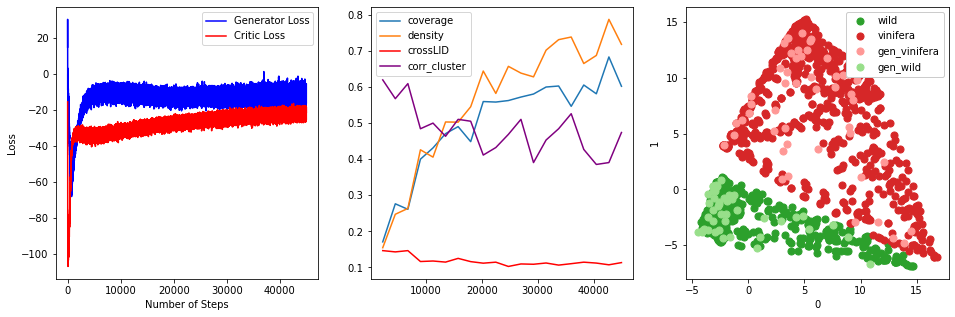

100%|██████████████████████████████████████████████████████████████████████████| 45000/45000 [2:43:45<00:00,  4.58it/s]


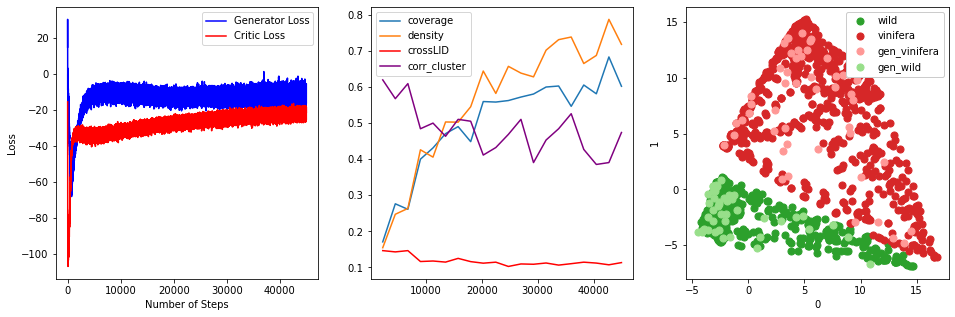

In [17]:
# Store results
gen_loss_all = []
crit_loss_all = []
saved_predictions = []
coverage = []
density = []
crossLID = []
corr1stcluster = []

GENERATE = True
if GENERATE:
    generator_optimizer = tf.keras.optimizers.RMSprop(1e-4)
    critic_optimizer = tf.keras.optimizers.RMSprop(1e-4)

    generator = generator_model(data_bin.shape[1], data_bin.shape[1], 2, 256)
    critic = critic_model(data_bin.shape[1], 2, 512)

    training_montage(data_bin, lbls, 1000, generator, critic, generator_optimizer, critic_optimizer,
                     input_realdata_dist, batch_size, grad_pen_weight=10, k_cov_den=20, k_crossLID=15)

    #    results[i]={'gen_loss': gen_loss_all, 'crit_loss1': crit_loss1_all, 'crit_loss2': crit_loss2_all,
    #                'saved_pred': saved_predictions,
    #                'coverage': coverage, 'density': density, 'crossLID': crossLID, 'corr1st_cluster': corr1stcluster}

In [18]:
if GENERATE:
    # Save the generator and critic models' weights.
    generator.save_weights('gan_models/GD_gen_bin')
    critic.save_weights('gan_models/GD_crit_bin')
else:
    # Read back the saved model
    generator_optimizer = tf.keras.optimizers.RMSprop(1e-3)
    critic_optimizer = tf.keras.optimizers.RMSprop(1e-3)

    generator = generator_model(data_bin.shape[1], data_bin.shape[1], 2, 256)
    critic = critic_model(data_bin.shape[1], 2, 512)

    # Load Previously saved models
    generator.load_weights('./gan_models/GD_gen_bin')
    critic.load_weights('./gan_models/GD_crit_bin')

#### Generate examples from our new code

- Generate examples in bulk - predictions (GAN data)
- Select only the 5 most correlated generated samples with each of the original samples - corr_preds (CorrGAN Data)

In [19]:
num_examples_to_generate = 2048
test_input = tf.constant(input_realdata_dist.rvs(size=len(data_bin.columns)*num_examples_to_generate),
                         shape=[num_examples_to_generate, len(data_bin.columns)])
test_labels = tf.constant([1]*(num_examples_to_generate//2) + [0]*(num_examples_to_generate//2), shape=[
        num_examples_to_generate,1])

predictions = generator([test_input, test_labels], training=False)
predictions = tf.argmax(predictions, predictions.get_shape().ndims-1) # Select the highest probability between the 0 or 1 value
# for each feature
predictions = pd.DataFrame(predictions.numpy(), columns=data_bin.columns)

test_labels = tf.constant([1]*(num_examples_to_generate//2) + [0]*(num_examples_to_generate//2), shape=[
        num_examples_to_generate,])

See correlation between samples and choose the 5 most correlated generated samples for each of the original samples.

In [20]:
df = datasets['vitis_types']['BinSim']
# Calculate all correlations between all samples of real and artificial data and store them in a dataframe
correlations = pd.DataFrame(index=predictions.index, columns=df.index).astype('float')

for i in df.index:
    for j in predictions.index:
        correlations.loc[j,i] = stats.pearsonr(df.loc[i],
                                               predictions.loc[j])[0]

In [21]:
# Indices to keep in the correlated GAN data
idx_to_keep = []
for i in correlations:
    idx_to_keep.extend(correlations[i].sort_values(ascending=False).index[:5])
    
print('Nº of total idx :', len(idx_to_keep))
print('Nº of unique idx:', len(set(idx_to_keep)))

Nº of total idx : 165
Nº of unique idx: 165


In [22]:
# Make the correlation GAN dataframe and corresponding label targets
corr_preds = predictions.loc[list(set(idx_to_keep))]
corr_lbls  = list(np.array(test_labels)[list(set(idx_to_keep))])

In [23]:
# Redo prediction with a smaller number of samples this time
num_examples_to_generate = 512
test_input = tf.constant(input_realdata_dist.rvs(size=len(data_bin.columns)*num_examples_to_generate),
                         shape=[num_examples_to_generate, len(data_bin.columns)])
test_labels = tf.constant([1]*(num_examples_to_generate//2) + [0]*(num_examples_to_generate//2), shape=[
        num_examples_to_generate,1])

predictions = generator([test_input, test_labels], training=False)
predictions = tf.argmax(predictions, predictions.get_shape().ndims-1)
predictions = pd.DataFrame(predictions.numpy(), columns=data_bin.columns)

### Inducing noise on Feature Occurrence Data Method Sample Generation

In [24]:
# Inducing noise on linearly interpolated feature occurrence data
noise_df = data_bin.copy()
for i in tqdm(range(len(data_bin.index))):
    if lbls_bin[i] == 'wild':
        noise_df.iloc[i] = laf.imbalanced_noise_inducer(
            data_bin.iloc[i], noise_fraction=0.10, method='random sampling', noise_fraction_changer=True,
            data = datasets['vitis_types']['BinSim'].loc[np.array(datasets['vitis_types']['target'])=='wild'])
    else:
        noise_df.iloc[i] = laf.imbalanced_noise_inducer(
            data_bin.iloc[i], noise_fraction=0.10, method='random sampling', noise_fraction_changer=True,
            data = datasets['vitis_types']['BinSim'].loc[np.array(datasets['vitis_types']['target'])=='vinifera'])
        
int_noise_df = noise_df
int_noise_lbls = lbls_bin.copy()

100%|█████████████████████████████████████████████████████████████████████████████| 1536/1536 [00:04<00:00, 327.63it/s]


### Loss Plot and PCAs and tSNEs representation on the evolution of generated samples with epochs

Measures of progression of the model in time.

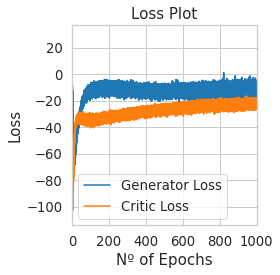

In [25]:
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        steps_per_epoch = int((data_bin.shape[0]-96) / 32)
        f, ax = plt.subplots(1, 1, figsize=(4,4))
        ax.plot(range(1,len(gen_loss_all)+1), gen_loss_all, label='Generator Loss')
        ax.plot(range(1,len(crit_loss_all)+1), crit_loss_all, label='Critic Loss')
        ax.set_xticks(range(0, 1001*steps_per_epoch, 200*steps_per_epoch))
        ax.set_xticklabels(range(0, 1001, 200))

        ax.legend()
        ax.set_xlim([0*steps_per_epoch,1000*steps_per_epoch])
        ax.set_xlabel('Nº of Epochs', fontsize=15)
        ax.set_ylabel('Loss', fontsize=15)
        ax.set_title('Loss Plot', fontsize=15)
        plt.tight_layout()
        f.savefig('images/GDbin_LossPlot.png' , dpi=300)

In [26]:
# Transform predictions into Pandas DataFrames
for i in range(len(saved_predictions)):
    saved_predictions[i] = pd.DataFrame(saved_predictions[i].numpy(), columns=data_bin.columns)

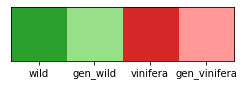

In [27]:
sns.palplot(label_colors_test.values())
new_ticks_test = plt.xticks(range(len(ordered_labels_test)), ordered_labels_test)

**PCA and tSNE of GAN generated data and the linearly generated 'test data'**

Progression with number of epochs.

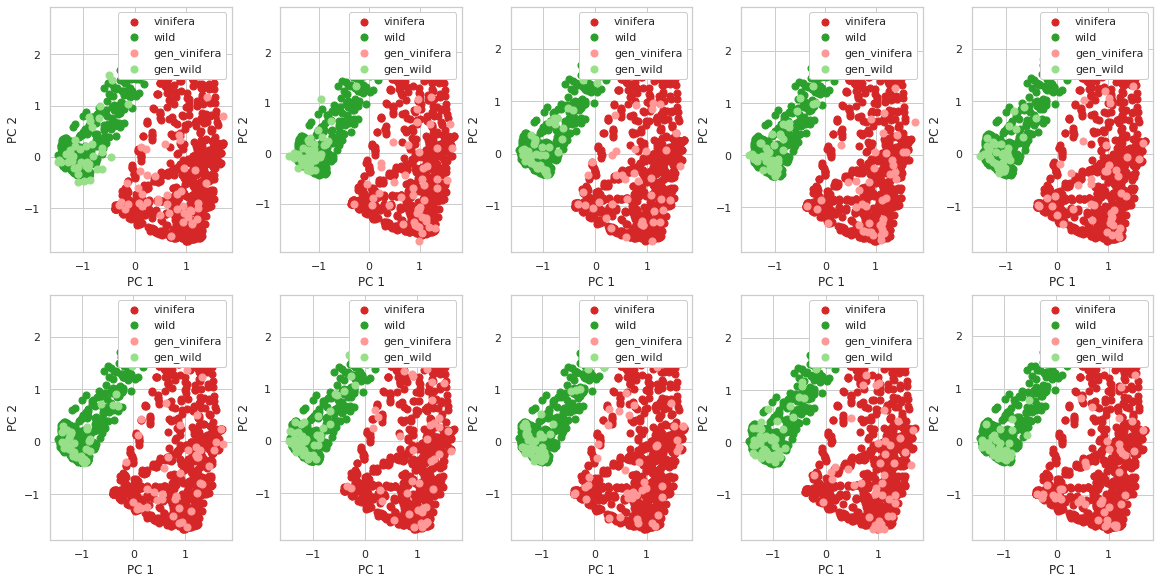

In [28]:
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1):
        f, axs = plt.subplots(2,5, figsize=(16,8), constrained_layout=True)
        
        for i, ax in zip(range(0, len(saved_predictions),2), axs.ravel()):
            dfs_temp = pd.concat((data_bin, saved_predictions[i]))
            temp_lbls = lbls_bin.copy()
            temp_lbls.extend(['gen_vinifera']*(len(saved_predictions[-1])//2))
            temp_lbls.extend(['gen_wild']*(len(saved_predictions[-1])//2))
            
            principaldf = ma.compute_df_with_PCs(dfs_temp, n_components=2, whiten=True, labels=temp_lbls,
                                                 return_var_ratios=False)

            lcolors = label_colors_test
            
            gem.plot_PCA(principaldf, lcolors, components=(1,2), title='', ax=ax)
            #plot_ellipses_PCA(principaldf, lcolors, components=(1,2),ax=ax, q=0.95)
            ax.legend(loc='upper right', ncol=1, framealpha=1)
        

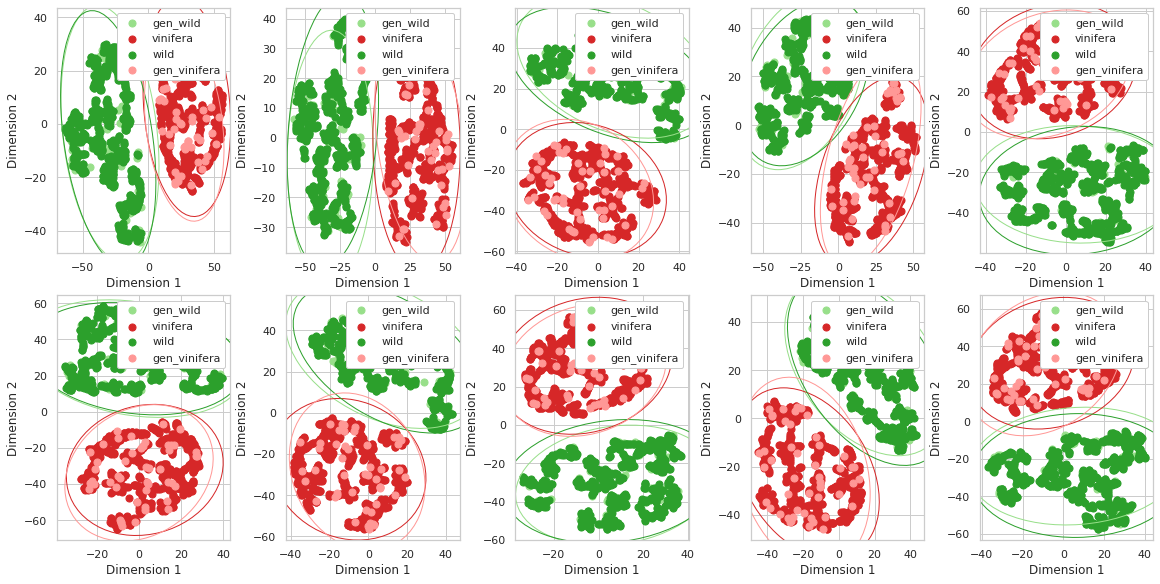

In [29]:
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1):
        f, axs = plt.subplots(2,5, figsize=(16,8), constrained_layout=True)
        
        for i, ax in zip(range(0, len(saved_predictions), 2), axs.ravel()):
            
            dfs_temp = pd.concat((data_bin, saved_predictions[i]))
            temp_lbls = lbls_bin.copy()
            temp_lbls.extend(['gen_vinifera']*(len(saved_predictions[-1])//2))
            temp_lbls.extend(['gen_wild']*(len(saved_predictions[-1])//2))
            
            X = dfs_temp.copy()
            X_embedded = TSNE(n_components=2, perplexity=30, learning_rate='auto',
                              init='random', verbose=0).fit_transform(X)

            df = X_embedded
            labels = temp_lbls
            lcolors = label_colors_test
            
            gem.plot_tSNE(df, labels, lcolors, components=(1,2), title='', ax=ax)
            gem.plot_ellipses_tSNE(df, labels, lcolors, components=(1,2),ax=ax, q=0.95)
            ax.legend(loc='upper right', ncol=1, framealpha=1)

**PCA and tSNE of GAN generated data and real data**

Progression with number of epochs.

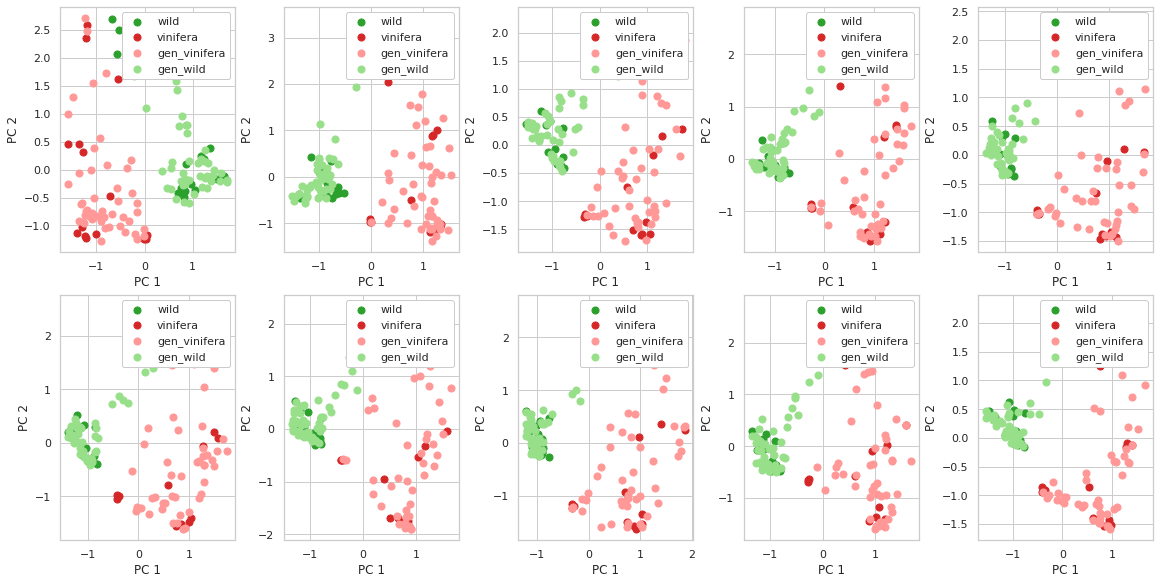

In [30]:
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1):
        f, axs = plt.subplots(2,5, figsize=(16,8), constrained_layout=True)
        
        for i, ax in zip(range(0, len(saved_predictions),2), axs.ravel()):
            p = saved_predictions[i].copy()
            p.columns = datasets['vitis_types']['BinSim'].columns
            dfs_temp = pd.concat((datasets['vitis_types']['BinSim'],
                                  p))
            temp_lbls = datasets['vitis_types']['target'].copy()
            temp_lbls.extend(['gen_vinifera']*(len(saved_predictions[-1])//2))
            temp_lbls.extend(['gen_wild']*(len(saved_predictions[-1])//2))
            
            principaldf = ma.compute_df_with_PCs(dfs_temp, n_components=2, whiten=True, labels=temp_lbls,
                                                 return_var_ratios=False)

            lcolors = label_colors_test
            
            gem.plot_PCA(principaldf, lcolors, components=(1,2), title='', ax=ax)
            #gem.plot_ellipses_PCA(principaldf, lcolors, components=(1,2),ax=ax, q=0.95)
            ax.legend(loc='upper right', ncol=1, framealpha=1)
        

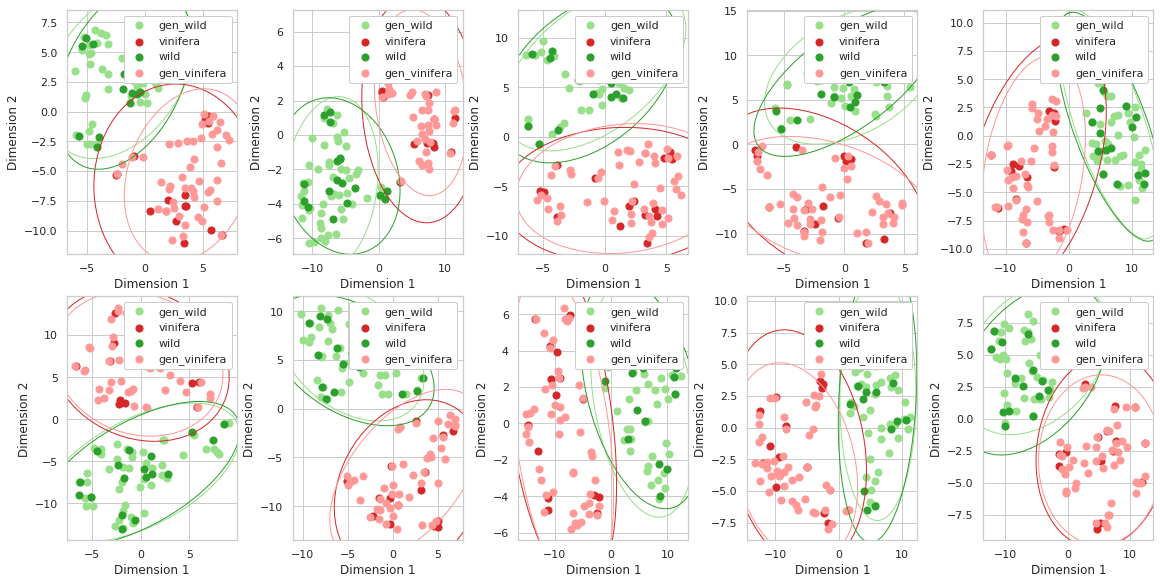

In [31]:
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1):
        f, axs = plt.subplots(2,5, figsize=(16,8), constrained_layout=True)
        
        for i, ax in zip(range(0, len(saved_predictions), 2), axs.ravel()):
            
            p = saved_predictions[i].copy()
            p.columns = datasets['vitis_types']['BinSim'].columns
            dfs_temp = pd.concat((datasets['vitis_types']['BinSim'], p))
            temp_lbls = datasets['vitis_types']['target'].copy()
            temp_lbls.extend(['gen_vinifera']*(len(saved_predictions[-1])//2))
            temp_lbls.extend(['gen_wild']*(len(saved_predictions[-1])//2))
            
            X = dfs_temp.copy()
            X_embedded = TSNE(n_components=2, perplexity=30, learning_rate='auto',
                              init='random', verbose=0).fit_transform(X)

            df = X_embedded
            labels = temp_lbls
            lcolors = label_colors_test
            
            gem.plot_tSNE(df, labels, lcolors, components=(1,2), title='', ax=ax)
            gem.plot_ellipses_tSNE(df, labels, lcolors, components=(1,2),ax=ax, q=0.95)
            ax.legend(loc='upper right', ncol=1, framealpha=1)

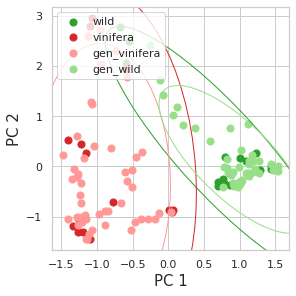

In [32]:
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1):
        f, ax = plt.subplots(1,1, figsize=(4,4), constrained_layout=True)
            
        p = saved_predictions[-1].copy()
        p.columns = datasets['vitis_types']['BinSim'].columns
        dfs_temp = pd.concat((datasets['vitis_types']['BinSim'], p))
        temp_lbls = datasets['vitis_types']['target'].copy()
        temp_lbls.extend(['gen_vinifera']*(len(saved_predictions[-1])//2))
        temp_lbls.extend(['gen_wild']*(len(saved_predictions[-1])//2))

        principaldf = ma.compute_df_with_PCs(dfs_temp, n_components=2, whiten=True, labels=temp_lbls,
                                                 return_var_ratios=False)

        lcolors = label_colors_test

        gem.plot_PCA(principaldf, lcolors, components=(1,2), title='', ax=ax)
        gem.plot_ellipses_PCA(principaldf, lcolors, components=(1,2),ax=ax, q=0.95)
        ax.set_ylabel('PC 2', fontsize=15)
        ax.set_xlabel('PC 1', fontsize=15)
        ax.legend(loc='upper left', ncol=1, framealpha=0.8)
        f.savefig('images/GDbin_PCAPlot.png' , dpi=300)

### Comparing GAN Generated Data Characteristics with experimental data

In [33]:
names = ['Real data', 'GAN data', 'CorrGAN data', 'Noise I. data']
data_repo = [datasets['vitis_types']['BinSim'], predictions, corr_preds, int_noise_df]
tgs = [datasets['vitis_types']['target'], ['gen_vinifera']*(len(saved_predictions[-1])//2) +
      ['gen_wild']*(len(saved_predictions[-1])//2), corr_lbls, int_noise_lbls]
data_characteristics = [gem.characterize_binary_data(ds, name, tg) for ds,name,tg in zip(data_repo, names, tgs)]

data_characteristics = pd.DataFrame(data_characteristics).set_index('Dataset')
data_characteristics

,# samples,# features,average # of features per sample (std),# features per sample ranges,# features per sample median,average # of times feature appear in sample (std),min and max # of times a feature appears in a sample,# classes,samples / class
Dataset,,,,,,,,,
Real data,33,3629,658.36 (199.25),(367.0 - 1002.0),592.0,5.99 (5.75),2.0 - 33.0,2,16.5
GAN data,512,3629,656.77 (148.72),(386 - 1133),619.0,92.66 (90.39),0 - 512,2,48.0
CorrGAN data,165,3629,663.06 (182.67),(389 - 1054),608.0,30.15 (28.88),0 - 165,2,82.5
Noise I. data,1536,3629,659.17 (175.22),(332.0 - 1103.0),627.0,279.0 (237.61),18.0 - 1505.0,2,768.0


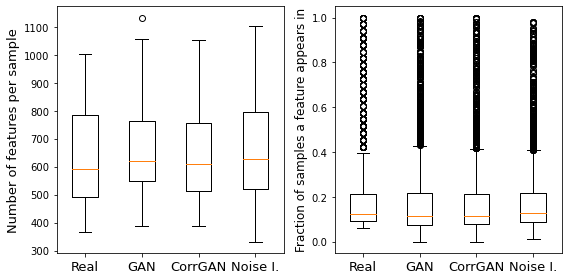

In [34]:
f, (axl, axr) = plt.subplots(1,2, figsize=(8,4))

names = ['Real', 'GAN', 'CorrGAN', 'Noise I.']
axl.boxplot([ds.sum(axis=1) for ds in data_repo])
axl.set_ylabel('Number of features per sample', fontsize=13)
axl.set_xticklabels(names, fontsize=13)
#axl.set_yticks([-2, 0, 2, 4])

axr.boxplot([ds.sum(axis=0)/len(ds) for ds in data_repo])
axr.set_ylabel('Fraction of samples a feature appears in', fontsize=12)
axr.set_xticklabels(names, fontsize=13)

plt.tight_layout()
plt.show()
f.savefig('images/GDbin_characteristics.png' , dpi=300)

### Hierarchical Clustering

Hierarchical clustering of the latest predictions and testing data (96 random samples from linearly generated data). 

In [35]:
# Hierarchical clustering of the latest predictions and testing data, 
dfs_temp = np.concatenate((test_data, saved_predictions[-1].values))
test_labels = np.array(lbls_bin)[np.random.RandomState(seed=145).permutation(len(data_bin))][-3*batch_size:]
temp_lbls = list(test_labels) + ['gen_vinifera']*(len(saved_predictions[-1])//2) + ['gen_wild']*(len(saved_predictions[-1])//2)

hca_results = gem.perform_HCA(dfs_temp, temp_lbls, metric='jaccard', method='ward')

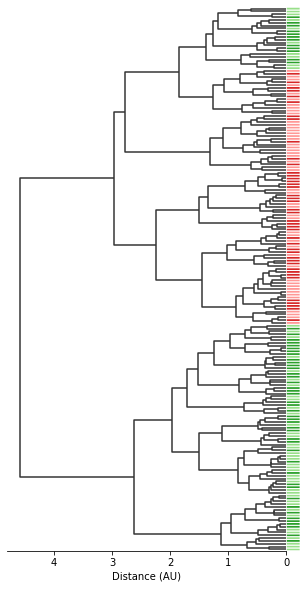

In [36]:
f, ax = plt.subplots(figsize=(5, 10))
gem.plot_dendogram(hca_results['Z'], 
               temp_lbls, ax=ax,
               label_colors=label_colors_test, title='',
               color_threshold=0)
ax.set_yticklabels([])
plt.show()

Hierarchical clustering of the latest predictions and experimental data.

In [37]:
dfs_temp = np.concatenate((datasets['vitis_types']['BinSim'].values, saved_predictions[-1]))
#test_labels = datasets['vitis_types']['NGP'].values
temp_lbls = list(datasets['vitis_types']['target']) + ['gen_vinifera']*(
    len(saved_predictions[-1])//2) + ['gen_wild']*(len(saved_predictions[-1])//2)
hca_results = gem.perform_HCA(dfs_temp, temp_lbls, metric='jaccard', method='ward')

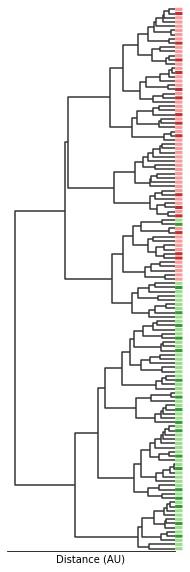

In [38]:
f, ax = plt.subplots(figsize=(3, 10))
gem.plot_dendogram(hca_results['Z'], 
               temp_lbls, ax=ax,
               label_colors=label_colors_test, title='',
               color_threshold=0)
ax.set_yticklabels([])
ax.set_xticks([])
plt.show()
f.savefig('images/GDbin_HCAPlot.png' , dpi=300)

### Coverage and Density

In [39]:
training_set = tf.constant(all_data[:-3*batch_size])

density_list, coverage_list = gem.evaluation_coverage_density_all_k_at_once(training_set, predictions, 
                                                                            metric='jaccard')

density_list_test, coverage_list_test = gem.evaluation_coverage_density_all_k_at_once(training_set, test_data, 
                                                                                      metric='jaccard')

#testing_set = tf.constant(all_data[:-3*batch_size])
density_list_real, coverage_list_real = gem.evaluation_coverage_density_all_k_at_once(datasets['vitis_types']['BinSim'], 
                                                                                      predictions, metric='jaccard')

density_list_corr, coverage_list_corr = gem.evaluation_coverage_density_all_k_at_once(training_set, corr_preds,
                                                                                      metric='jaccard')

density_list_noise, coverage_list_noise = gem.evaluation_coverage_density_all_k_at_once(training_set, 
                                                                                      int_noise_df,
                                                                                      metric='jaccard')

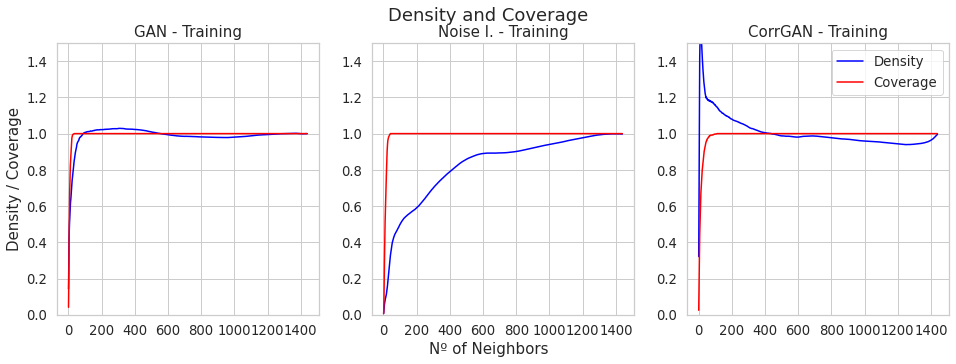

In [40]:
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        f, (axl, axc, axr) = plt.subplots(1, 3, figsize = (16,5))#, sharey='row')#, sharex='col')
        
        axl.plot(range(1,len(training_set)), density_list, label='Density', color='blue')
        axl.plot(range(1,len(training_set)), coverage_list, label='Coverage', color='red')
        axl.set_title('GAN - Training', fontsize=15)
        axl.set_ylabel('Density / Coverage', fontsize=15)
        axl.set_ylim([0,1.5])
        
        axc.plot(range(1,len(training_set)), density_list_noise, label='Density', color='blue')
        axc.plot(range(1,len(training_set)), coverage_list_noise, label='Coverage', color='red')
        axc.set_title('Noise I. - Training', fontsize=15)
        axc.set_ylim([0,1.5])
        
        axr.plot(range(1,len(training_set)), density_list_corr, label='Density', color='blue')
        axr.plot(range(1,len(training_set)), coverage_list_corr, label='Coverage', color='red')
        axr.set_title('CorrGAN - Training', fontsize=15)
        axr.set_ylim([0,1.5])
        
        #axr.plot(range(1,len(datasets['vitis_types']['NGP'])), density_list_real, label='Density', color='blue')
        #axr.plot(range(1,len(datasets['vitis_types']['NGP'])), coverage_list_real, label='Coverage', color='red')
        #axr.set_title('GAN - Real Data', fontsize=15)
        #axr.set_ylim([0,1.5])
        
        axr.legend()
        plt.suptitle('Density and Coverage', fontsize=18)

    f.text(0.5, 0.05, 'Nº of Neighbors', ha='center', va='top', fontsize=15)

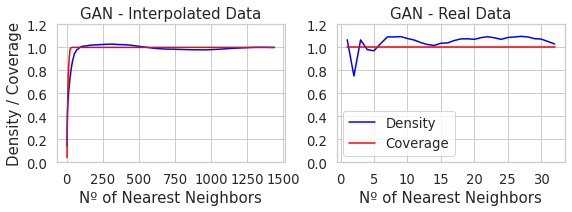

In [41]:
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        f, (axl, axr) = plt.subplots(1, 2, figsize = (8,3))#, sharey='row')#, sharex='col')
        
        axl.plot(range(1,len(training_set)), density_list, label='Density', color='blue')
        axl.plot(range(1,len(training_set)), coverage_list, label='Coverage', color='red')
        axl.set_title('GAN - Interpolated Data', fontsize=15)
        axl.set_ylabel('Density / Coverage', fontsize=15)
        axl.set_ylim([0,1.2])
        axl.set_xlabel('Nº of Nearest Neighbors', fontsize=15)

        axr.plot(range(1,len(datasets['vitis_types']['BinSim'])), density_list_real, label='Density', color='blue')
        axr.plot(range(1,len(datasets['vitis_types']['BinSim'])), coverage_list_real, label='Coverage', color='red')
        axr.set_title('GAN - Real Data', fontsize=15)
        axr.set_ylim([0,1.2])
        
        axr.legend()
        axr.set_xlabel('Nº of Nearest Neighbors', fontsize=15)
        #plt.suptitle('Density and Coverage', fontsize=18)

    plt.tight_layout()
    f.savefig('images/GDbin_DenCovPlot.png' , dpi=300)

### CrossLID (Local Intrinsic Dimensionality) Evaluation

In [140]:
%%capture --no-stdout
# Capture warnings on this cell

training_set = tf.constant(all_data[:-3*batch_size])
CrossLIDs = {}

c_lid = gem.cross_LID_estimator_byMLE_all_k_at_once(datasets['vitis_types']['BinSim'], predictions, 
                                                metric='jaccard')
CrossLIDs['RealVGAN'] = c_lid
print('Real - GAN Done')

c_lid = gem.cross_LID_estimator_byMLE_all_k_at_once(training_set, predictions, metric='jaccard')
CrossLIDs['LinearVGAN'] = c_lid
print('Linear - GAN Done')

c_lid = gem.cross_LID_estimator_byMLE_all_k_at_once(datasets['vitis_types']['BinSim'],
                                                    training_set, metric='jaccard')
CrossLIDs['RealVLinear'] = c_lid
print('Real - Linear Done')

c_lid = gem.cross_LID_estimator_byMLE_all_k_at_once(datasets['vitis_types']['BinSim'],
                                                    corr_preds, metric='jaccard')
CrossLIDs['RealVCorrGAN'] = c_lid
print('Real - CorrGAN Done')

c_lid = gem.cross_LID_estimator_byMLE_all_k_at_once(datasets['vitis_types']['BinSim'],
                                                    int_noise_df,
                                                    metric='jaccard')
CrossLIDs['RealVNoise'] = c_lid
print('Real - Noise Done')

Real - GAN Done
Linear - GAN Done
Real - Linear Done
Real - CorrGAN Done
Real - Noise Done


In [43]:
%%capture --no-stdout
# Capture warnings on this cell

LIDs = {}

lid = gem.local_intrinsic_dimensionality_estimator_byMLE_all_k_at_once(predictions, metric='jaccard')
LIDs['GAN'] = lid
print('GAN Data Done')

lid = gem.local_intrinsic_dimensionality_estimator_byMLE_all_k_at_once(data_bin, metric='jaccard')
LIDs['Linear'] = lid
print('Linearly Generated Set Done')

lid = gem.local_intrinsic_dimensionality_estimator_byMLE_all_k_at_once(datasets['vitis_types']['BinSim'], metric='jaccard')
LIDs['Real'] = lid
print('Real Data Done')

lid = gem.local_intrinsic_dimensionality_estimator_byMLE_all_k_at_once(corr_preds, metric='jaccard')
LIDs['CorrGAN'] = lid
print('CorrGAN Data Done')

lid = gem.local_intrinsic_dimensionality_estimator_byMLE_all_k_at_once(int_noise_df, metric='jaccard')
LIDs['Noise'] = lid
print('Noise Data Done')

GAN Data Done
Linearly Generated Set Done
Real Data Done
CorrGAN Data Done
Noise Data Done


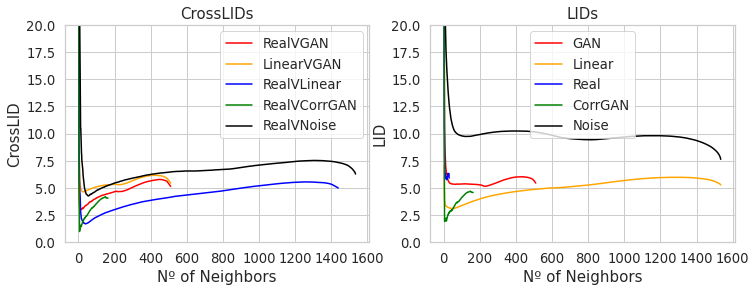

In [44]:
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        f, (axl, axr) = plt.subplots(1, 2, figsize=(12,4))
        c = {'LinearVGAN': 'Orange', 'RealVGAN': 'Red', 'RealVLinear': 'Blue', 'RealVCorrGAN': 'Green', 'RealVNoise': 'black'}
        for l, data in CrossLIDs.items():
            axl.plot(range(2,len(data)+2), data, label=l, color = c[l])
            
        axl.set_ylim([0,20])
        axl.legend()
        axl.set_xlabel('Nº of Neighbors', fontsize=15)
        axl.set_ylabel('CrossLID', fontsize=15)
        axl.set_title('CrossLIDs', fontsize=15)
        
        c = {'GAN': 'Red', 'Linear': 'Orange', 'Real': 'Blue', 'CorrGAN': 'Green', 'Noise': 'black'}
        for l, data in LIDs.items():
            axr.plot(range(2,len(data)+2), data, label=l, color = c[l])
            
        axr.set_ylim([0,20])
        axr.legend()
        axr.set_xlabel('Nº of Neighbors', fontsize=15)
        axr.set_ylabel('LID', fontsize=15)
        axr.set_title('LIDs', fontsize=15)

### Histograms
 
Histograms of Values of normal Real, Generated and GAN Generated Data.

In [45]:
last_preds = predictions

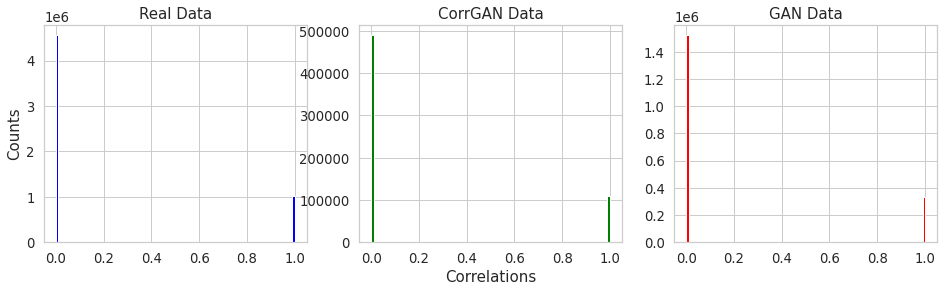

In [46]:
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        f, (axl, axc, axr) = plt.subplots(1, 3, figsize = (16,4))#, sharey='row')#, sharex='col')
        
        n_bins = 34
        axl.hist(data_bin.values.flatten(), bins=100, color='blue')
        axl.set_title('Real Data', fontsize=15)
        axl.set_ylabel('Counts', fontsize=15)
        
        axc.hist(corr_preds.values.flatten(), bins=100, color='green')
        axc.set_title('CorrGAN Data', fontsize=15)
        axc.set_xlabel('Correlations', fontsize=15)
        
        axr.hist(last_preds.values.flatten(), bins=100, color='red')
        axr.set_title('GAN Data', fontsize=15)

### Correlations between samples of Real Data and GAN Generated Data

In [47]:
correlation_real_real = gem.create_sample_correlations(datasets['vitis_types']['BinSim'], datasets['vitis_types']['BinSim'],
                                                   method='pearson')
print('Correlation Real-Real calculation ended.')

correlation_lin_lin = gem.create_sample_correlations(data_bin, data_bin,
                                                   method='pearson')
print('Correlation Linear-Linear calculation ended.')

correlation_gan_gan = gem.create_sample_correlations(last_preds, last_preds,
                                                   method='pearson')
print('Correlation GAN-GAN calculation ended.')

correlation_corr_corr = gem.create_sample_correlations(corr_preds, corr_preds,
                                                   method='pearson')
print('Correlation CorrGAN-CorrGAN calculation ended.')

correlation_noise_noise = gem.create_sample_correlations(int_noise_df, int_noise_df,
                                                   method='pearson')
print('Correlation Noise-Noise calculation ended.')

Correlation Real-Real calculation ended.
Correlation Linear-Linear calculation ended.
Correlation GAN-GAN calculation ended.
Correlation CorrGAN-CorrGAN calculation ended.
Correlation Noise-Noise calculation ended.


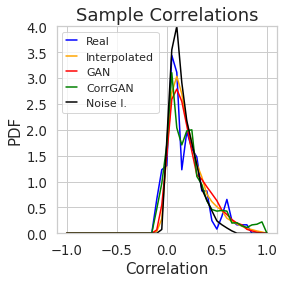

In [48]:
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        f, ax = plt.subplots(1, 1, figsize = (4,4))#, sharey='row')#, sharex='col')
        X = np.arange(-1, 1.01, 0.05)
        hist = np.histogram(correlation_real_real.values.flatten(), bins=50)
        hist_dist = stats.rv_histogram(hist)
        ax.plot(X, hist_dist.pdf(X), color='blue', label='Real')
        ax.set_ylabel('PDF', fontsize=15)
        
        hist = np.histogram(correlation_lin_lin.values.flatten(), bins=50)
        hist_dist = stats.rv_histogram(hist)
        ax.plot(X, hist_dist.pdf(X), color='orange', label='Interpolated')
        
        hist = np.histogram(correlation_gan_gan.values.flatten(), bins=50)
        hist_dist = stats.rv_histogram(hist)
        ax.plot(X, hist_dist.pdf(X), color='red', label='GAN')
        
        hist = np.histogram(correlation_corr_corr.values.flatten(), bins=50)
        hist_dist = stats.rv_histogram(hist)
        ax.plot(X, hist_dist.pdf(X), color='green', label='CorrGAN')
        
        hist = np.histogram(correlation_noise_noise.values.flatten(), bins=50)
        hist_dist = stats.rv_histogram(hist)
        ax.plot(X, hist_dist.pdf(X), color='black', label='Noise I.')
        
        ax.legend(handlelength=1, fontsize=11)
        ax.set_title('Sample Correlations', fontsize=18)
        ax.set_xlabel('Correlation', fontsize=15)
        ax.set_ylim([0,4])

    #f.text(0.5, 0.05, 'Correlation', ha='center', va='top', fontsize=15)
    plt.tight_layout()
    f.savefig('images/GDbin_SampCorrPlot.png', dpi=300)

### Correlations between features of Real, Generated and GAN Generated Samples

In [49]:
%%capture --no-stdout
# Capture warnings on this cell

correlation_real_real = gem.create_sample_correlations(datasets['vitis_types']['BinSim'].T, datasets['vitis_types']['BinSim'].T,
                                                   method='pearson')
print('Correlation Real-Real calculation ended.')

correlation_gen_gen = gem.create_sample_correlations(data_bin.T, data_bin.T,
                                                   method='pearson')
print('Correlation Generated-Generated calculation ended.')

correlation_gan_gan = gem.create_sample_correlations(last_preds.T, last_preds.T,
                                                   method='pearson')
print('Correlation GAN-GAN calculation ended.')

correlation_corr_corr = gem.create_sample_correlations(corr_preds.T, corr_preds.T,
                                                   method='pearson')
print('Correlation CorrGAN-CorrGAN calculation ended.')

correlation_noise_noise = gem.create_sample_correlations(int_noise_df.T, int_noise_df.T,
                                                   method='pearson')
print('Correlation Noise-Noise calculation ended.')

Correlation Real-Real calculation ended.
Correlation Generated-Generated calculation ended.
Correlation GAN-GAN calculation ended.
Correlation CorrGAN-CorrGAN calculation ended.
Correlation Noise-Noise calculation ended.


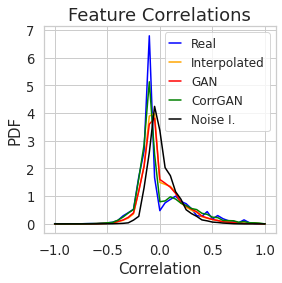

In [50]:
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        f, ax = plt.subplots(1, 1, figsize = (4,4))#, sharey='row')#, sharex='col')
        X = np.arange(-1, 1.01, 0.05)
        hist = np.histogram(correlation_real_real.values.flatten()[~np.isnan(correlation_real_real.values.flatten())], bins=50)
        hist_dist = stats.rv_histogram(hist)
        ax.plot(X, hist_dist.pdf(X), color='blue', label='Real')
        ax.set_ylabel('PDF', fontsize=15)
        
        hist = np.histogram(correlation_gen_gen.values.flatten()[~np.isnan(correlation_gen_gen.values.flatten())], bins=50)
        hist_dist = stats.rv_histogram(hist)
        ax.plot(X, hist_dist.pdf(X), color='orange', label='Interpolated')
        
        hist = np.histogram(correlation_gan_gan.values.flatten()[~np.isnan(correlation_gan_gan.values.flatten())], bins=50)
        hist_dist = stats.rv_histogram(hist)
        ax.plot(X, hist_dist.pdf(X), color='red', label='GAN')
        
        hist = np.histogram(correlation_corr_corr.values.flatten()[~np.isnan(correlation_corr_corr.values.flatten())], bins=50)
        hist_dist = stats.rv_histogram(hist)
        ax.plot(X, hist_dist.pdf(X), color='green', label='CorrGAN')
        
        hist = np.histogram(correlation_noise_noise.values.flatten()[~np.isnan(correlation_noise_noise.values.flatten())],
                            bins=50)
        hist_dist = stats.rv_histogram(hist)
        ax.plot(X, hist_dist.pdf(X), color='black', label='Noise I.')
        
        ax.legend(handlelength=1, fontsize=12)
        ax.set_title('Feature Correlations', fontsize=18)
        ax.set_xlabel('Correlation', fontsize=15)

    #f.text(0.5, 0.05, 'Correlation', ha='center', va='top', fontsize=15)
    plt.tight_layout()
    f.savefig('images/GDbin_FeatCorrPlot.png', dpi=300)

### Profiles of features appearing in vinifera or wild samples

In [51]:
GAN_data = saved_predictions[-1]
GAN_lbls = ['wild']*48 + ['vinifera']*48
#GAN_lbls

In [52]:
vinifera_counts_GAN = []
wild_counts_GAN = []
for i in GAN_data.columns:
    vinifera_counts_GAN.append(GAN_data[i].iloc[48:].sum())
    wild_counts_GAN.append(- GAN_data[i].iloc[:48].sum())
#wild_counts_GAN    

In [53]:
vinifera_counts_linear = []
wild_counts_linear = []
for i in data_bin.columns:
    vinifera_counts_linear.append(data_bin[i].iloc[:len(data_bin)//2].sum())
    wild_counts_linear.append(- data_bin[i].iloc[len(data_bin)//2:].sum())

In [54]:
vinifera_counts_real = []
wild_counts_real = []
for i in datasets['vitis_types']['BinSim'].columns:
    subset = datasets['vitis_types']['BinSim'][[i=='vinifera' for i in datasets['vitis_types']['target']]]
    vinifera_counts_real.append(subset[i].sum())
    subset = datasets['vitis_types']['BinSim'][[i=='wild' for i in datasets['vitis_types']['target']]]
    wild_counts_real.append(- subset[i].sum())

Making bar plots representing the number of samples of each class each feature appears in (kinda of a profile of the dataset)

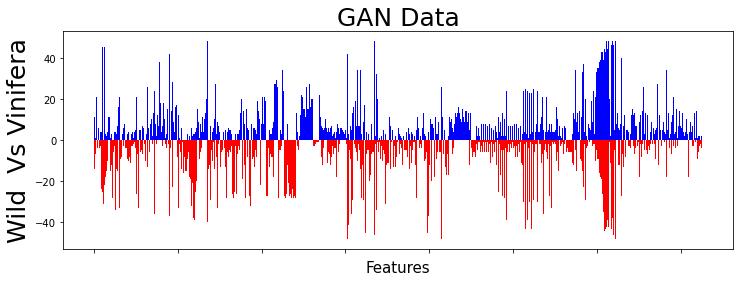

In [55]:
f, ax = plt.subplots(1, 1, figsize=(12, 4))

x = range(len(data_bin.columns))
ax.bar(x, wild_counts_GAN, width=1, color='r')
ax.bar(x, vinifera_counts_GAN, width=1, color='b')
ax.set_xticklabels([])
ax.set_xlabel('Features', fontsize=15)
ax.set_ylabel('Wild  Vs Vinifera', fontsize=25)
ax.set_title('GAN Data', fontsize=25)

plt.show()
#f.savefig('images/GDbin_ProfileGAN.png', dpi=300)

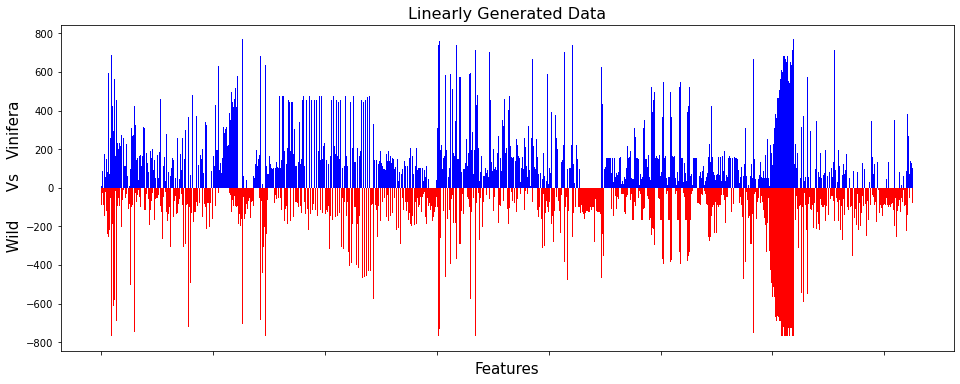

In [56]:
f, ax = plt.subplots(1, 1, figsize=(16, 6))

x = range(len(data_bin.columns))
ax.bar(x, wild_counts_linear, width=1, color='r')
ax.bar(x, vinifera_counts_linear, width=1, color='b')
ax.set_xticklabels([])
ax.set_xlabel('Features', fontsize=15)
ax.set_ylabel('     Wild      Vs   Vinifera', fontsize=15)
ax.set_title('Linearly Generated Data', fontsize=16)

plt.show()

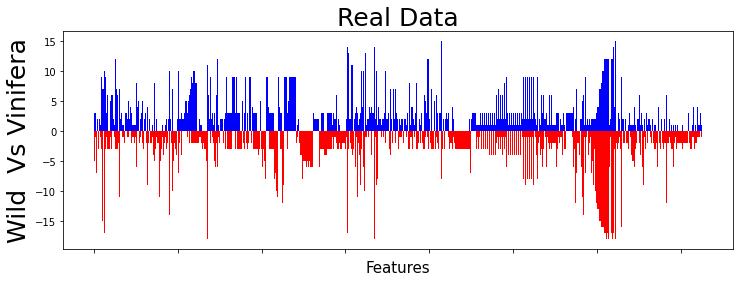

In [57]:
f, ax = plt.subplots(1, 1, figsize=(12, 4))

x = range(len(data_bin.columns))
ax.bar(x, wild_counts_real, width=1, color='r')
ax.bar(x, vinifera_counts_real, width=1, color='b')
ax.set_xticklabels([])
ax.set_xlabel('Features', fontsize=15)
ax.set_ylabel('Wild  Vs Vinifera', fontsize=25)
ax.set_title('Real Data', fontsize=25)

plt.show()
#f.savefig('images/GDbin_ProfileReaal.png', dpi=300)

### Sample Correlation Matrix

Between samples of the real data and a set of generated artificial samples of GANs

In [58]:
# Real Data, organize it to have first all samples of a class, then all samples of the other class
df = datasets['vitis_types']['BinSim'].copy()

samp = df.index
tg = datasets['vitis_types']['target'].copy()
new_order = [x for _, x in sorted(zip(tg, samp))]
new_tg = [x for x, _ in sorted(zip(tg, samp))]

df = df.loc[new_order]
#df

In [59]:
# Calculate all correlations between all samples of real and artificial data and store them in a dataframe
correlations = pd.DataFrame(index=last_preds.index, columns=df.index).astype('float')

for i in df.index:
    for j in last_preds.index:
        correlations.loc[j,i] = stats.pearsonr(df.loc[i],
                                               last_preds.loc[j])[0]
        
correlations.columns = new_tg
correlations.index = ['gen_vinifera']*(len(last_preds)//2) + ['gen_wild']*(len(last_preds)//2)

C:\Users\franc\anaconda3\lib\site-packages\seaborn\matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


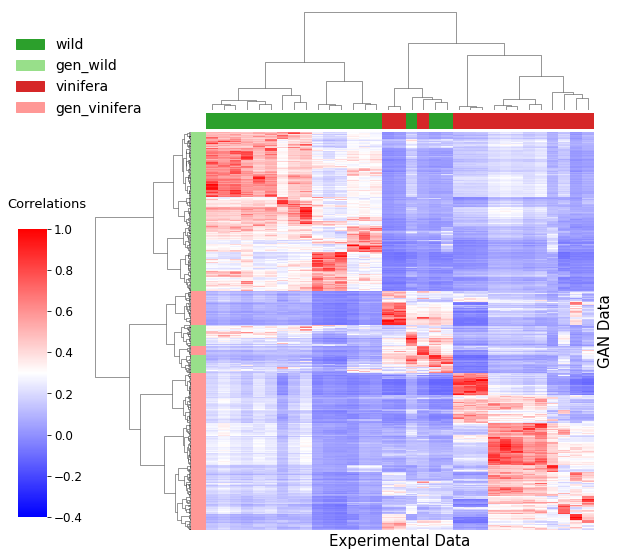

In [60]:
#%%capture --no-stdout
# Capture warnings on this cell

# Draw the clustermap
import matplotlib.patches as mpatches

row_cols = [label_colors_test[lbl] for lbl in new_tg]
row_cols2 = [label_colors_test[lbl] for lbl in correlations.index]
g = sns.clustermap(correlations, col_colors=row_cols, cmap='bwr', row_colors= row_cols2, vmin=-0.4, vmax=1, method='ward',
                  cbar_pos = (-0.11, 0.1, 0.05, 0.5))
g.fig.set_size_inches((8,8))
# some tweaks
patches = []
for lbl in ordered_labels_test:
    patches.append(mpatches.Patch(color=label_colors_test[lbl], label=lbl))
leg = plt.legend(handles=patches, loc=3, bbox_to_anchor=(-0.5, 1.35, 0.5, 1),
                     frameon=False, fontsize=14) 
g.ax_heatmap.set_ylabel('GAN Data', fontsize=15)
g.ax_heatmap.set_xlabel('Experimental Data', fontsize=15)
g.ax_heatmap.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, labelright=False)

# Manually specify colorbar labelling after it's been generated
colorbar = g.ax_heatmap.collections[0].colorbar
colorbar.ax.tick_params(labelsize=12) 
plt.text(1, 1.10, 'Correlations', fontsize=13, horizontalalignment='center')
#g.savefig('clustermap_Tryp.png' , dpi=300)
plt.show()
g.savefig('images/GDbin_Clustermap.png', dpi=300)

### CAS (Classification Accuracy Score)

See how well a model of Generated Samples can classify both linearly generated data (used to train the model) and real experimental data.

In [61]:
all_data = data_bin.iloc[np.random.RandomState(seed=145).permutation(len(data_bin))]

true_labels = np.array(lbls)[np.random.RandomState(seed=145).permutation(len(data_bin))]

# The same test data used after training the GAN data
test_labels = tf.constant(true_labels[-3*batch_size:])
test_data = tf.constant(all_data[-3*batch_size:])

GAN_lbls = ['vinifera']*(len(predictions)//2) + ['wild']*(len(predictions)//2)
corr_lbls2 = []
for i in corr_lbls:
    if i == 1:
        corr_lbls2.append('vinifera')
    else:
        corr_lbls2.append('wild')

In [62]:
# Test data and its labels (section of the linearly generated data)
t_data = pd.DataFrame(test_data.numpy(), columns=data_bin.columns)
t_labels = true_labels[-3*32:]

# Real data and its labels
r_data = datasets['vitis_types']['BinSim']
r_labels = datasets['vitis_types']['target']

**Random Forest Tests**

In [63]:
# Optimizing the model
top_tree_in_grid=300

# Vector with values for the parameter n_estimators
values = {'n_estimators': range(10,top_tree_in_grid,5)}

rf = skensemble.RandomForestClassifier(n_estimators=100)
clf = GridSearchCV(rf, values, cv=5)

# GAN Data
clf.fit(predictions, GAN_lbls)
GAN_param = clf.cv_results_['param_n_estimators']
GAN_test_score = clf.cv_results_['mean_test_score']

#CorrGAN data
clf.fit(corr_preds, corr_lbls)
corr_param = clf.cv_results_['param_n_estimators']
corr_test_score = clf.cv_results_['mean_test_score']

#Noise data
clf.fit(int_noise_df, int_noise_lbls)
noise_param = clf.cv_results_['param_n_estimators']
noise_test_score = clf.cv_results_['mean_test_score']

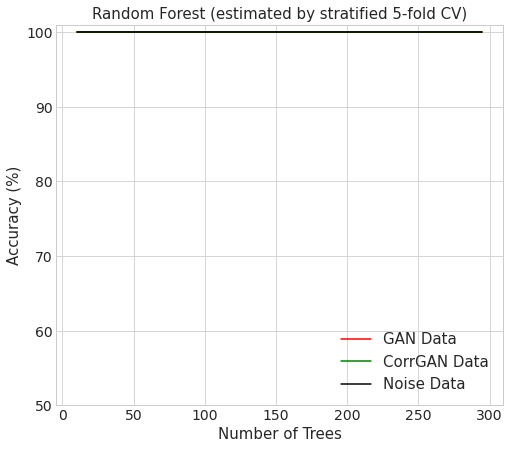

In [64]:
# Plotting the results and adjusting parameters of the plot
with plt.style.context('seaborn-whitegrid'):
    f, ax = plt.subplots(figsize=(8,7))

    plt.plot(GAN_param, GAN_test_score*100, color='red', label='GAN Data')
    plt.plot(corr_param, corr_test_score*100, color='green', label='CorrGAN Data')
    plt.plot(noise_param, noise_test_score*100, color='black', label='Noise Data')

    plt.ylabel('Accuracy (%)', fontsize = 15)
    plt.xlabel('Number of Trees', fontsize = 15)
    plt.ylim(50,101)
    plt.legend(loc='lower right', fontsize=15)
    ax.tick_params(axis='both', which='major', labelsize=14)
    plt.title('Random Forest (estimated by stratified 5-fold CV)', fontsize=15)

In [65]:
# Fitting the model Generated samples
rf_mod = ma.RF_model(last_preds, GAN_lbls, return_cv=True, iter_num=1, n_trees=200, cv=None, n_fold=5)

# Testing the linearly generated test data
print('Classifier from GAN Generated Data Performance in predicting other samples:')
print('Predicting Linearly Generated Data', rf_mod['model'].score(t_data, t_labels)*100, '%.')

# Testing the real data
r_data = datasets['vitis_types']['BinSim']
r_labels = datasets['vitis_types']['target']
print('Predicting Experimental Data', rf_mod['model'].score(r_data, r_labels)*100, '%.')

Classifier from GAN Generated Data Performance in predicting other samples:
Predicting Linearly Generated Data 100.0 %.
Predicting Experimental Data 100.0 %.


In [66]:
# Fitting the model Correlated Generated samples
rf_mod = ma.RF_model(corr_preds, corr_lbls2, return_cv=True, iter_num=1, n_trees=200, cv=None, n_fold=5)

# Testing the linearly generated test data
print('Classifier from GAN Generated Data Performance in predicting other samples:')
print('Predicting Linearly Generated Data', rf_mod['model'].score(t_data, t_labels)*100, '%.')

# Testing the real data
r_data = datasets['vitis_types']['BinSim']
r_labels = datasets['vitis_types']['target']
print('Predicting Experimental  Data', rf_mod['model'].score(r_data, r_labels)*100, '%.')

Classifier from GAN Generated Data Performance in predicting other samples:
Predicting Linearly Generated Data 100.0 %.
Predicting Experimental  Data 100.0 %.


In [67]:
# Fitting the model Induced Noise samples
rf_mod = ma.RF_model(int_noise_df, int_noise_lbls, return_cv=True, iter_num=1, n_trees=200, cv=None, n_fold=5)

# Testing the linearly generated test data
print('Classifier from Noise Induced and Intensity Imputed Data Performance in predicting other samples:')
print('Predicting Linearly Generated Data', rf_mod['model'].score(t_data, t_labels)*100, '%.')

# Testing the real data
print('Predicting Experimental Data', rf_mod['model'].score(r_data, r_labels)*100, '%.')

Classifier from Noise Induced and Intensity Imputed Data Performance in predicting other samples:
Predicting Linearly Generated Data 100.0 %.
Predicting Experimental Data 100.0 %.


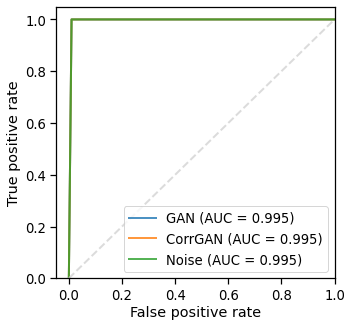

In [68]:
res_roc = {}
res_roc['GAN'] = ma.RF_ROC_cv(predictions, GAN_lbls, 'vinifera', n_fold=5, n_trees=200, n_iter=50)
res_roc['CorrGAN'] = ma.RF_ROC_cv(corr_preds, corr_lbls2, 'vinifera', n_fold=5, n_trees=200, n_iter=50)
res_roc['Noise'] = ma.RF_ROC_cv(int_noise_df, int_noise_lbls, 'vinifera', n_fold=5, n_trees=200, n_iter=50)

with sns.plotting_context("notebook", font_scale=1.2):
    f, ax = plt.subplots(1, 1, figsize=(5,5))
    for name, res in res_roc.items():
        mean_fpr = res['average fpr']
        mean_tpr = res['average tpr']
        mean_auc = res['mean AUC']
        ax.plot(mean_fpr, mean_tpr,
               label=f'{name} (AUC = {mean_auc:.3f})',
               lw=2, alpha=0.8)

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='lightgrey', alpha=.8)
    ax.legend()
    ax.set_xlim(None,1)
    ax.set_ylim(0,None)
    ax.set(xlabel='False positive rate', ylabel='True positive rate', title='')
          # title="Random forest ROC curves for Vitis types data set")
    plt.show()

**PLS-DA Tests**

In [69]:
from sklearn.cross_decomposition import PLSRegression
def fit_PLSDA_model(data, labels, unique_labels, n_comp=10, scale=False, encode2as1vector=True):
    "Fit a PLSRegression model."
    
    # create label lists
    is1vector = (len(unique_labels) == 2) and encode2as1vector

    # Generate the response variable Y for PLSRegression
    target = ma._generate_y_PLSDA(labels, unique_labels, is1vector)

    plsda = PLSRegression(n_components=n_comp, scale=scale)
    # Fitting the model
    plsda.fit(X=data,Y=target)
    
    return plsda

In [70]:
def decision_rule(y_pred, y_true):
    "Decision rule for PLS-DA classification."
    # Decision rule chosen: sample belongs to group where it has max y_pred (closer to 1)
    # In case of 1,0 encoding for two groups, round to nearest integer to compare
    nright = 0
    rounded = np.round(y_pred)

    for p in range(len(y_pred)):
        if rounded[p] >= 1:
            pred = 1
        else:
            pred = 0
        if pred == y_true[p]:
            nright += 1  # Correct prediction


    # Calculate accuracy for this iteration
    accuracy = (nright / len(y_pred))
    return accuracy

Optimizing the model

In [71]:
%%capture --no-stdout
# Capture warnings on this cell

GAN_optim_pls = ma.optim_PLSDA_n_components(predictions, GAN_lbls, encode2as1vector=True, max_comp=10, n_fold=5).CVscores
corr_optim_pls = ma.optim_PLSDA_n_components(corr_preds, corr_lbls2, encode2as1vector=True, max_comp=10, n_fold=5).CVscores
noise_optim_pls = ma.optim_PLSDA_n_components(int_noise_df, int_noise_lbls,
                                              encode2as1vector=True, max_comp=10, n_fold=5).CVscores

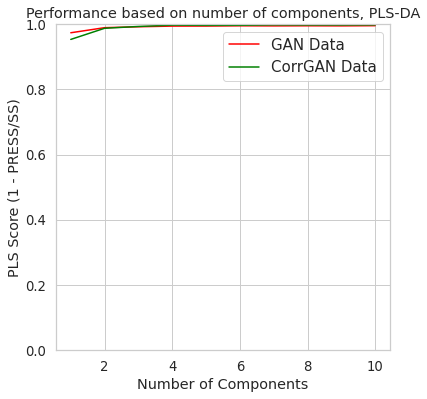

In [72]:
# Plotting the results and adjusting plot parameters
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        f, ax = plt.subplots(1, 1, figsize = (6,6))
        
        ax.plot(range(1, len(GAN_optim_pls) + 1), GAN_optim_pls, color='red', label='GAN Data')
        ax.plot(range(1, len(corr_optim_pls) + 1), corr_optim_pls, color='green', label='CorrGAN Data')
        ax.set(xlabel='Number of Components',
                ylabel='PLS Score (1 - PRESS/SS)',
                title='Performance based on number of components, PLS-DA')
        ax.set_ylim([0, 1])
        ax.legend(fontsize=15)

Fitting the model - GAN Data

In [73]:
%%capture --no-stdout
# Capture warnings on this cell

# Cross Validation Score
cv_plsda_model = ma.PLSDA_model_CV(predictions, GAN_lbls, n_comp=4,
                   n_fold=5, iter_num=20,
                   encode2as1vector=True, feat_type='Coef')

np.mean(cv_plsda_model['accuracy'])

In [74]:
plsda = ma.fit_PLSDA_model(predictions, GAN_lbls, n_comp=4, return_scores=False,
                    scale=False, encode2as1vector=True)

# Obtain results with the linearly generated data
y_pred = plsda.predict(t_data)
test_labels = ma._generate_y_PLSDA(t_labels, pd.unique(GAN_lbls), True)
# Calculate accuracy based on the decision rule
accuracy = decision_rule(y_pred, test_labels)
print('Classifier from GAN Generated Data Performance in predicting other samples:')
print('Predicting Linearly Generated Data', accuracy*100, '%.')

# Obtain results with the linearly generated data
y_pred = plsda.predict(r_data)

test_labels = ma._generate_y_PLSDA(r_labels, pd.unique(GAN_lbls), True)
# Calculate accuracy based on the decision rule
accuracy = decision_rule(y_pred, test_labels)
print('Predicting Experimental Data', accuracy*100, '%.')

Classifier from GAN Generated Data Performance in predicting other samples:
Predicting Linearly Generated Data 100.0 %.
Predicting Experimental Data 100.0 %.


Fitting the model - CorrGAN Data

In [75]:
#%%capture --no-stdout
# Capture warnings on this cell

#cv_plsda_model = ma.PLSDA_model_CV(corr_preds, corr_lbls2, n_comp=4,
#                   n_fold=5, iter_num=20,
#                   encode2as1vector=True, feat_type='Coef')

#np.mean(cv_plsda_model['accuracy'])

In [76]:
plsda = ma.fit_PLSDA_model(corr_preds, corr_lbls2, n_comp=4, return_scores=False,
                    scale=False, encode2as1vector=True)

# Obtain results with the linearly generated data
y_pred = plsda.predict(t_data)

test_labels = ma._generate_y_PLSDA(t_labels, pd.unique(corr_lbls2), True)

# Calculate accuracy based on the decision rule
accuracy = decision_rule(y_pred, test_labels)
print('Classifier from GAN Generated Data Performance in predicting other samples:')
print('Predicting Linearly Generated Data', accuracy*100, '%.')

# Obtain results with the linearly generated data
y_pred = plsda.predict(r_data)

test_labels = ma._generate_y_PLSDA(r_labels, pd.unique(corr_lbls2), True)

# Calculate accuracy based on the decision rule
accuracy = decision_rule(y_pred, test_labels)
print('Predicting Experimental Data', accuracy*100, '%.')

Classifier from GAN Generated Data Performance in predicting other samples:
Predicting Linearly Generated Data 100.0 %.
Predicting Experimental Data 100.0 %.


Fitting the model - Noise Data

In [77]:
#%%capture --no-stdout
# Capture warnings on this cell

# Cross Validation Score
#cv_plsda_model = ma.PLSDA_model_CV(int_noise_df, int_noise_lbls, n_comp=4,
#                   n_fold=5, iter_num=20,
#                   encode2as1vector=True, feat_type='Coef')

#np.mean(cv_plsda_model['accuracy'])

In [78]:
# Classifier Accuracy 
plsda = ma.fit_PLSDA_model(int_noise_df, int_noise_lbls,
                           n_comp=4, return_scores=False,
                    scale=False, encode2as1vector=True)

# Obtain results with the linearly generated data
y_pred = plsda.predict(t_data)

test_labels = ma._generate_y_PLSDA(t_labels, pd.unique(int_noise_lbls), True)

# Calculate accuracy based on the decision rule
accuracy = decision_rule(y_pred, test_labels)
print('Classifier from GAN Generated Data Performance in predicting other samples:')
print('Predicting Linearly Generated Data', accuracy*100, '%.')

# Obtain results with the linearly generated data
y_pred = plsda.predict(r_data)

test_labels = ma._generate_y_PLSDA(r_labels, pd.unique(int_noise_lbls), True)

# Calculate accuracy based on the decision rule
accuracy = decision_rule(y_pred, test_labels)
print('Predicting Experimental Data', accuracy*100, '%.')

Classifier from GAN Generated Data Performance in predicting other samples:
Predicting Linearly Generated Data 100.0 %.
Predicting Experimental Data 100.0 %.


PLS-DA projections

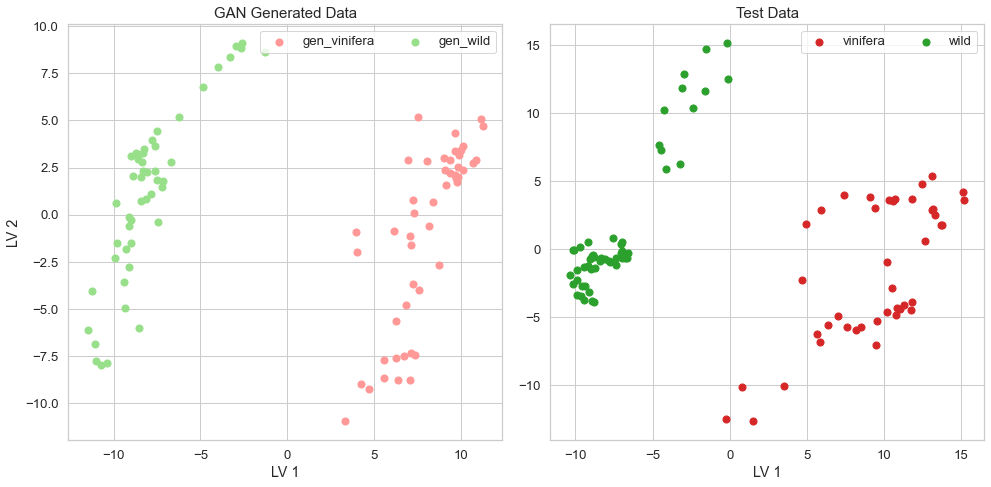

In [79]:
GAN_data = saved_predictions[-1]
GAN_lbls = ['vinifera']*48 + ['wild']*48gGA
#GAN_lbls

n_components = 4

GAN_labels_2 = ['gen_vinifera']*(len(GAN_data)//2) + ['gen_wild']*(len(GAN_data)//2)
#t_labels_2 = ['vinifera' for i in true_labels[-3*batch_size:] if i==0 else 'wild']


model, scores = ma.fit_PLSDA_model(GAN_data, GAN_labels_2, n_comp=n_components)
model2, scores2 = ma.fit_PLSDA_model(t_data, t_labels, n_comp=n_components)

#ordered_labels_test = ('wild','gen_wild','vinifera','gen_vinifera')
lcolors = label_colors_test

with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        fig, (axl, axr) = plt.subplots(1,2, figsize=(14,7))
        gem.plot_PLS(scores, lcolors, title="GAN Generated Data", ax=axl)
        #plt.legend(loc='upper left', ncol=2)

        gem.plot_PLS(scores2, lcolors, title="Test Data", ax=axr)
        axr.set_ylabel('')
        axr.legend(loc='upper right', ncol=2)
        axl.legend(loc='upper right', ncol=2)
        plt.tight_layout()
        plt.show()

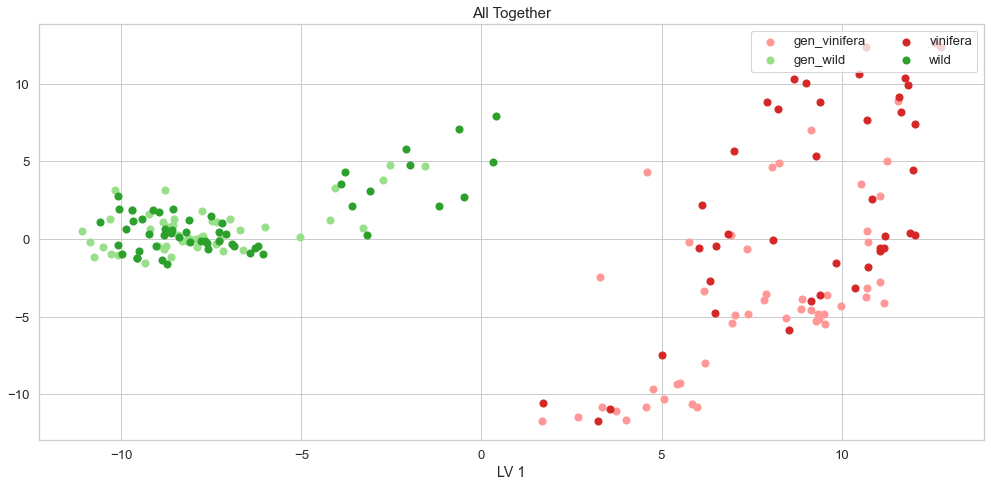

In [80]:
n_components = 4

df_temp = pd.concat([GAN_data, t_data])
labels_temp = GAN_labels_2 + list(t_labels)

model, scores = ma.fit_PLSDA_model(df_temp, labels_temp, n_comp=n_components)

#ordered_labels_test = ('wild','gen_wild','vinifera','gen_vinifera')
lcolors = label_colors_test

with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        fig, ax = plt.subplots(1,1, figsize=(14,7))
        gem.plot_PLS(scores, lcolors, title="All Together", ax=ax)

        ax.set_ylabel('')
        ax.legend(loc='upper right', ncol=2)               
        plt.tight_layout()
        plt.show()

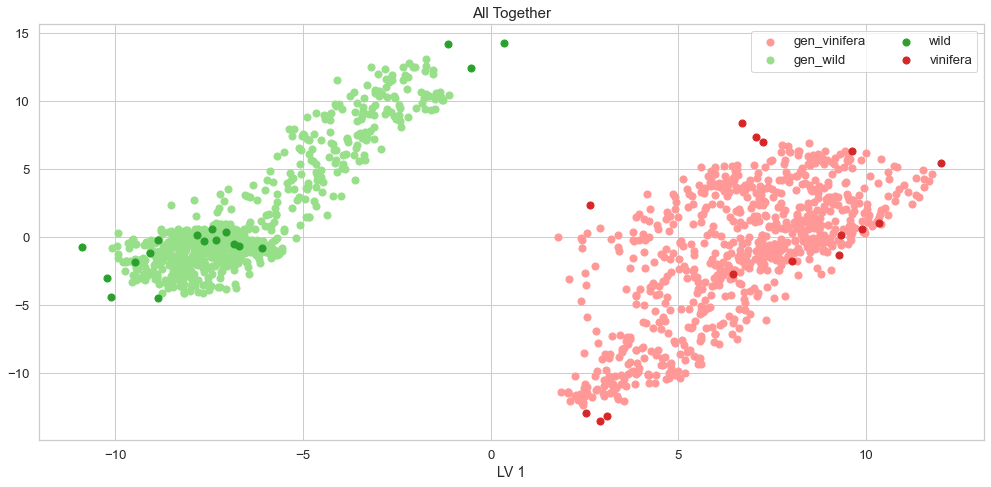

In [81]:
n_components = 4

#int_noise_df.columns = [float(i) for i in int_noise_df.columns]
df_temp = pd.concat([int_noise_df, r_data])
labels_temp = ['gen_' + i for i in int_noise_lbls] + r_labels

model, scores = ma.fit_PLSDA_model(df_temp, labels_temp, n_comp=n_components)

#ordered_labels_test = ('wild','gen_wild','vinifera','gen_vinifera')
lcolors = label_colors_test

with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        fig, ax = plt.subplots(1,1, figsize=(14,7))
        gem.plot_PLS(scores, lcolors, title="All Together", ax=ax)

        ax.set_ylabel('')
        ax.legend(loc='upper right', ncol=2)               
        plt.tight_layout()
        plt.show()

In [82]:
# Reference feature is indeed present in every single sample of the GAN data
predictions.loc[:,'554.26202'].sum()

512

Deep Learning methodology

In [83]:
def deep_classifier(len_input):
    
    classifier = tf.keras.Sequential([
        tf.keras.layers.Dense(256, activation=tf.nn.leaky_relu, use_bias=True, input_shape=(len_input,)),
        tf.keras.layers.Dense(512, activation=tf.nn.leaky_relu, use_bias=True),
        tf.keras.layers.Dense(128, activation=tf.nn.leaky_relu, use_bias=True),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(2, activation='softmax', use_bias=True)])
    
    classifier.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return classifier

Fitting the model - GAN Data

In [85]:
GAN_lbls = ['vinifera']*(len(predictions)//2) + ['wild']*(len(predictions)//2)

deep_class = deep_classifier(len(last_preds.columns))
model = deep_class.fit(last_preds, pd.get_dummies(GAN_lbls)[['vinifera', 'wild']], 
                       epochs = 100, batch_size=32,
                       validation_data=(r_data, pd.get_dummies(r_labels)[['vinifera', 'wild']]))

accuracy_t = deep_class.evaluate(t_data, pd.get_dummies(t_labels)[['vinifera', 'wild']])
accuracy_r = deep_class.evaluate(r_data, pd.get_dummies(r_labels)[['vinifera', 'wild']])

Epoch 1/100
16/16 [==============================] - 1s 36ms/step - loss: 0.0608 - accuracy: 0.9688 - val_loss: 3.3068e-04 - val_accuracy: 1.0000
Epoch 2/100
16/16 [==============================] - 0s 21ms/step - loss: 7.4979e-05 - accuracy: 1.0000 - val_loss: 7.3429e-05 - val_accuracy: 1.0000
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 6.1230e-05 - accuracy: 1.0000 - val_loss: 5.1721e-05 - val_accuracy: 1.0000
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 1.3697e-04 - accuracy: 1.0000 - val_loss: 5.9001e-05 - val_accuracy: 1.0000
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 1.7205e-04 - accuracy: 1.0000 - val_loss: 1.8306e-04 - val_accuracy: 1.0000
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 5.4203e-05 - accuracy: 1.0000 - val_loss: 8.1132e-05 - val_accuracy: 1.0000
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 2.6284e-05 - accuracy: 1.0000 - val

16/16 [==============================] - 0s 8ms/step - loss: 1.8942e-05 - accuracy: 1.0000 - val_loss: 3.9014e-07 - val_accuracy: 1.0000
Epoch 56/100
16/16 [==============================] - 0s 7ms/step - loss: 3.7710e-06 - accuracy: 1.0000 - val_loss: 4.0459e-07 - val_accuracy: 1.0000
Epoch 57/100
16/16 [==============================] - 0s 5ms/step - loss: 9.8723e-06 - accuracy: 1.0000 - val_loss: 3.7208e-07 - val_accuracy: 1.0000
Epoch 58/100
16/16 [==============================] - 0s 5ms/step - loss: 1.7758e-06 - accuracy: 1.0000 - val_loss: 3.6124e-07 - val_accuracy: 1.0000
Epoch 59/100
16/16 [==============================] - 0s 7ms/step - loss: 1.5392e-06 - accuracy: 1.0000 - val_loss: 3.7930e-07 - val_accuracy: 1.0000
Epoch 60/100
16/16 [==============================] - 0s 7ms/step - loss: 4.2233e-06 - accuracy: 1.0000 - val_loss: 3.8291e-07 - val_accuracy: 1.0000
Epoch 61/100
16/16 [==============================] - 0s 6ms/step - loss: 7.8965e-06 - accuracy: 1.0000 - val_los

In [86]:
print('Classifier from Noise Induced and Imputed Generated Data Performance in predicting other samples:')
print('Predicting Linearly Generated Data', accuracy_t[1]*100, '%.')
print('Predicting Experimental Data', accuracy_r[1]*100, '%.')

Classifier from Noise Induced and Imputed Generated Data Performance in predicting other samples:
Predicting Linearly Generated Data 100.0 %.
Predicting Experimental Data 100.0 %.


Fitting the model - CorrGAN Data

In [87]:
deep_class = deep_classifier(len(corr_preds.columns))
model = deep_class.fit(corr_preds, pd.get_dummies(corr_lbls2)[['vinifera', 'wild']], 
                       epochs = 100, batch_size=32,
                       validation_data=(r_data, pd.get_dummies(r_labels)[['vinifera', 'wild']]))

accuracy_t = deep_class.evaluate(t_data, pd.get_dummies(t_labels)[['vinifera', 'wild']])
accuracy_r = deep_class.evaluate(r_data, pd.get_dummies(r_labels)[['vinifera', 'wild']])

Epoch 1/100
6/6 [==============================] - 1s 34ms/step - loss: 0.2390 - accuracy: 0.9030 - val_loss: 0.0228 - val_accuracy: 1.0000
Epoch 2/100
6/6 [==============================] - 0s 13ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 3/100
6/6 [==============================] - 0s 13ms/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 0.0022 - val_accuracy: 1.0000
Epoch 4/100
6/6 [==============================] - 0s 13ms/step - loss: 0.0050 - accuracy: 1.0000 - val_loss: 4.3564e-04 - val_accuracy: 1.0000
Epoch 5/100
6/6 [==============================] - 0s 12ms/step - loss: 1.9584e-04 - accuracy: 1.0000 - val_loss: 1.9849e-04 - val_accuracy: 1.0000
Epoch 6/100
6/6 [==============================] - 0s 13ms/step - loss: 3.6061e-04 - accuracy: 1.0000 - val_loss: 1.5648e-04 - val_accuracy: 1.0000
Epoch 7/100
6/6 [==============================] - 0s 13ms/step - loss: 1.9534e-04 - accuracy: 1.0000 - val_loss: 1.3982e-04 - val_accuracy:

6/6 [==============================] - 0s 29ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.0036 - val_accuracy: 1.0000
Epoch 58/100
6/6 [==============================] - 0s 43ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0024 - val_accuracy: 1.0000
Epoch 59/100
6/6 [==============================] - 0s 43ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.0017 - val_accuracy: 1.0000
Epoch 60/100
6/6 [==============================] - 0s 37ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 61/100
6/6 [==============================] - 0s 44ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 8.5887e-04 - val_accuracy: 1.0000
Epoch 62/100
6/6 [==============================] - 0s 44ms/step - loss: 5.8921e-04 - accuracy: 1.0000 - val_loss: 6.6328e-04 - val_accuracy: 1.0000
Epoch 63/100
6/6 [==============================] - 0s 43ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 4.9081e-04 - val_accuracy: 1.0000
Epoch 64/1

In [88]:
print('Classifier from Noise Induced and Imputed Generated Data Performance in predicting other samples:')
print('Predicting Linearly Generated Data', accuracy_t[1]*100, '%.')
print('Predicting Experimental Data', accuracy_r[1]*100, '%.')

Classifier from Noise Induced and Imputed Generated Data Performance in predicting other samples:
Predicting Linearly Generated Data 100.0 %.
Predicting Experimental Data 100.0 %.


Fitting the model - Noise Data

In [89]:
deep_class = deep_classifier(len(int_noise_df.columns))
model = deep_class.fit(int_noise_df, pd.get_dummies(int_noise_lbls)[['vinifera', 'wild']], 
                       epochs = 100, batch_size=32,
                       validation_data=(r_data, pd.get_dummies(r_labels)[['vinifera', 'wild']]))

accuracy_t = deep_class.evaluate(t_data, pd.get_dummies(t_labels)[['vinifera', 'wild']])
accuracy_r = deep_class.evaluate(r_data, pd.get_dummies(r_labels)[['vinifera', 'wild']])

Epoch 1/100
48/48 [==============================] - 1s 10ms/step - loss: 0.0367 - accuracy: 0.9831 - val_loss: 2.1690e-04 - val_accuracy: 1.0000
Epoch 2/100
48/48 [==============================] - 0s 8ms/step - loss: 1.3955e-04 - accuracy: 1.0000 - val_loss: 1.9795e-05 - val_accuracy: 1.0000
Epoch 3/100
48/48 [==============================] - 0s 4ms/step - loss: 3.0032e-05 - accuracy: 1.0000 - val_loss: 1.0901e-05 - val_accuracy: 1.0000
Epoch 4/100
48/48 [==============================] - 0s 4ms/step - loss: 1.0314e-05 - accuracy: 1.0000 - val_loss: 6.1625e-06 - val_accuracy: 1.0000
Epoch 5/100
48/48 [==============================] - 0s 4ms/step - loss: 4.9261e-05 - accuracy: 1.0000 - val_loss: 3.3667e-06 - val_accuracy: 1.0000
Epoch 6/100
48/48 [==============================] - 0s 4ms/step - loss: 2.3959e-05 - accuracy: 1.0000 - val_loss: 2.8356e-06 - val_accuracy: 1.0000
Epoch 7/100
48/48 [==============================] - 0s 4ms/step - loss: 6.8396e-06 - accuracy: 1.0000 - val_

Epoch 56/100
48/48 [==============================] - 0s 4ms/step - loss: 4.0458e-07 - accuracy: 1.0000 - val_loss: 3.6124e-09 - val_accuracy: 1.0000
Epoch 57/100
48/48 [==============================] - 0s 4ms/step - loss: 1.1793e-06 - accuracy: 1.0000 - val_loss: 7.2248e-09 - val_accuracy: 1.0000
Epoch 58/100
48/48 [==============================] - 0s 4ms/step - loss: 1.0945e-06 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 59/100
48/48 [==============================] - 0s 4ms/step - loss: 5.8789e-07 - accuracy: 1.0000 - val_loss: 3.6124e-09 - val_accuracy: 1.0000
Epoch 60/100
48/48 [==============================] - 0s 4ms/step - loss: 2.4738e-06 - accuracy: 1.0000 - val_loss: 3.6124e-09 - val_accuracy: 1.0000
Epoch 61/100
48/48 [==============================] - 0s 4ms/step - loss: 1.6451e-06 - accuracy: 1.0000 - val_loss: 3.6124e-09 - val_accuracy: 1.0000
Epoch 62/100
48/48 [==============================] - 0s 4ms/step - loss: 1.1469e-06 - accuracy: 1.0

In [90]:
print('Classifier from Noise Induced and Imputed Generated Data Performance in predicting other samples:')
print('Predicting Linearly Generated Data', accuracy_t[1]*100, '%.')
print('Predicting Experimental Data', accuracy_r[1]*100, '%.')

Classifier from Noise Induced and Imputed Generated Data Performance in predicting other samples:
Predicting Linearly Generated Data 100.0 %.
Predicting Experimental Data 100.0 %.


### Comparing Important Features

See models built with the a lot of GAN generated data and the real data and compare the important features selected by both (values and identities).

In [91]:
num_examples_to_generate = 2048
test_input = tf.constant(input_realdata_dist.rvs(size=len(data_bin.columns)*num_examples_to_generate),
                         shape=[num_examples_to_generate,len(data_bin.columns)])
test_labels = tf.constant([1]*(num_examples_to_generate//2) + [0]*(num_examples_to_generate//2), shape=[
        num_examples_to_generate,1])
predictions = generator([test_input, test_labels], training=False)
predictions = tf.argmax(predictions, predictions.get_shape().ndims-1)
predictions = pd.DataFrame(predictions.numpy(), columns=datasets['vitis_types']['BinSim'].columns)
predictions

,97.2482,97.5887,97.588885,97.590015,97.5902,97.59094999999999,97.59188,97.72991999999999,98.153385,98.195875,...,966.00612,966.0547300000001,966.0576149999999,966.0663999999999,966.138205,966.140155,966.14212,966.1445,966.245005,977.114775
0,0,0,1,0,1,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,1,0,1,0,1,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,1,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,1,0,1,1,0,1,0,0,0,...,0,0,0,0,1,0,1,0,0,0
4,0,1,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2043,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2044,0,0,1,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2045,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2046,0,0,1,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### RF

Feature Importance judged by Gini Importance

In [92]:
# Fit RF models
np.random.seed(137532)
RF_model_GANdata = ma.RF_model(predictions, test_labels.numpy().flatten(), return_cv=False, n_trees=200)
RF_model_REALdata = ma.RF_model(datasets['vitis_types']['BinSim'], datasets['vitis_types']['target'], return_cv=False,
                                n_trees=200)
RF_model_CORRdata = ma.RF_model(corr_preds, corr_lbls2, return_cv=False, n_trees=200)
RF_model_NOISEdata = ma.RF_model(int_noise_df, int_noise_lbls, return_cv=False, n_trees=200)

In [93]:
# Extract and order important features
rf_GAN_feats = zip(range(1, len(datasets['vitis_types']['BinSim'].columns)+1), RF_model_GANdata.feature_importances_)
rf_real_feats = zip(range(1, len(datasets['vitis_types']['BinSim'].columns)+1), RF_model_REALdata.feature_importances_)
rf_corr_feats = zip(range(1, len(datasets['vitis_types']['BinSim'].columns)+1), RF_model_CORRdata.feature_importances_)
rf_noise_feats = zip(range(1, len(datasets['vitis_types']['BinSim'].columns)+1), RF_model_NOISEdata.feature_importances_)

rf_GAN_df = pd.DataFrame(rf_GAN_feats)
rf_real_df = pd.DataFrame(rf_real_feats)
rf_corr_df = pd.DataFrame(rf_corr_feats)
rf_noise_df = pd.DataFrame(rf_noise_feats)

In [94]:
# Sorting from most to least important feature
sorted_GAN_feats = rf_GAN_df.set_index(0).sort_values(by=1, ascending=False)
sorted_GAN_feats

,1
0,
1990,0.021186
1929,0.019765
1641,0.019414
1162,0.019026
1189,0.016554
...,...
1381,0.000000
1382,0.000000
1383,0.000000


In [95]:
# Sorting from most to least important feature
sorted_real_feats = rf_real_df.set_index(0).sort_values(by=1, ascending=False)
sorted_corr_feats = rf_corr_df.set_index(0).sort_values(by=1, ascending=False)
sorted_noise_feats = rf_noise_df.set_index(0).sort_values(by=1, ascending=False)
sorted_real_feats

,1
0,
1736,0.015825
1147,0.011260
1733,0.010705
1008,0.010326
2135,0.009581
...,...
1323,0.000000
1324,0.000000
1325,0.000000


In [96]:
# See intersections between important features of models generated with GAN or Experimental Data
intersections = []
for i in range(1, len(sorted_GAN_feats)):
    intersections.append(len(np.intersect1d(sorted_GAN_feats.index[:i], sorted_real_feats.index[:i])))

# See intersections between important features of models generated with CorrGAN or Experimental Data
intersections_corr= []
for i in range(1, len(sorted_corr_feats)):
    intersections_corr.append(len(np.intersect1d(sorted_corr_feats.index[:i], sorted_real_feats.index[:i])))
    
# See intersections between important features of models generated with Noise Induced or Experimental Data
intersections_noise= []
for i in range(1, len(sorted_noise_feats)):
    intersections_noise.append(len(np.intersect1d(sorted_noise_feats.index[:i], sorted_real_feats.index[:i])))  

# See intersections if features were randomly shuffled
random_intersections = []
copy_shuffle = list(sorted_real_feats.index).copy()
np.random.shuffle(copy_shuffle)
for i in range(1, len(sorted_GAN_feats)):
    random_intersections.append(len(np.intersect1d(sorted_GAN_feats.index[:i], copy_shuffle[:i])))

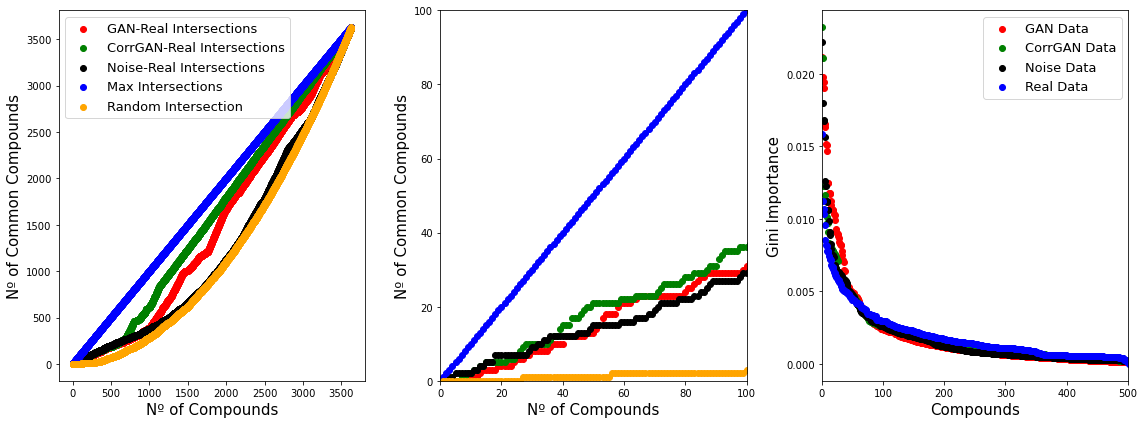

In [97]:
f, (axl, axc, axr) = plt.subplots(1,3,figsize=(16,6))
# Graph depicting intersection of important features
axl.scatter(range(1,len(sorted_GAN_feats)), intersections, label = 'GAN-Real Intersections', color='Red')
axl.scatter(range(1,len(sorted_GAN_feats)), intersections_corr, label = 'CorrGAN-Real Intersections', color='Green')
axl.scatter(range(1,len(sorted_GAN_feats)), intersections_noise, label = 'Noise-Real Intersections', color='Black')
axl.scatter(range(1,len(sorted_GAN_feats)), range(1,len(sorted_GAN_feats)), label = 'Max Intersections', color='Blue')
axl.scatter(range(1,len(sorted_GAN_feats)), random_intersections, label = 'Random Intersection', color='Orange')
axl.legend(loc='upper left', fontsize=13)
axl.set_xlabel('Nº of Compounds', fontsize=15)
axl.set_ylabel('Nº of Common Compounds', fontsize=15)

# Graph depicting intersection of important features with focus on the most important features
axc.scatter(range(1,len(sorted_GAN_feats)), intersections, label = 'GAN-Real Intersections', color='Red')
axc.scatter(range(1,len(sorted_GAN_feats)), intersections_corr, label = 'CorrGAN-Real Intersections', color='Green')
axc.scatter(range(1,len(sorted_GAN_feats)), intersections_noise, label = 'Noise-Real Intersections', color='Black')
axc.scatter(range(1,len(sorted_GAN_feats)), range(1,len(sorted_GAN_feats)), label = 'Max Intersections', color='Blue')
axc.scatter(range(1,len(sorted_GAN_feats)), random_intersections, label = 'Random Intersection', color='Orange')
axc.set_xlim([0,100])
axc.set_ylim([0,100])
axc.set_xlabel('Nº of Compounds', fontsize=15)
axc.set_ylabel('Nº of Common Compounds', fontsize=15)

# Values of Gini Importance for RF models from GAN and Real Data
axr.scatter(range(1,len(rf_GAN_df)+1), rf_GAN_df.set_index(0).sort_values(by=1, ascending=False), 
            color='red', label='GAN Data')
axr.scatter(range(1,len(rf_corr_df)+1), rf_corr_df.set_index(0).sort_values(by=1, ascending=False), 
            color='green', label='CorrGAN Data')
axr.scatter(range(1,len(rf_noise_df)+1), rf_noise_df.set_index(0).sort_values(by=1, ascending=False), 
            color='black', label='Noise Data')
axr.scatter(range(1,len(rf_real_df)+1), rf_real_df.set_index(0).sort_values(by=1, ascending=False), 
            color='blue', label='Real Data')
axr.set_xlim([0,500])
axr.legend(fontsize=13)
axr.set_xlabel('Compounds', fontsize=15)
axr.set_ylabel('Gini Importance', fontsize=15)

plt.tight_layout()
plt.show()

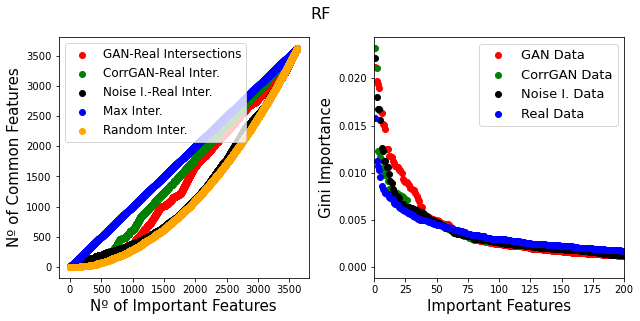

In [98]:
f, (axl, axr) = plt.subplots(1,2,figsize=(9,4.5))
# Graph depicting intersection of important features
axl.scatter(range(1,len(sorted_GAN_feats)), intersections, label = 'GAN-Real Intersections', color='Red')
axl.scatter(range(1,len(sorted_GAN_feats)), intersections_corr, label = 'CorrGAN-Real Inter.', color='Green')
axl.scatter(range(1,len(sorted_GAN_feats)), intersections_noise, label = 'Noise I.-Real Inter.', color='Black')
axl.scatter(range(1,len(sorted_GAN_feats)), range(1,len(sorted_GAN_feats)), label = 'Max Inter.', color='Blue')
axl.scatter(range(1,len(sorted_GAN_feats)), random_intersections, label = 'Random Inter.', color='Orange')
axl.legend(loc='upper left', fontsize=12)
axl.set_xlabel('Nº of Important Features', fontsize=15)
axl.set_ylabel('Nº of Common Features', fontsize=15)

# Values of Gini Importance for RF models from GAN and Real Data
axr.scatter(range(1,len(rf_GAN_df)+1), rf_GAN_df.set_index(0).sort_values(by=1, ascending=False), 
            color='red', label='GAN Data')
axr.scatter(range(1,len(rf_corr_df)+1), rf_corr_df.set_index(0).sort_values(by=1, ascending=False), 
            color='green', label='CorrGAN Data')
axr.scatter(range(1,len(rf_noise_df)+1), rf_noise_df.set_index(0).sort_values(by=1, ascending=False), 
            color='black', label='Noise I. Data')
axr.scatter(range(1,len(rf_real_df)+1), rf_real_df.set_index(0).sort_values(by=1, ascending=False), 
            color='blue', label='Real Data')
axr.set_xlim([0,200])
axr.legend(fontsize=13)
axr.set_xlabel('Important Features', fontsize=15)
axr.set_ylabel('Gini Importance', fontsize=15)

plt.suptitle('RF', fontsize=16)
plt.tight_layout()
plt.show()
f.savefig('images/GDbin_RFImpFeatPlot.png', dpi=300)

#### PLS-DA

Feature Importance judged by VIP (Variable Importance in Projection)

In [99]:
# Fit the PLS-DA model
np.random.seed(137532)
PLSDA_model_GANdata = ma.fit_PLSDA_model(predictions, test_labels.numpy().flatten(), n_comp=4, return_scores=False,
                    scale=False, encode2as1vector=True)
PLSDA_model_REALdata = ma.fit_PLSDA_model(datasets['vitis_types']['BinSim'], datasets['vitis_types']['target'], 
                                          n_comp=4, return_scores=False, scale=False, encode2as1vector=True)
PLSDA_model_CORRdata = ma.fit_PLSDA_model(corr_preds, corr_lbls2, 
                                          n_comp=4, return_scores=False, scale=False, encode2as1vector=True)
PLSDA_model_NOISEdata = ma.fit_PLSDA_model(int_noise_df, int_noise_lbls, 
                                          n_comp=4, return_scores=False, scale=False, encode2as1vector=True)

In [100]:
# Extract and order important features
plsda_GAN_feats = zip(range(1, len(datasets['vitis_types']['BinSim'].columns)+1), ma._calculate_vips(PLSDA_model_GANdata))
plsda_real_feats = zip(range(1, len(datasets['vitis_types']['BinSim'].columns)+1), ma._calculate_vips(PLSDA_model_REALdata))
plsda_corr_feats = zip(range(1, len(datasets['vitis_types']['BinSim'].columns)+1), ma._calculate_vips(PLSDA_model_CORRdata))
plsda_noise_feats = zip(range(1, len(datasets['vitis_types']['BinSim'].columns)+1), ma._calculate_vips(PLSDA_model_NOISEdata))

plsda_GAN_df = pd.DataFrame(plsda_GAN_feats)
plsda_real_df = pd.DataFrame(plsda_real_feats)
plsda_corr_df = pd.DataFrame(plsda_corr_feats)
plsda_noise_df = pd.DataFrame(plsda_noise_feats)

In [101]:
# Sorting from most to least important feature
sorted_GAN_feats = plsda_GAN_df.set_index(0).sort_values(by=1, ascending=False)
sorted_real_feats = plsda_real_df.set_index(0).sort_values(by=1, ascending=False)
sorted_corr_feats = plsda_corr_df.set_index(0).sort_values(by=1, ascending=False)
sorted_noise_feats = plsda_noise_df.set_index(0).sort_values(by=1, ascending=False)

In [102]:
# See intersections between important features of models generated with GAN or Experimental Data
intersections = []
for i in range(1, len(sorted_GAN_feats)):
    intersections.append(len(np.intersect1d(sorted_GAN_feats.index[:i], sorted_real_feats.index[:i])))

intersections_corr = []
for i in range(1, len(sorted_corr_feats)):
    intersections_corr.append(len(np.intersect1d(sorted_corr_feats.index[:i], sorted_real_feats.index[:i])))

# See intersections between important features of models generated with NoiseInduced or Experimental Data
intersections_noise= []
for i in range(1, len(sorted_noise_feats)):
    intersections_noise.append(len(np.intersect1d(sorted_noise_feats.index[:i], sorted_real_feats.index[:i]))) 

# See intersections if features were randomly shuffled  
random_intersections = []
copy_shuffle = list(sorted_real_feats.index).copy()
np.random.shuffle(copy_shuffle)
for i in range(1, len(sorted_GAN_feats)):
    random_intersections.append(len(np.intersect1d(sorted_GAN_feats.index[:i], copy_shuffle[:i])))

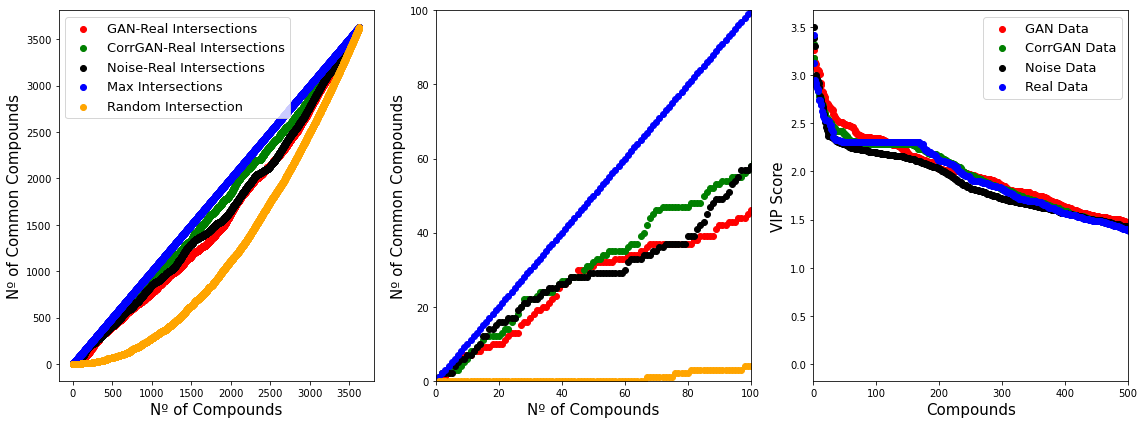

In [103]:
f, (axl, axc, axr) = plt.subplots(1,3,figsize=(16,6))
# Graph depicting intersection of important features
axl.scatter(range(1,len(sorted_GAN_feats)), intersections, label = 'GAN-Real Intersections', color='Red')
axl.scatter(range(1,len(sorted_GAN_feats)), intersections_corr, label = 'CorrGAN-Real Intersections', color='Green')
axl.scatter(range(1,len(sorted_GAN_feats)), intersections_noise, label = 'Noise-Real Intersections', color='Black')
axl.scatter(range(1,len(sorted_GAN_feats)), range(1,len(sorted_GAN_feats)), label = 'Max Intersections', color='Blue')
axl.scatter(range(1,len(sorted_GAN_feats)), random_intersections, label = 'Random Intersection', color='Orange')
axl.legend(loc='upper left', fontsize=13)
axl.set_xlabel('Nº of Compounds', fontsize=15)
axl.set_ylabel('Nº of Common Compounds', fontsize=15)

# Graph depicting intersection of important features with focus on the most important features
axc.scatter(range(1,len(sorted_GAN_feats)), intersections, label = 'GAN-Real Intersections', color='Red')
axc.scatter(range(1,len(sorted_GAN_feats)), intersections_corr, label = 'CorrGAN-Real Intersections', color='Green')
axc.scatter(range(1,len(sorted_GAN_feats)), intersections_noise, label = 'Noise-Real Intersections', color='Black')
axc.scatter(range(1,len(sorted_GAN_feats)), range(1,len(sorted_GAN_feats)), label = 'Max Intersections', color='Blue')
axc.scatter(range(1,len(sorted_GAN_feats)), random_intersections, label = 'Random Intersection', color='Orange')
axc.set_xlim([0,100])
axc.set_ylim([0,100])
axc.set_xlabel('Nº of Compounds', fontsize=15)
axc.set_ylabel('Nº of Common Compounds', fontsize=15)

# Values of VIP Score for PLS-DA models from GAN and Real Data
axr.scatter(range(1,len(plsda_GAN_df)+1), plsda_GAN_df.set_index(0).sort_values(by=1, ascending=False), 
            color='red', label='GAN Data')
axr.scatter(range(1,len(plsda_corr_df)+1), plsda_corr_df.set_index(0).sort_values(by=1, ascending=False), 
            color='green', label='CorrGAN Data')
axr.scatter(range(1,len(plsda_noise_df)+1), plsda_noise_df.set_index(0).sort_values(by=1, ascending=False), 
            color='black', label='Noise Data')
axr.scatter(range(1,len(plsda_real_df)+1), plsda_real_df.set_index(0).sort_values(by=1, ascending=False), 
            color='blue', label='Real Data')
axr.set_xlim([0,500])
axr.legend(fontsize=13)
axr.set_xlabel('Compounds', fontsize=15)
axr.set_ylabel('VIP Score', fontsize=15)

plt.tight_layout()
plt.show()

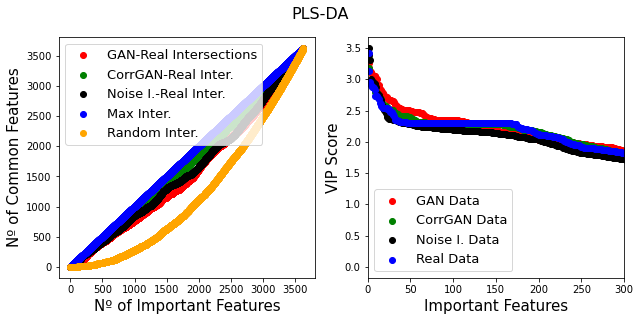

In [104]:
f, (axl, axr) = plt.subplots(1,2,figsize=(9,4.5))
# Graph depicting intersection of important features
axl.scatter(range(1,len(sorted_GAN_feats)), intersections, label = 'GAN-Real Intersections', color='Red')
axl.scatter(range(1,len(sorted_GAN_feats)), intersections_corr, label = 'CorrGAN-Real Inter.', color='Green')
axl.scatter(range(1,len(sorted_GAN_feats)), intersections_noise, label = 'Noise I.-Real Inter.', color='Black')
axl.scatter(range(1,len(sorted_GAN_feats)), range(1,len(sorted_GAN_feats)), label = 'Max Inter.', color='Blue')
axl.scatter(range(1,len(sorted_GAN_feats)), random_intersections, label = 'Random Inter.', color='Orange')
axl.legend(loc='upper left', fontsize=13)
axl.set_xlabel('Nº of Important Features', fontsize=15)
axl.set_ylabel('Nº of Common Features', fontsize=15)

# Values of VIP Score for PLS-DA models from GAN and Real Data
axr.scatter(range(1,len(plsda_GAN_df)+1), plsda_GAN_df.set_index(0).sort_values(by=1, ascending=False), 
            color='red', label='GAN Data')
axr.scatter(range(1,len(plsda_corr_df)+1), plsda_corr_df.set_index(0).sort_values(by=1, ascending=False), 
            color='green', label='CorrGAN Data')
axr.scatter(range(1,len(plsda_noise_df)+1), plsda_noise_df.set_index(0).sort_values(by=1, ascending=False), 
            color='black', label='Noise I. Data')
axr.scatter(range(1,len(plsda_real_df)+1), plsda_real_df.set_index(0).sort_values(by=1, ascending=False), 
            color='blue', label='Real Data')
axr.set_xlim([0,300])
axr.legend(fontsize=13)
axr.set_xlabel('Important Features', fontsize=15)
axr.set_ylabel('VIP Score', fontsize=15)

plt.suptitle('PLS-DA', fontsize=16)
plt.tight_layout()
plt.show()
f.savefig('images/GDbin_PLSDAImpFeatPlot.png', dpi=300)

### sMDiN analysis

Perform statistical analysis using sMDiNs as a starrting point for analysis.

In [105]:
import networkx as nx

In [106]:
# Read the MDiN built using Cytoscape's MetaNetter
MDiN_vitis = nx.read_graphml('mass_data/MassListGD_neg_global2.graphml')

# Making dicts for the new names
new_nodes = dict.fromkeys(MDiN_vitis.nodes(),0)

for i,mz in nx.get_node_attributes(MDiN_vitis,'mass').items(): # i is old name, mz is mass/new name
    new_nodes[i] = mz

# Relabeling nodes
MDiN_vitis = nx.relabel_nodes(MDiN_vitis, mapping=new_nodes)
MDiN_vitis = MDiN_vitis.to_undirected()
len(MDiN_vitis.nodes())

3629

In [107]:
# Removing all unconnected nodes
new_node_list = []
for node in MDiN_vitis.degree():
    if node[1] > 0:
        new_node_list.append(node[0])
MDiN_vitis = MDiN_vitis.subgraph(new_node_list)

In [108]:
# Atomic masses - https://ciaaw.org/atomic-masses.htm
#Isotopic abundances-https://ciaaw.org/isotopic-abundances.htm/https://www.degruyter.com/view/journals/pac/88/3/article-p293.xml
# Isotopic abundances from Pure Appl. Chem. 2016; 88(3): 293–306,
# Isotopic compositions of the elements 2013 (IUPAC Technical Report), doi: 10.1515/pac-2015-0503
chemdict = {'H':(1.0078250322, 0.999844)} 

# electron mass from NIST http://physics.nist.gov/cgi-bin/cuu/Value?meu|search_for=electron+mass
electron_mass = 0.000548579909065

In [109]:
def sMDiN_building(graph, dataset):
    "Builds sMDiNs for each sample of a dataset taking the dataset MDiN."
    # Building sMDiNs
    sMDiNs = {}
    for samp in dataset.index:
        # Subgraphing sMDiN while 'neutralizing' the peaks of the dataset as used to build the MDiNs
        idxs = [float(i) +  chemdict['H'][0] - electron_mass for i in dataset.T[
            dataset.loc[samp,:].replace({np.nan:0}) != 0].index]
        sMDiNs[samp] = graph.subgraph(idxs)
        
    return sMDiNs

In [110]:
def sMDiN_analysis(sMDiNs):
    "Performs Degree and MDBI analysis of a set of sMDiNs."
    # To store results
    sMDiN_results = {}
    Deg = {}
    MDB_Impact = {}

    for samp in sMDiNs:

        # Centrality measures
        Deg[samp] = dict(sMDiNs[samp].degree())

        # MDB Impact
        MDB_Impact[samp] = dict.fromkeys(MDBs, 0) # MDBs from the transformation list
        for i in sMDiNs[samp].edges():
            MDB_Impact[samp][sMDiNs[samp].edges()[i]['Transformation']] = MDB_Impact[samp][
                sMDiNs[samp].edges()[i]['Transformation']] + 1

    # Centrality Measures
    sMDiN_results['Degree'] = pd.DataFrame.from_dict(Deg, orient='index', columns=MDiN_vitis.nodes()).replace({np.nan:0})#.T
    #print(sMDiN_results['Degree'])
    sMDiN_results['Degree'] = sMDiN_results['Degree'].loc[sMDiNs.keys()]
    
    # MDB Impact
    MDBI = pd.DataFrame.from_dict(MDB_Impact).replace({np.nan:0})
    #ds['MDB_Imp'] = transf.pareto_scale(ds['MDB_Imp']).T.replace({np.nan:0})
    sMDiN_results['MDBI'] = (MDBI/MDBI.sum()).T
    
    return sMDiN_results

In [111]:
def WMDBI_calculation(degree_df, target, sMDiNs, test=False):
    "Performs WMDBI analysis of a set of sMDiNs."
    # Store results
    Weighted_MDB_Impact = {}
    
    # Build Random Forest model based on the degree analysis of the dataset
    degree_rf = ma.RF_model(degree_df, target, n_trees=100, return_cv=False)

    # Series with the importance of each node (ordered from most to least important)
    ordered_imp_feats = pd.Series(
        degree_rf.feature_importances_, index=degree_df.columns).sort_values(ascending=False)
    
    # If test, degree_df was the training set and then the importance absed on the training set is applied to the test set.
    # Thus, we need to change, after getting the importances, the degree_df from the training to the test set.
    if type(test) == pd.core.frame.DataFrame:
        degree_df = test

    # For each sample / sMDiN
    for samp in degree_df.index:

        # Weighted MDB Impact
        Weighted_MDB_Impact[samp] = dict.fromkeys(MDBs, 0) # MDBs from the transformation list
        for node in sMDiNs[samp].nodes(): # See each node
            for edge in sMDiNs[samp].edges(node): # And each edge associated with that node
                # See the corresponding MDB and add the importance of the node to the impact of that MDB
                Weighted_MDB_Impact[samp][sMDiNs[samp].edges()[edge]['Transformation']] += ordered_imp_feats.loc[node]

    # Weighted MDB Impact
    WMDBI = pd.DataFrame.from_dict(Weighted_MDB_Impact).replace({np.nan:0}).T
    
    return WMDBI

In [112]:
# Building the sMDiNs for real, linearly generated GAN, and Correlated GAN data
real_sMDiNs = sMDiN_building(MDiN_vitis, datasets['vitis_types']['data'])
lin_sMDiNs = sMDiN_building(MDiN_vitis, t_data)
GAN_sMDiNs = sMDiN_building(MDiN_vitis, pd.DataFrame(predictions.values, columns=datasets['vitis_types']['data'].columns,
                                                    index=predictions.index))
corr_sMDiNs = sMDiN_building(MDiN_vitis, corr_preds)
noise_sMDiNs = sMDiN_building(MDiN_vitis, int_noise_df)

In [113]:
# Chemical Formula transformations (MDBs chosen)
MDBs = ['H2','CH2','CO2','O','CHOH','NCH','O(N-H-)','S','CONH','PO3H','NH3(O-)','SO3','CO', 'C2H2O', 'H2O']
GAN_lbls = ['vinifera']*(len(predictions)//2) + ['wild']*(len(predictions)//2)

# Analysing the sMDiNs for real, linearly generated, GAN and Correlated GAN data
real_sMDiNs_res = sMDiN_analysis(real_sMDiNs)
lin_sMDiNs_res = sMDiN_analysis(lin_sMDiNs)
GAN_sMDiNs_res = sMDiN_analysis(GAN_sMDiNs)
corr_sMDiNs_res = sMDiN_analysis(corr_sMDiNs)
noise_sMDiNs_res = sMDiN_analysis(noise_sMDiNs)

# WMDBI Calculation
real_sMDiNs_res['WMDBI'] = WMDBI_calculation(real_sMDiNs_res['Degree'], datasets['vitis_types']['target'], real_sMDiNs)
lin_sMDiNs_res['WMDBI'] = WMDBI_calculation(lin_sMDiNs_res['Degree'], t_labels, lin_sMDiNs)
GAN_sMDiNs_res['WMDBI'] = WMDBI_calculation(GAN_sMDiNs_res['Degree'], GAN_lbls, GAN_sMDiNs)
corr_sMDiNs_res['WMDBI'] = WMDBI_calculation(corr_sMDiNs_res['Degree'], corr_lbls2, corr_sMDiNs)
noise_sMDiNs_res['WMDBI'] = WMDBI_calculation(noise_sMDiNs_res['Degree'], int_noise_lbls, noise_sMDiNs)

In [114]:
# Fit RF and PLS-DA models to GAN and Correlated GAN data and test their predictive accuracy in classifying real data
sMDiN_results = {}
sMDiN_results['RF'] = {}
sMDiN_results['PLSDA'] = {}

for t, l, name in zip([GAN_sMDiNs_res, corr_sMDiNs_res, noise_sMDiNs_res], [GAN_lbls, corr_lbls2, int_noise_lbls], 
                      ['gen', 'corr', 'noise']):
    
    sMDiN_results['RF'][name] = {}
    sMDiN_results['PLSDA'][name] = {}

    for n, metric in t.items():
        # For each metric and type of generated data, fit the models and test them with real data
        # RF
        #print(metric)
        rf_mod = ma.RF_model(metric, l, return_cv=False, n_trees=200)
        sMDiN_results['RF'][name][n] = rf_mod.score(real_sMDiNs_res[n], datasets['vitis_types']['target'])
        
        # PLS-DA
        # Build y_true
        y_true = []
        for j in datasets['vitis_types']['target']:
            if j == 'vinifera':
                y_true.append(1)
            else:
                y_true.append(0)
        unique_labels = ['vinifera', 'wild']

        # Fit model with GAN data and test model with real data
        plsda = fit_PLSDA_model(metric, l, unique_labels, n_comp=4,
                        scale=False, encode2as1vector=True)
        # Obtain results
        y_pred = plsda.predict(real_sMDiNs_res[n])
        # Calculate accuracy
        accuracy = decision_rule(y_pred, y_true)
        sMDiN_results['PLSDA'][name][n] = accuracy
    print(name)

gen
corr
noise


In [115]:
final_rf_results = pd.DataFrame.from_dict(sMDiN_results['RF'])
final_plsda_results = pd.DataFrame.from_dict(sMDiN_results['PLSDA'])

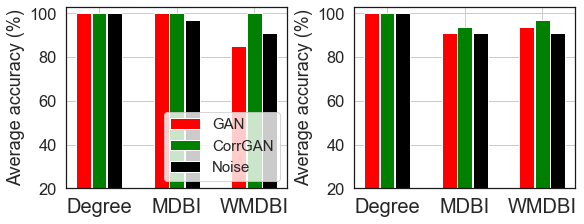

In [116]:
# Results
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.5):
        f, (axl, axr) = plt.subplots(1, 2, figsize=(8, 3), constrained_layout=True)
        x = np.arange(3)  # the label locations
        labels = ['Degree', 'MDBI', 'WMDBI']
        width = 0.19  # the width of the bars
        
        offset = - 0.2 + 0 * 0.2
        rects = axl.bar(x + offset, final_rf_results['gen'].values*100,
                        width, label='GAN', color='Red')                             
        offset = - 0.2 + 1 * 0.2
        rects = axl.bar(x + offset, final_rf_results['corr'].values*100,
                        width, label='CorrGAN', color='Green')
        offset = - 0.2 + 2 * 0.2
        rects = axl.bar(x + offset, final_rf_results['noise'].values*100,
                        width, label='Noise', color='Black') 
        
        axl.set_xticks(x)
        axl.set_xticklabels(labels, fontsize=20)
        axl.set(ylabel='Average accuracy (%)', title='', ylim=(20,103))
        for spine in axl.spines.values():
            spine.set_edgecolor('0.1')
        
        axl.legend(loc='lower right', fontsize=15)
        
        offset = - 0.2 + 0 * 0.2
        rects = axr.bar(x + offset, final_plsda_results['gen'].values*100,
                        width, label='GAN', color='Red')                             
        offset = - 0.2 + 1 * 0.2
        rects = axr.bar(x + offset, final_plsda_results['corr'].values*100,
                        width, label='CorrGAN', color='Green')
        offset = - 0.2 + 2 * 0.2
        rects = axr.bar(x + offset, final_plsda_results['noise'].values*100,
                        width, label='Noise', color='Black') 
        
        axr.set_xticks(x)
        axr.set_xticklabels(labels, fontsize=20)
        axr.set(ylabel='Average accuracy (%)', title='', ylim=(20,103))
        for spine in axr.spines.values():
            spine.set_edgecolor('0.1')
        plt.show()

### Cross Validation and variation on CAS

Variation on CAS Score, here we divided our dataset, getting 11 folds where each has 30 samples that act as the 'training set' and the remaining 3 samples as the 'test set'.

With the train set, we build  and train a GAN model from them. Then we build models with the train set and with generated artificial samples from the GAN models and compare the performance in discriminating the test set.

Note: They are put already treated since applying pre-treatment to only 3 samples can affect the results a lot.

In [117]:
from sklearn.model_selection import train_test_split, StratifiedKFold
kf = StratifiedKFold(11, shuffle=True, random_state=7519)

# Make the folds
folds_test = {}
folds_train = {}
a = 1

for train_index, test_index in kf.split(datasets['vitis_types']['BinSim'], datasets['vitis_types']['target']):
    #print(datasets['vitis_types']['BinSim'].iloc[train_index].copy())
    train_data = datasets['vitis_types']['BinSim'].iloc[train_index].copy()
    #grapevine_classes = train_data.index.get_level_values(0)
    train_lbls = list(np.array(datasets['vitis_types']['target'])[train_index])
    
    test_data = datasets['vitis_types']['BinSim'].iloc[test_index].copy()
    test_lbls = np.array(datasets['vitis_types']['target'])[test_index]
    
    folds_test[a] = [test_data, test_lbls]
    folds_train[a] = [train_data, train_lbls]
    
    a+=1

In [118]:
# Generate linearly generated samples for each fold
arti_train = {}
for i in folds_train:
    start = perf_counter()
    data, lbls = laf.artificial_dataset_generator(folds_train[i][0], labels=folds_train[i][1],
                                            max_new_samples_per_label=256, binary='random sampling', 
                                            rnd=list(np.linspace(0.1,0.9,9)), 
                                            binary_rnd_state=None, rnd_state=4174)
    arti_train[i] = [data, lbls]
    end = perf_counter()
    print(f'Simple augmentation of train data fold {i} done! took {(end - start):.3f} s')    

Simple augmentation of train data fold 1 done! took 74.367 s
Simple augmentation of train data fold 2 done! took 72.588 s
Simple augmentation of train data fold 3 done! took 71.762 s
Simple augmentation of train data fold 4 done! took 72.598 s
Simple augmentation of train data fold 5 done! took 75.188 s
Simple augmentation of train data fold 6 done! took 74.073 s
Simple augmentation of train data fold 7 done! took 83.496 s
Simple augmentation of train data fold 8 done! took 86.177 s
Simple augmentation of train data fold 9 done! took 74.793 s
Simple augmentation of train data fold 10 done! took 74.333 s
Simple augmentation of train data fold 11 done! took 76.725 s


**Training the GAN models**

In [119]:
def training_montage(data, lbls, epochs, generator, critic, generator_optimizer, critic_optimizer, input_dist,
                    batch_size, grad_pen_weight=10, k_cov_den=50, k_crossLID=15):
    """Train a generator and critic of CWGAN-GP-Binary.
    
       Receives data and respective class labels data and lbls), divides it into training and test  data and trains a generator
    and a discriminatoc model (generator, discriminator) over a number of epochs (epochs) with a set batch size (batch_size)
    with the respective optimizers and learning rate (generator_optimizer, discriminator_optimizer). Gradient Penalty is
    calculated with grad_pen_weight as the weight of the penalty.
       The functions returns at time intervals three graphs to evaluate the progression of the models (Loss plots, coverage,
    density, crossLID and correct first cluster plots and PCA plot with generated and test data). To this end, samples need
    to be generated requiring the distribution to sample the initial input values from (input_dist). Finally the number of
    neighbors to consider for coverage/density and crossLID calculation is also needed (k_cov_den, k_crossLID).
    
       data: Pandas DataFrame with data;
       lbls: List with data class labels;
       epochs: Int value with the number of epochs to train the model;
       generator: tensorflow keras.engine.functional.Functional model for the generator;
       discriminator: tensorflow keras.engine.functional.Functional model for the discriminator;
       generator_optimizer: tensorflow keras optimizer (with learning rate) for generator;
       discriminator_optimizer: tensorflow keras optimizer (with learning rate) for discriminator;
       input_dist: scipy.stats._continuous_distns.rv_histogram object - distribution to sample input values for generator;
       batch_size: int value with size of batch for model training;
       grad_pen_weight: int value (default 10) for penalty weight in gradient penalty calculation;
       k_cov_den: int value (default 50) for number of neighbors to consider for coverage and density calculation in generated
    samples evaluation;
       k_crossLID: int value (default 15) for number of neighbors to consider for crossLID calculation in generated samples
    evaluation.
    """
    
    # Obtaining the train and test data from all_data, randomizing its order
    all_data = data.iloc[np.random.RandomState(seed=145).permutation(len(data))]
    
    # Divide data into training and test data
    test_data = all_data.values
    training_data = all_data
    train_data = all_data.values
    
    # Change class labels to numerical values while following the randomized ordered of samples
    if len(set(lbls)) < 3: # 1 and 0 for when there are only two classes
        true_labels = pd.get_dummies(
            np.array(lbls)[np.random.RandomState(seed=145).permutation(len(lbls))]).values[:,0]
    else: # One hot encoding for when there are more than two classes
        true_labels = pd.get_dummies(
            np.array(lbls)[np.random.RandomState(seed=145).permutation(len(lbls))]).values
    # Save the order of the labels
    ordered_labels = pd.get_dummies(
            np.array(lbls)[np.random.RandomState(seed=145).permutation(len(lbls))]).columns

    test_labels = true_labels
    train_labels = true_labels#, shape=(len(all_data-3*batch_size,1))

    # To save the model after
    checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                     critic_optimizer=critic_optimizer,
                                     generator=generator,
                                     critic=critic)

    half_batch = int(batch_size / 2) 
    batch_divisions = int(batch_size / len(set(lbls))) # See how many samples of each class will be in each batch
    n_steps = epochs * int(training_data.shape[0] / batch_size)
    n_critic = 5
    
    # Set up the evaluating images printed during training and the intervals they will be updated
    f, (axl, axc, axr) = plt.subplots(1, 3, figsize = (16,5))
    update1 = n_steps//200
    update2 = n_steps//20

    if hasattr(tqdm, '_instances'):
        tqdm._instances.clear() # clear if it exists
        
    i=0

    for step in tqdm(range(n_steps)):
        
        # Critic Training
        crit_loss_temp = []
        
        # Select real samples for this batch on training and order samples to put samples of the same class together
        real_samp = train_data[i*batch_size:(i+1)*batch_size]
        real_lbls = train_labels[i*batch_size:(i+1)*batch_size]

        real_samp_2 = np.empty(real_samp.shape)
        real_labels = np.empty(real_lbls.shape)
        a = 0
        for l,s in sorted(zip(real_lbls, real_samp), key=lambda pair: pair[0], reverse=True):
            real_samp_2[a] = s
            real_labels[a] = l
            a = a+1
        
        #ones = np.count_nonzero(real_labels == 1)
        #zeros = np.count_nonzero(real_labels == 0)
        
        # Transform real samples to have for each feature two values (probability of the value being 0 or 1) to give as an
        # acceptable input to the critic. In this case the probability of being 0 or 1, since the values are already set are
        # 100% (1) or 0% (0)
        real_samples = tf.one_hot(tf.cast(real_samp_2, 'int32'), 2)
            
        for _ in range(n_critic):  # For each step, train critic n_critic times
            
            # Generate artificial samples as input for generator
            artificial_samples = tf.constant(input_dist.rvs(size=all_data.shape[1]*batch_size), shape=[
                batch_size,all_data.shape[1]])
            artificial_labels = real_labels.copy()
            
            artificial_samples = generator([artificial_samples, artificial_labels], training=True) # Get the artificial samples
            
            with tf.GradientTape() as crit_tape:

                # Get the logits for the generated samples
                X_artificial = critic([artificial_samples, artificial_labels], training=True)
                # Get the logits for the real samples
                X_true = critic([real_samples, real_labels], training=True)

                # Calculate the critic loss using the generated and real sample results
                c_cost = critic_loss_wgan(X_true, X_artificial)

                # Calculate the gradient penalty
                grad_pen = gradient_penalty_cwgan_bin(batch_size, real_samples, artificial_samples,
                                                      real_labels, artificial_labels, critic)
                # Add the gradient penalty to the original discriminator loss
                crit_loss = c_cost + grad_pen * grad_pen_weight
                #print(crit_loss)
                #crit_loss = c_cost
                
            crit_loss_temp.append(crit_loss)

            # Calculate and apply the gradients obtained from the loss on the trainable variables
            gradients_of_critic = crit_tape.gradient(crit_loss, critic.trainable_variables)
            #print(gradients_of_critic)
            critic_optimizer.apply_gradients(zip(gradients_of_critic, critic.trainable_variables))
        
        crit_loss_all.append(np.mean(crit_loss_temp))

        i = i + 1
        if (step+1) % (n_steps//epochs) == 0:
            i=0
        
        # Generator Training
        # Generate inputs for generator, values and labels
        artificial_samples = tf.constant(input_dist.rvs(size=all_data.shape[1]*batch_size), shape=[
                batch_size,all_data.shape[1]])
        
        if len(set(lbls)) < 3:
            artificial_labels = tf.constant([1.0]*(batch_size//2) + [0.0]*(batch_size//2), shape=(batch_size,1))
        else:
            artificial_labels = np.array(pd.get_dummies([i for i in range(len(set(train_lbls)))]*batch_divisions))
        #artificial_labels = tf.constant([1.0]*half_batch + [0.0]*half_batch, shape=(batch_size,1))
        
        with tf.GradientTape() as gen_tape: # See the gradient for the generator
            # Generate artificial samples
            artificial_samples = generator([artificial_samples, artificial_labels], training=True)
            # Get the critic results for generated samples
            X_artificial = critic([artificial_samples, artificial_labels], training=True)
            # Calculate the generator loss
            gen_loss = generator_loss_wgan(X_artificial)
        
        # Calculate and apply the gradients obtained from the loss on the trainable variables
        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        #print(gradients_of_generator)
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        gen_loss_all.append(gen_loss)

        # Update the progress bar and evaluation graphs every update1 steps for loss plots and update2 for the others.
        if (step + 1) % update1 == 0:
            
            # Update the evaluating figures at the set intervals
            axl.clear() # Always clear the corresponding ax before redrawing it
            
            # Loss Plot
            axl.plot(gen_loss_all, color = 'blue', label='Generator Loss')
            axl.plot(crit_loss_all,color = 'red', label='Critic Loss')
            axl.set_xlabel('Number of Steps')
            axl.set_ylabel('Loss')
            axl.legend()
            
            ipythondisplay.clear_output(wait=True)
            ipythondisplay.display(plt.gcf())

        if (step + 1) % update2 == 0:
            
            # 2 steps to generate samples: 1) apply the generator; 2) then choose if the value is 0 or 1 for each feature
            # based on the probabilities generated by the generator
            f_samp = generate_predictions(generator, 96, all_data.shape[1], input_realdata_dist, ordered_labels)
            f_samples = tf.argmax(f_samp, f_samp.get_shape().ndims-1)
            saved_predictions.append(f_samples)
            
            # See density and coverage and crossLID (divided by 50 to be in the same order as the rest) of latest predictions
            fake_labels = tf.constant([1.0]*(96//2) + [0.0]*(96//2), shape=(96,1))
            #accuracy.append(test_predictions(critic, saved_predictions[-1], fake_labels, test_data, test_labels))
            den, cov = gem.evaluation_coverage_density(
                all_data[:-3*batch_size], saved_predictions[-1], k=k_cov_den, metric='jaccard')
            clid = gem.cross_LID_estimator_byMLE(
                all_data[:-3*batch_size], saved_predictions[-1], k=k_crossLID, metric='jaccard')/50
            density.append(den)
            coverage.append(cov)
            crossLID.append(clid)

            # PCA of the latest predictions and training data
            dfs_temp = pd.concat((data,pd.DataFrame(
                saved_predictions[-1].numpy(), columns=data.columns)))
            temp_lbls = list(lbls).copy()
            temp_lbls.extend(['gen_vinifera']*(len(saved_predictions[-1])//2))
            temp_lbls.extend(['gen_wild']*(len(saved_predictions[-1])//2))
            print(len(temp_lbls))
            print(dfs_temp.shape)
            print(len(data.index))
            principaldf = gem.pca_sample_projection(dfs_temp, temp_lbls, pca, whiten=True, 
                                                samp_number=len(data.index))
            lcolors = label_colors_test

            # Hierarchical clustering of the latest predictions and testing data, 
            # saving the correct 1st cluster fraction results
            dfs_temp = np.concatenate((test_data, saved_predictions[-1].numpy()))
            temp_lbls = ['real']*len(test_data) + ['gen']*len(saved_predictions[-1])
            hca_results = gem.perform_HCA(dfs_temp, temp_lbls, metric='jaccard', method='average')
            corr1stcluster.append(hca_results['correct 1st clustering'])
            
            # Plots
            axc.clear()
            axc.plot(range(update2, step+2, update2), coverage, label='coverage')
            axc.plot(range(update2, step+2, update2), density, label='density')
            axc.plot(range(update2, step+2, update2), crossLID, color='red', label='crossLID')
            axc.plot(range(update2, step+2, update2), corr1stcluster, color='purple', label='corr_cluster')
            axc.legend()

            axr.clear()
            gem.plot_PCA(principaldf, lcolors, components=(1,2), title='', ax=axr)
            axr.legend(loc='upper right', ncol=1, framealpha=1)
            
            ipythondisplay.clear_output(wait=True)
            ipythondisplay.display(plt.gcf())
            
        # Save the model every so often
        if (step + 1) % (update2*5) == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)      

In [120]:
GENERATE = False

In [121]:
# Train models to generate samples for each fold
if GENERATE:
    generator_train = {}
    critic_train = {}

    results_train = {}

    for i in arti_train:
        generator_optimizer = tf.keras.optimizers.RMSprop(1e-4)
        critic_optimizer = tf.keras.optimizers.RMSprop(1e-4)

        df = arti_train[i][0]
        pca = PCA(n_components=2, svd_solver='full', whiten=True)
        pc_coords = pca.fit_transform(df)

        gen_loss_all = []
        crit_loss_all = []
        saved_predictions = []
        coverage = []
        density = []
        crossLID = []
        corr1stcluster = []

        generator_train[i] = generator_model(arti_train[i][0].shape[1], arti_train[i][0].shape[1], 2, 256)
        critic_train[i] = critic_model(arti_train[i][0].shape[1], 2, 512)

        training_montage(arti_train[i][0], arti_train[i][1],
                         1000, generator_train[i], critic_train[i], generator_optimizer, critic_optimizer,
                         input_realdata_dist, batch_size, grad_pen_weight=5, k_cov_den=20, k_crossLID=15)

        results_train[i] = {'gen_loss': gen_loss_all, 'crit_loss': crit_loss_all, 'preds':saved_predictions,
                            'coverage': coverage, 'density': density, 'crossLID': crossLID, 'corr1stcluster': corr1stcluster}

        #print(f'Fold {i} done.')

In [122]:
# Save the models and results
import csv
if GENERATE:
    for i in generator_train:
        # Save the weigths of the models
        generator_train[i].save_weights('gan_models/bin_vitis_gen_CV'+str(i))
        critic_train[i].save_weights('gan_models/bin_vitis_crit_CV'+str(i))
        
    for i in generator_train:
        print(i)
        # Save the results of the models
        try:
            with open('gan_models/bin_vitis_results_CV'+str(i)+'.csv', 'w') as csvfile:
                writer = csv.DictWriter(csvfile, fieldnames=results_train[i].keys())
                writer.writeheader()
                writer.writerow(results_train[i])
        except IOError:
            print("I/O error")

In [123]:
# Read back the models
if not GENERATE:
    generator_train = {}
    critic_train = {}

    results_train = {}

    for i in arti_train:
        # Setting the model up
        generator_optimizer = tf.keras.optimizers.RMSprop(1e-4)
        critic_optimizer = tf.keras.optimizers.RMSprop(1e-4)

        generator_train[i] = generator_model(arti_train[i][0].shape[1], arti_train[i][0].shape[1], 2, 256)
        critic_train[i] = critic_model(arti_train[i][0].shape[1], 2, 512)

        # Load Previously saved models
        generator_train[i].load_weights('./gan_models/bin_vitis_gen_CV'+str(i))
        critic_train[i].load_weights('./gan_models/bin_vitis_crit_CV'+str(i))

#### Generate a lot of samples and make Random Forests and PLS-DA models

In [124]:
np.random.seed(5407)
# Generate sample for each fold
generated_samples = {}

for i in generator_train:
    # Input to the generator
    num_examples_to_generate = 2048
    test_input = tf.constant(input_realdata_dist.rvs(size=len(arti_train[i][0].columns)*num_examples_to_generate), shape=[
        num_examples_to_generate,len(arti_train[i][0].columns)])
    test_labels = tf.constant([0]*(num_examples_to_generate//2) + [1]*(num_examples_to_generate//2), shape=[
            num_examples_to_generate,1])
    
    # Generate GAN samples
    predictions = generator_train[i]([test_input, test_labels], training=False)
    # Select for each feature if there is higher probability for it to be a 0 or 1
    predictions = tf.argmax(predictions, predictions.get_shape().ndims-1)
    
    generated_samples[i] = [pd.DataFrame(np.array(predictions), columns=arti_train[i][0].columns),
                            ['wild']*(num_examples_to_generate//2) + ['vinifera']*(num_examples_to_generate//2)]

Correlated GAN samples

In [125]:
corr_generated_samples = {}

for i in generated_samples.keys():

    df = folds_train[i][0]
    # Calculate all correlations between all samples of real and artificial data and store them in a dataframe
    correlations = pd.DataFrame(index=generated_samples[i][0].index, columns=df.index).astype('float')

    for a in df.index:
        for j in generated_samples[i][0].index:
            correlations.loc[j,a] = stats.pearsonr(df.loc[a],
                                                   generated_samples[i][0].loc[j])[0]

    idx_to_keep = []
    for a in correlations:
        idx_to_keep.extend(correlations[a].sort_values(ascending=False).index[:5])
    
    print('Fold nº', i)
    print('Nº of total idx :', len(idx_to_keep))
    print('Nº of unique idx:', len(set(idx_to_keep)))

    corr_generated_samples[i] = [generated_samples[i][0].loc[list(set(idx_to_keep))], 
                                 list(np.array(generated_samples[i][1])[list(set(idx_to_keep))])]

Fold nº 1
Nº of total idx : 150
Nº of unique idx: 150
Fold nº 2
Nº of total idx : 150
Nº of unique idx: 150
Fold nº 3
Nº of total idx : 150
Nº of unique idx: 150
Fold nº 4
Nº of total idx : 150
Nº of unique idx: 150
Fold nº 5
Nº of total idx : 150
Nº of unique idx: 150
Fold nº 6
Nº of total idx : 150
Nº of unique idx: 149
Fold nº 7
Nº of total idx : 150
Nº of unique idx: 150
Fold nº 8
Nº of total idx : 150
Nº of unique idx: 150
Fold nº 9
Nº of total idx : 150
Nº of unique idx: 150
Fold nº 10
Nº of total idx : 150
Nº of unique idx: 150
Fold nº 11
Nº of total idx : 150
Nº of unique idx: 150


Induced noise and intensity imputation samples

In [126]:
# To store for each fold
noise_generated_samples = {}

for i in arti_train.keys():

    start = perf_counter()
    data_bin = arti_train[i][0].copy()
    noise_df = arti_train[i][0].copy()
    for l in range(len(data_bin.index)):
        if lbls_bin[l] == 'wild':
            noise_df.iloc[l] = laf.imbalanced_noise_inducer(
                data_bin.iloc[l], noise_fraction=0.10, method='random sampling', noise_fraction_changer=True,
                data = arti_train[i][0].loc[np.array(arti_train[i][1])=='wild'])
        else:
            noise_df.iloc[l] = laf.imbalanced_noise_inducer(
                data_bin.iloc[l], noise_fraction=0.10, method='random sampling', noise_fraction_changer=True,
                data = arti_train[i][0].loc[np.array(arti_train[i][1])=='vinifera'])

    noise_generated_samples[i] = [noise_df.copy(), arti_train[i][1]]
    end = perf_counter()
    print(f'Noise Induced and Imputation augmentation of data done on fold {i}! took {(end - start):.3f} s')

Noise Induced and Imputation augmentation of data done on fold 1! took 3.736 s
Noise Induced and Imputation augmentation of data done on fold 2! took 3.819 s
Noise Induced and Imputation augmentation of data done on fold 3! took 3.757 s
Noise Induced and Imputation augmentation of data done on fold 4! took 3.824 s
Noise Induced and Imputation augmentation of data done on fold 5! took 3.676 s
Noise Induced and Imputation augmentation of data done on fold 6! took 3.647 s
Noise Induced and Imputation augmentation of data done on fold 7! took 3.688 s
Noise Induced and Imputation augmentation of data done on fold 8! took 3.914 s
Noise Induced and Imputation augmentation of data done on fold 9! took 3.633 s
Noise Induced and Imputation augmentation of data done on fold 10! took 3.982 s
Noise Induced and Imputation augmentation of data done on fold 11! took 3.680 s


Random Forests

In [127]:
RF_models_gen = {}
RF_models_real = {}
RF_models_corr = {}
RF_models_noise = {}

# Train the Models with real or GAN generated Data
for i in generated_samples:
    rf_mod = ma.RF_model(generated_samples[i][0], generated_samples[i][1], return_cv=False, n_trees=200)
    RF_models_gen[i] = rf_mod
    
    rf_mod = ma.RF_model(folds_train[i][0], folds_train[i][1], return_cv=False, n_trees=200)
    RF_models_real[i] = rf_mod
    
    rf_mod = ma.RF_model(corr_generated_samples[i][0], corr_generated_samples[i][1], return_cv=False, n_trees=200)
    RF_models_corr[i] = rf_mod
    
    rf_mod = ma.RF_model(noise_generated_samples[i][0], noise_generated_samples[i][1], return_cv=False, n_trees=200)
    RF_models_noise[i] = rf_mod

In [128]:
# Testing the RF models with the test data for each fold for real, GAN and CorrGAN Data
RF_results_gen = {}
RF_results_real = {}
RF_results_corr = {}
RF_results_noise = {}

# Test the models
for i in RF_models_gen:
    RF_results_gen[i] = RF_models_gen[i].score(folds_test[i][0], folds_test[i][1])
    
    RF_results_real[i] = RF_models_real[i].score(folds_test[i][0], folds_test[i][1])
    
    RF_results_corr[i] = RF_models_corr[i].score(folds_test[i][0], folds_test[i][1])
    
    RF_results_noise[i] = RF_models_noise[i].score(folds_test[i][0], folds_test[i][1])

In [129]:
# See average accuracies
print('GAN Samples Model Average Accuracy:           ', np.array(list(RF_results_gen.values())).mean()*100, '%.')
print('Correlated GAN Samples Model Average Accuracy:', np.array(list(RF_results_corr.values())).mean()*100, '%.')
print('Noise Induced Samples Model Average Accuracy: ', np.array(list(RF_results_noise.values())).mean()*100, '%.')
print('Real Samples Model Average Accuracy:          ', np.array(list(RF_results_real.values())).mean()*100, '%.')

GAN Samples Model Average Accuracy:            96.96969696969695 %.
Correlated GAN Samples Model Average Accuracy: 96.96969696969695 %.
Noise Induced Samples Model Average Accuracy:  100.0 %.
Real Samples Model Average Accuracy:           96.96969696969695 %.


PLS-DA models

In [130]:
%%capture --no-stdout
# Capture warnings on this cell

np.random.seed(5407)

PLSDA_results_gen = {}
PLSDA_results_real = {}
PLSDA_results_corr = {}
PLSDA_results_noise = {}

# Train and test the models
for i in generated_samples:
    
    # GAN Data models
    #optim_pls = ma.optim_PLSDA_n_components(
    #    generated_samples[i][0], generated_samples[i][1], encode2as1vector=True, max_comp=20, n_fold=5).CVscores
    #print(np.array(optim_pls).argmax() + 1, np.array(optim_pls).max())
    plsda = ma.fit_PLSDA_model(generated_samples[i][0], generated_samples[i][1], n_comp=4, return_scores=False, 
                    scale=False, encode2as1vector=True)
    y_true = ma._generate_y_PLSDA(folds_test[i][1], pd.unique(generated_samples[i][1]), True)
    # Obtain results with the test group
    y_pred = plsda.predict(folds_test[i][0])
    # Calculate accuracy
    accuracy = decision_rule(y_pred, y_true)
    PLSDA_results_gen[i] = accuracy
    
    # Real Data models
    #optim_pls = ma.optim_PLSDA_n_components(
    #    folds_train[i][0], folds_train[i][1], encode2as1vector=True, max_comp=20, n_fold=5).CVscores
    #print(np.array(optim_pls).argmax() + 1, np.array(optim_pls).max())
    plsda = ma.fit_PLSDA_model(folds_train[i][0], folds_train[i][1], n_comp=4, return_scores=False, 
                    scale=False, encode2as1vector=True)
    y_true = ma._generate_y_PLSDA(folds_test[i][1], pd.unique(folds_train[i][1]), True)
    # Obtain results with the test group
    y_pred = plsda.predict(folds_test[i][0])
    # Calculate accuracy
    accuracy = decision_rule(y_pred, y_true)
    PLSDA_results_real[i] = accuracy
    
    # CorrGAN Data models
    plsda = ma.fit_PLSDA_model(corr_generated_samples[i][0], corr_generated_samples[i][1], n_comp=4, return_scores=False, 
                    scale=False, encode2as1vector=True)
    y_true = ma._generate_y_PLSDA(folds_test[i][1], pd.unique(corr_generated_samples[i][1]), True)
    # Obtain results with the test group
    y_pred = plsda.predict(folds_test[i][0])
    # Calculate accuracy
    accuracy = decision_rule(y_pred, y_true)
    #print(y_pred, y_true, accuracy)
    PLSDA_results_corr[i] = accuracy
    
    # Noise Induced and Imputed Data models
    plsda = ma.fit_PLSDA_model(noise_generated_samples[i][0], noise_generated_samples[i][1], n_comp=4,
                                              return_scores=False, scale=False, encode2as1vector=True)
    # Obtain results with the test group
    y_pred = plsda.predict(folds_test[i][0])
    y_true = ma._generate_y_PLSDA(folds_test[i][1], pd.unique(noise_generated_samples[i][1]), True)
    # Calculate accuracy
    accuracy = decision_rule(y_pred, y_true)
    PLSDA_results_noise[i] = accuracy             


In [131]:
print('GAN Samples Model Average Accuracy:           ', np.array(list(PLSDA_results_gen.values())).mean()*100, '%.')
print('Correlated GAN Samples Model Average Accuracy:', np.array(list(PLSDA_results_corr.values())).mean()*100, '%.')
print('Noise Induced Samples Model Average Accuracy: ', np.array(list(PLSDA_results_noise.values())).mean()*100, '%.')
print('Real Samples Model Average Accuracy:          ', np.array(list(PLSDA_results_real.values())).mean()*100, '%.')

GAN Samples Model Average Accuracy:            96.96969696969695 %.
Correlated GAN Samples Model Average Accuracy: 96.96969696969695 %.
Noise Induced Samples Model Average Accuracy:  93.93939393939394 %.
Real Samples Model Average Accuracy:           96.96969696969695 %.


Deep Learning methodology

In [132]:
def deep_classifier(len_input):
    
    classifier = tf.keras.Sequential([
        tf.keras.layers.Dense(256, activation=tf.nn.leaky_relu, use_bias=True, input_shape=(len_input,)),
        tf.keras.layers.Dense(512, activation=tf.nn.leaky_relu, use_bias=True),
        tf.keras.layers.Dense(128, activation=tf.nn.leaky_relu, use_bias=True),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(2, activation='softmax', use_bias=True)])
    
    classifier.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return classifier

In [133]:
# To store loss and accuracies of deep learning model
dl_loss_gen = {}
dl_loss_real = {}
dl_loss_corr = {}
dl_loss_noise = {}

dl_losstest_gen = {}
dl_losstest_real = {}
dl_losstest_corr = {}
dl_losstest_noise = {}

dl_results_gen = {}
dl_results_real = {}
dl_results_corr = {}
dl_results_noise = {}

for i in generated_samples:
    # GAN Model
    deep_class = deep_classifier(len(generated_samples[i][0].columns))
    model = deep_class.fit(generated_samples[i][0].values, 
                           pd.get_dummies(generated_samples[i][1])[['vinifera', 'wild']], epochs = 100, 
                           batch_size=32,
                           validation_data=(folds_test[i][0].values, 
                                            pd.get_dummies(folds_test[i][1])[['vinifera', 'wild']]))
    dl_loss_gen[i] = model.history['loss']
    
    dl_losstest_gen[i], dl_results_gen[i] = deep_class.evaluate(folds_test[i][0].values, pd.get_dummies(folds_test[i][1]))
    

    # CorrGAN Model
    deep_class = deep_classifier(len(corr_generated_samples[i][0].columns))
    model = deep_class.fit(corr_generated_samples[i][0].values, 
                           pd.get_dummies(corr_generated_samples[i][1])[['vinifera', 'wild']], epochs = 100, 
                           batch_size=32,
                           validation_data=(folds_test[i][0].values, 
                                            pd.get_dummies(folds_test[i][1])[['vinifera', 'wild']]))
    dl_loss_corr[i] = model.history['loss']
    
    dl_losstest_corr[i], dl_results_corr[i] = deep_class.evaluate(folds_test[i][0].values, pd.get_dummies(folds_test[i][1]))
    
    
    # Noise Induced and Imputed Intensity Model
    deep_class = deep_classifier(len(noise_generated_samples[i][0].columns))
    model = deep_class.fit(noise_generated_samples[i][0].values, 
                           pd.get_dummies(noise_generated_samples[i][1])[['vinifera', 'wild']], epochs = 100, 
                           batch_size=32,
                           validation_data=(folds_test[i][0].values, 
                                            pd.get_dummies(folds_test[i][1])[['vinifera', 'wild']]))
    dl_loss_noise[i] = model.history['loss']
    
    dl_losstest_noise[i], dl_results_noise[i] = deep_class.evaluate(folds_test[i][0].values, pd.get_dummies(folds_test[i][1]))
    
    
    # Real Model
    deep_class = deep_classifier(len(folds_train[i][0].columns))
    model = deep_class.fit(folds_train[i][0].values, 
                           pd.get_dummies(folds_train[i][1])[['vinifera', 'wild']], epochs = 100, 
                           batch_size=32,
                           validation_data=(folds_test[i][0].values, 
                                            pd.get_dummies(folds_test[i][1])[['vinifera', 'wild']]))
    dl_loss_real[i] = model.history['loss']
    
    dl_losstest_real[i], dl_results_real[i] = deep_class.evaluate(folds_test[i][0].values, pd.get_dummies(folds_test[i][1]))
    
    print(f'Fold {i} done!')

Epoch 1/100
64/64 [==============================] - 1s 6ms/step - loss: 0.0237 - accuracy: 0.9897 - val_loss: 3.2315e-04 - val_accuracy: 1.0000
Epoch 2/100
64/64 [==============================] - 0s 4ms/step - loss: 6.8118e-05 - accuracy: 1.0000 - val_loss: 2.2520e-04 - val_accuracy: 1.0000
Epoch 3/100
64/64 [==============================] - 0s 4ms/step - loss: 7.1224e-05 - accuracy: 1.0000 - val_loss: 1.0449e-04 - val_accuracy: 1.0000
Epoch 4/100
64/64 [==============================] - 0s 3ms/step - loss: 2.5578e-05 - accuracy: 1.0000 - val_loss: 8.0219e-05 - val_accuracy: 1.0000
Epoch 5/100
64/64 [==============================] - 0s 4ms/step - loss: 2.1998e-05 - accuracy: 1.0000 - val_loss: 5.1574e-05 - val_accuracy: 1.0000
Epoch 6/100
64/64 [==============================] - 0s 4ms/step - loss: 1.5222e-05 - accuracy: 1.0000 - val_loss: 3.7231e-05 - val_accuracy: 1.0000
Epoch 7/100
64/64 [==============================] - 0s 4ms/step - loss: 1.3525e-05 - accuracy: 1.0000 - val_l

Epoch 56/100
64/64 [==============================] - 0s 4ms/step - loss: 7.6059e-07 - accuracy: 1.0000 - val_loss: 5.9605e-07 - val_accuracy: 1.0000
Epoch 57/100
64/64 [==============================] - 0s 4ms/step - loss: 7.0820e-07 - accuracy: 1.0000 - val_loss: 6.3578e-07 - val_accuracy: 1.0000
Epoch 58/100
64/64 [==============================] - 0s 4ms/step - loss: 5.8545e-07 - accuracy: 1.0000 - val_loss: 6.7552e-07 - val_accuracy: 1.0000
Epoch 59/100
64/64 [==============================] - 0s 4ms/step - loss: 2.2869e-06 - accuracy: 1.0000 - val_loss: 5.5631e-07 - val_accuracy: 1.0000
Epoch 60/100
64/64 [==============================] - 0s 4ms/step - loss: 1.2511e-06 - accuracy: 1.0000 - val_loss: 5.5631e-07 - val_accuracy: 1.0000
Epoch 61/100
64/64 [==============================] - 0s 4ms/step - loss: 9.0622e-07 - accuracy: 1.0000 - val_loss: 5.5631e-07 - val_accuracy: 1.0000
Epoch 62/100
64/64 [==============================] - 0s 4ms/step - loss: 3.6676e-07 - accuracy: 1.0

5/5 [==============================] - 0s 10ms/step - loss: 2.8581e-04 - accuracy: 1.0000 - val_loss: 0.0053 - val_accuracy: 1.0000
Epoch 11/100
5/5 [==============================] - 0s 9ms/step - loss: 2.3357e-04 - accuracy: 1.0000 - val_loss: 0.0035 - val_accuracy: 1.0000
Epoch 12/100
5/5 [==============================] - 0s 12ms/step - loss: 2.4952e-04 - accuracy: 1.0000 - val_loss: 0.0022 - val_accuracy: 1.0000
Epoch 13/100
5/5 [==============================] - 0s 10ms/step - loss: 4.7655e-05 - accuracy: 1.0000 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 14/100
5/5 [==============================] - 0s 11ms/step - loss: 5.5856e-05 - accuracy: 1.0000 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 15/100
5/5 [==============================] - 0s 8ms/step - loss: 2.2088e-04 - accuracy: 1.0000 - val_loss: 9.1801e-04 - val_accuracy: 1.0000
Epoch 16/100
5/5 [==============================] - 0s 11ms/step - loss: 5.4219e-05 - accuracy: 1.0000 - val_loss: 6.8099e-04 - val_accuracy:

5/5 [==============================] - 0s 12ms/step - loss: 8.5461e-05 - accuracy: 1.0000 - val_loss: 5.8209e-05 - val_accuracy: 1.0000
Epoch 66/100
5/5 [==============================] - 0s 12ms/step - loss: 1.8314e-05 - accuracy: 1.0000 - val_loss: 5.7613e-05 - val_accuracy: 1.0000
Epoch 67/100
5/5 [==============================] - 0s 13ms/step - loss: 2.8195e-05 - accuracy: 1.0000 - val_loss: 5.6302e-05 - val_accuracy: 1.0000
Epoch 68/100
5/5 [==============================] - 0s 14ms/step - loss: 7.6253e-06 - accuracy: 1.0000 - val_loss: 5.5468e-05 - val_accuracy: 1.0000
Epoch 69/100
5/5 [==============================] - 0s 13ms/step - loss: 7.1214e-06 - accuracy: 1.0000 - val_loss: 5.5309e-05 - val_accuracy: 1.0000
Epoch 70/100
5/5 [==============================] - 0s 13ms/step - loss: 3.9148e-06 - accuracy: 1.0000 - val_loss: 5.5508e-05 - val_accuracy: 1.0000
Epoch 71/100
5/5 [==============================] - 0s 12ms/step - loss: 3.8299e-05 - accuracy: 1.0000 - val_loss: 5.40

16/16 [==============================] - 0s 4ms/step - loss: 2.0297e-05 - accuracy: 1.0000 - val_loss: 1.5775e-05 - val_accuracy: 1.0000
Epoch 20/100
16/16 [==============================] - 0s 5ms/step - loss: 4.6314e-05 - accuracy: 1.0000 - val_loss: 1.4941e-05 - val_accuracy: 1.0000
Epoch 21/100
16/16 [==============================] - 0s 4ms/step - loss: 3.0006e-05 - accuracy: 1.0000 - val_loss: 1.3947e-05 - val_accuracy: 1.0000
Epoch 22/100
16/16 [==============================] - 0s 4ms/step - loss: 1.2780e-05 - accuracy: 1.0000 - val_loss: 1.3629e-05 - val_accuracy: 1.0000
Epoch 23/100
16/16 [==============================] - 0s 6ms/step - loss: 1.1099e-05 - accuracy: 1.0000 - val_loss: 1.3510e-05 - val_accuracy: 1.0000
Epoch 24/100
16/16 [==============================] - 0s 5ms/step - loss: 1.8268e-05 - accuracy: 1.0000 - val_loss: 1.3351e-05 - val_accuracy: 1.0000
Epoch 25/100
16/16 [==============================] - 0s 4ms/step - loss: 2.2099e-05 - accuracy: 1.0000 - val_los

Epoch 74/100
16/16 [==============================] - 0s 6ms/step - loss: 3.5308e-06 - accuracy: 1.0000 - val_loss: 3.9339e-06 - val_accuracy: 1.0000
Epoch 75/100
16/16 [==============================] - 0s 4ms/step - loss: 3.6519e-06 - accuracy: 1.0000 - val_loss: 3.8941e-06 - val_accuracy: 1.0000
Epoch 76/100
16/16 [==============================] - 0s 5ms/step - loss: 4.2006e-06 - accuracy: 1.0000 - val_loss: 3.8544e-06 - val_accuracy: 1.0000
Epoch 77/100
16/16 [==============================] - 0s 4ms/step - loss: 1.3732e-06 - accuracy: 1.0000 - val_loss: 3.9339e-06 - val_accuracy: 1.0000
Epoch 78/100
16/16 [==============================] - 0s 4ms/step - loss: 1.1776e-06 - accuracy: 1.0000 - val_loss: 3.9339e-06 - val_accuracy: 1.0000
Epoch 79/100
16/16 [==============================] - 0s 5ms/step - loss: 1.7850e-05 - accuracy: 1.0000 - val_loss: 3.6160e-06 - val_accuracy: 1.0000
Epoch 80/100
16/16 [==============================] - 0s 5ms/step - loss: 2.2934e-05 - accuracy: 1.0

Epoch 29/100
1/1 [==============================] - 0s 32ms/step - loss: 3.8865e-05 - accuracy: 1.0000 - val_loss: 3.2826e-04 - val_accuracy: 1.0000
Epoch 30/100
1/1 [==============================] - 0s 33ms/step - loss: 3.7924e-05 - accuracy: 1.0000 - val_loss: 3.1191e-04 - val_accuracy: 1.0000
Epoch 31/100
1/1 [==============================] - 0s 41ms/step - loss: 3.6951e-05 - accuracy: 1.0000 - val_loss: 2.9809e-04 - val_accuracy: 1.0000
Epoch 32/100
1/1 [==============================] - 0s 56ms/step - loss: 3.5886e-05 - accuracy: 1.0000 - val_loss: 2.8638e-04 - val_accuracy: 1.0000
Epoch 33/100
1/1 [==============================] - 0s 57ms/step - loss: 3.4948e-05 - accuracy: 1.0000 - val_loss: 2.7669e-04 - val_accuracy: 1.0000
Epoch 34/100
1/1 [==============================] - 0s 56ms/step - loss: 3.3924e-05 - accuracy: 1.0000 - val_loss: 2.6788e-04 - val_accuracy: 1.0000
Epoch 35/100
1/1 [==============================] - 0s 55ms/step - loss: 3.3022e-05 - accuracy: 1.0000 - v

Epoch 84/100
1/1 [==============================] - 0s 47ms/step - loss: 1.5096e-05 - accuracy: 1.0000 - val_loss: 2.4235e-04 - val_accuracy: 1.0000
Epoch 85/100
1/1 [==============================] - 0s 47ms/step - loss: 1.4964e-05 - accuracy: 1.0000 - val_loss: 2.4334e-04 - val_accuracy: 1.0000
Epoch 86/100
1/1 [==============================] - 0s 47ms/step - loss: 1.4845e-05 - accuracy: 1.0000 - val_loss: 2.4426e-04 - val_accuracy: 1.0000
Epoch 87/100
1/1 [==============================] - 0s 63ms/step - loss: 1.4714e-05 - accuracy: 1.0000 - val_loss: 2.4493e-04 - val_accuracy: 1.0000
Epoch 88/100
1/1 [==============================] - 0s 73ms/step - loss: 1.4607e-05 - accuracy: 1.0000 - val_loss: 2.4585e-04 - val_accuracy: 1.0000
Epoch 89/100
1/1 [==============================] - 0s 42ms/step - loss: 1.4484e-05 - accuracy: 1.0000 - val_loss: 2.4680e-04 - val_accuracy: 1.0000
Epoch 90/100
1/1 [==============================] - 0s 47ms/step - loss: 1.4376e-05 - accuracy: 1.0000 - v

64/64 [==============================] - 0s 4ms/step - loss: 3.0064e-07 - accuracy: 1.0000 - val_loss: 3.6518e-04 - val_accuracy: 1.0000
Epoch 39/100
64/64 [==============================] - 0s 7ms/step - loss: 1.2303e-06 - accuracy: 1.0000 - val_loss: 3.0536e-04 - val_accuracy: 1.0000
Epoch 40/100
64/64 [==============================] - 1s 8ms/step - loss: 1.3566e-06 - accuracy: 1.0000 - val_loss: 4.3781e-04 - val_accuracy: 1.0000
Epoch 41/100
64/64 [==============================] - 0s 8ms/step - loss: 1.1161e-06 - accuracy: 1.0000 - val_loss: 4.2531e-04 - val_accuracy: 1.0000
Epoch 42/100
64/64 [==============================] - 1s 9ms/step - loss: 6.7805e-07 - accuracy: 1.0000 - val_loss: 3.2445e-04 - val_accuracy: 1.0000
Epoch 43/100
64/64 [==============================] - 1s 8ms/step - loss: 5.3707e-07 - accuracy: 1.0000 - val_loss: 3.3751e-04 - val_accuracy: 1.0000
Epoch 44/100
64/64 [==============================] - 1s 8ms/step - loss: 7.4389e-07 - accuracy: 1.0000 - val_los

64/64 [==============================] - 0s 4ms/step - loss: 2.2788e-07 - accuracy: 1.0000 - val_loss: 7.9565e-04 - val_accuracy: 1.0000
Epoch 94/100
64/64 [==============================] - 0s 5ms/step - loss: 2.7992e-07 - accuracy: 1.0000 - val_loss: 6.6040e-04 - val_accuracy: 1.0000
Epoch 95/100
64/64 [==============================] - 0s 4ms/step - loss: 3.3277e-07 - accuracy: 1.0000 - val_loss: 2.0958e-04 - val_accuracy: 1.0000
Epoch 96/100
64/64 [==============================] - 0s 5ms/step - loss: 6.7637e-08 - accuracy: 1.0000 - val_loss: 2.5378e-04 - val_accuracy: 1.0000
Epoch 97/100
64/64 [==============================] - 0s 4ms/step - loss: 1.3248e-07 - accuracy: 1.0000 - val_loss: 2.6398e-04 - val_accuracy: 1.0000
Epoch 98/100
64/64 [==============================] - 0s 4ms/step - loss: 2.6589e-07 - accuracy: 1.0000 - val_loss: 2.5755e-04 - val_accuracy: 1.0000
Epoch 99/100
64/64 [==============================] - 0s 5ms/step - loss: 2.7713e-07 - accuracy: 1.0000 - val_los

Epoch 49/100
5/5 [==============================] - 0s 35ms/step - loss: 2.9787e-05 - accuracy: 1.0000 - val_loss: 0.0024 - val_accuracy: 1.0000
Epoch 50/100
5/5 [==============================] - 0s 27ms/step - loss: 1.1047e-05 - accuracy: 1.0000 - val_loss: 0.0024 - val_accuracy: 1.0000
Epoch 51/100
5/5 [==============================] - 0s 45ms/step - loss: 4.9430e-05 - accuracy: 1.0000 - val_loss: 0.0024 - val_accuracy: 1.0000
Epoch 52/100
5/5 [==============================] - 0s 31ms/step - loss: 2.3754e-05 - accuracy: 1.0000 - val_loss: 0.0023 - val_accuracy: 1.0000
Epoch 53/100
5/5 [==============================] - 0s 32ms/step - loss: 2.2161e-04 - accuracy: 1.0000 - val_loss: 0.0022 - val_accuracy: 1.0000
Epoch 54/100
5/5 [==============================] - 0s 36ms/step - loss: 3.6322e-05 - accuracy: 1.0000 - val_loss: 0.0022 - val_accuracy: 1.0000
Epoch 55/100
5/5 [==============================] - 0s 42ms/step - loss: 2.0724e-05 - accuracy: 1.0000 - val_loss: 0.0025 - val_ac

Epoch 5/100
16/16 [==============================] - 0s 11ms/step - loss: 1.2798e-04 - accuracy: 1.0000 - val_loss: 1.8357 - val_accuracy: 0.6667
Epoch 6/100
16/16 [==============================] - 0s 10ms/step - loss: 2.0140e-05 - accuracy: 1.0000 - val_loss: 2.0309 - val_accuracy: 0.6667
Epoch 7/100
16/16 [==============================] - 0s 11ms/step - loss: 1.6409e-04 - accuracy: 1.0000 - val_loss: 2.1521 - val_accuracy: 0.6667
Epoch 8/100
16/16 [==============================] - 0s 11ms/step - loss: 8.9578e-05 - accuracy: 1.0000 - val_loss: 1.9647 - val_accuracy: 0.6667
Epoch 9/100
16/16 [==============================] - 0s 10ms/step - loss: 1.3309e-04 - accuracy: 1.0000 - val_loss: 1.8298 - val_accuracy: 0.6667
Epoch 10/100
16/16 [==============================] - 0s 10ms/step - loss: 7.3477e-05 - accuracy: 1.0000 - val_loss: 1.8274 - val_accuracy: 0.6667
Epoch 11/100
16/16 [==============================] - 0s 9ms/step - loss: 1.5381e-05 - accuracy: 1.0000 - val_loss: 1.9057 

Epoch 61/100
16/16 [==============================] - 0s 11ms/step - loss: 1.9244e-05 - accuracy: 1.0000 - val_loss: 2.2205 - val_accuracy: 0.6667
Epoch 62/100
16/16 [==============================] - 0s 11ms/step - loss: 5.1483e-06 - accuracy: 1.0000 - val_loss: 2.1136 - val_accuracy: 0.6667
Epoch 63/100
16/16 [==============================] - 0s 8ms/step - loss: 5.9816e-06 - accuracy: 1.0000 - val_loss: 2.0757 - val_accuracy: 0.6667
Epoch 64/100
16/16 [==============================] - 0s 10ms/step - loss: 1.2801e-06 - accuracy: 1.0000 - val_loss: 2.0622 - val_accuracy: 0.6667
Epoch 65/100
16/16 [==============================] - 0s 10ms/step - loss: 2.0839e-05 - accuracy: 1.0000 - val_loss: 2.3083 - val_accuracy: 0.6667
Epoch 66/100
16/16 [==============================] - 0s 10ms/step - loss: 3.8755e-06 - accuracy: 1.0000 - val_loss: 2.3431 - val_accuracy: 0.6667
Epoch 67/100
16/16 [==============================] - 0s 9ms/step - loss: 8.6566e-07 - accuracy: 1.0000 - val_loss: 2.3

Epoch 17/100
1/1 [==============================] - 0s 35ms/step - loss: 4.0265e-04 - accuracy: 1.0000 - val_loss: 0.2534 - val_accuracy: 0.6667
Epoch 18/100
1/1 [==============================] - 0s 28ms/step - loss: 3.7652e-04 - accuracy: 1.0000 - val_loss: 0.2333 - val_accuracy: 0.6667
Epoch 19/100
1/1 [==============================] - 0s 28ms/step - loss: 3.5420e-04 - accuracy: 1.0000 - val_loss: 0.2141 - val_accuracy: 1.0000
Epoch 20/100
1/1 [==============================] - 0s 30ms/step - loss: 3.3500e-04 - accuracy: 1.0000 - val_loss: 0.1962 - val_accuracy: 1.0000
Epoch 21/100
1/1 [==============================] - 0s 28ms/step - loss: 3.1844e-04 - accuracy: 1.0000 - val_loss: 0.1800 - val_accuracy: 1.0000
Epoch 22/100
1/1 [==============================] - 0s 28ms/step - loss: 3.0308e-04 - accuracy: 1.0000 - val_loss: 0.1653 - val_accuracy: 1.0000
Epoch 23/100
1/1 [==============================] - 0s 29ms/step - loss: 2.8951e-04 - accuracy: 1.0000 - val_loss: 0.1519 - val_ac

1/1 [==============================] - 0s 67ms/step - loss: 8.6551e-05 - accuracy: 1.0000 - val_loss: 0.0109 - val_accuracy: 1.0000
Epoch 74/100
1/1 [==============================] - 0s 58ms/step - loss: 8.5279e-05 - accuracy: 1.0000 - val_loss: 0.0107 - val_accuracy: 1.0000
Epoch 75/100
1/1 [==============================] - 0s 62ms/step - loss: 8.4091e-05 - accuracy: 1.0000 - val_loss: 0.0104 - val_accuracy: 1.0000
Epoch 76/100
1/1 [==============================] - 0s 58ms/step - loss: 8.2888e-05 - accuracy: 1.0000 - val_loss: 0.0102 - val_accuracy: 1.0000
Epoch 77/100
1/1 [==============================] - 0s 70ms/step - loss: 8.1720e-05 - accuracy: 1.0000 - val_loss: 0.0100 - val_accuracy: 1.0000
Epoch 78/100
1/1 [==============================] - 0s 56ms/step - loss: 8.0623e-05 - accuracy: 1.0000 - val_loss: 0.0098 - val_accuracy: 1.0000
Epoch 79/100
1/1 [==============================] - 0s 71ms/step - loss: 7.9534e-05 - accuracy: 1.0000 - val_loss: 0.0096 - val_accuracy: 1.000

64/64 [==============================] - 0s 5ms/step - loss: 3.5350e-06 - accuracy: 1.0000 - val_loss: 3.0994e-06 - val_accuracy: 1.0000
Epoch 29/100
64/64 [==============================] - 0s 7ms/step - loss: 6.0406e-06 - accuracy: 1.0000 - val_loss: 2.9405e-06 - val_accuracy: 1.0000
Epoch 30/100
64/64 [==============================] - 0s 8ms/step - loss: 9.9137e-06 - accuracy: 1.0000 - val_loss: 2.2650e-06 - val_accuracy: 1.0000
Epoch 31/100
64/64 [==============================] - 1s 10ms/step - loss: 7.3183e-06 - accuracy: 1.0000 - val_loss: 2.2650e-06 - val_accuracy: 1.0000
Epoch 32/100
64/64 [==============================] - 1s 9ms/step - loss: 2.3305e-06 - accuracy: 1.0000 - val_loss: 2.3047e-06 - val_accuracy: 1.0000
Epoch 33/100
64/64 [==============================] - 0s 7ms/step - loss: 4.4131e-06 - accuracy: 1.0000 - val_loss: 2.3047e-06 - val_accuracy: 1.0000
Epoch 34/100
64/64 [==============================] - 0s 5ms/step - loss: 2.9979e-06 - accuracy: 1.0000 - val_lo

Epoch 83/100
64/64 [==============================] - 0s 4ms/step - loss: 4.5546e-07 - accuracy: 1.0000 - val_loss: 2.7815e-07 - val_accuracy: 1.0000
Epoch 84/100
64/64 [==============================] - 0s 4ms/step - loss: 6.2212e-06 - accuracy: 1.0000 - val_loss: 5.5631e-07 - val_accuracy: 1.0000
Epoch 85/100
64/64 [==============================] - 0s 4ms/step - loss: 2.9054e-06 - accuracy: 1.0000 - val_loss: 7.9473e-08 - val_accuracy: 1.0000
Epoch 86/100
64/64 [==============================] - 0s 4ms/step - loss: 9.8474e-07 - accuracy: 1.0000 - val_loss: 7.9473e-08 - val_accuracy: 1.0000
Epoch 87/100
64/64 [==============================] - 0s 4ms/step - loss: 1.3137e-07 - accuracy: 1.0000 - val_loss: 1.1921e-07 - val_accuracy: 1.0000
Epoch 88/100
64/64 [==============================] - 0s 5ms/step - loss: 3.0605e-07 - accuracy: 1.0000 - val_loss: 1.5895e-07 - val_accuracy: 1.0000
Epoch 89/100
64/64 [==============================] - 0s 4ms/step - loss: 4.9178e-07 - accuracy: 1.0

5/5 [==============================] - 0s 32ms/step - loss: 8.2031e-05 - accuracy: 1.0000 - val_loss: 3.6994e-05 - val_accuracy: 1.0000
Epoch 38/100
5/5 [==============================] - 0s 40ms/step - loss: 2.5311e-05 - accuracy: 1.0000 - val_loss: 3.7073e-05 - val_accuracy: 1.0000
Epoch 39/100
5/5 [==============================] - 0s 51ms/step - loss: 2.5145e-05 - accuracy: 1.0000 - val_loss: 3.7073e-05 - val_accuracy: 1.0000
Epoch 40/100
5/5 [==============================] - 0s 51ms/step - loss: 3.8878e-05 - accuracy: 1.0000 - val_loss: 3.7232e-05 - val_accuracy: 1.0000
Epoch 41/100
5/5 [==============================] - 0s 51ms/step - loss: 2.4565e-05 - accuracy: 1.0000 - val_loss: 3.7590e-05 - val_accuracy: 1.0000
Epoch 42/100
5/5 [==============================] - 0s 41ms/step - loss: 5.6150e-05 - accuracy: 1.0000 - val_loss: 3.7709e-05 - val_accuracy: 1.0000
Epoch 43/100
5/5 [==============================] - 0s 48ms/step - loss: 3.2251e-05 - accuracy: 1.0000 - val_loss: 3.75

5/5 [==============================] - 0s 66ms/step - loss: 2.6732e-05 - accuracy: 1.0000 - val_loss: 1.8676e-05 - val_accuracy: 1.0000
Epoch 93/100
5/5 [==============================] - 0s 66ms/step - loss: 7.3361e-06 - accuracy: 1.0000 - val_loss: 1.8517e-05 - val_accuracy: 1.0000
Epoch 94/100
5/5 [==============================] - 0s 69ms/step - loss: 7.6063e-06 - accuracy: 1.0000 - val_loss: 1.8438e-05 - val_accuracy: 1.0000
Epoch 95/100
5/5 [==============================] - 0s 68ms/step - loss: 8.2722e-06 - accuracy: 1.0000 - val_loss: 1.8438e-05 - val_accuracy: 1.0000
Epoch 96/100
5/5 [==============================] - 0s 63ms/step - loss: 1.7275e-05 - accuracy: 1.0000 - val_loss: 1.8279e-05 - val_accuracy: 1.0000
Epoch 97/100
5/5 [==============================] - 0s 67ms/step - loss: 9.5341e-06 - accuracy: 1.0000 - val_loss: 1.8239e-05 - val_accuracy: 1.0000
Epoch 98/100
5/5 [==============================] - 0s 61ms/step - loss: 1.9764e-05 - accuracy: 1.0000 - val_loss: 1.80

16/16 [==============================] - 0s 7ms/step - loss: 6.1216e-06 - accuracy: 1.0000 - val_loss: 4.3710e-07 - val_accuracy: 1.0000
Epoch 47/100
16/16 [==============================] - 0s 4ms/step - loss: 2.7530e-06 - accuracy: 1.0000 - val_loss: 4.3710e-07 - val_accuracy: 1.0000
Epoch 48/100
16/16 [==============================] - 0s 4ms/step - loss: 2.2042e-06 - accuracy: 1.0000 - val_loss: 4.3710e-07 - val_accuracy: 1.0000
Epoch 49/100
16/16 [==============================] - 0s 4ms/step - loss: 4.6573e-06 - accuracy: 1.0000 - val_loss: 4.3710e-07 - val_accuracy: 1.0000
Epoch 50/100
16/16 [==============================] - 0s 4ms/step - loss: 3.7431e-06 - accuracy: 1.0000 - val_loss: 4.3710e-07 - val_accuracy: 1.0000
Epoch 51/100
16/16 [==============================] - 0s 5ms/step - loss: 2.1896e-05 - accuracy: 1.0000 - val_loss: 3.5763e-07 - val_accuracy: 1.0000
Epoch 52/100
16/16 [==============================] - 0s 4ms/step - loss: 2.4598e-06 - accuracy: 1.0000 - val_los

1/1 [==============================] - 0s 14ms/step - loss: 7.9473e-08 - accuracy: 1.0000
Epoch 1/100
1/1 [==============================] - 1s 812ms/step - loss: 1.1409 - accuracy: 0.4333 - val_loss: 0.2615 - val_accuracy: 1.0000
Epoch 2/100
1/1 [==============================] - 0s 31ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.1600 - val_accuracy: 1.0000
Epoch 3/100
1/1 [==============================] - 0s 31ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.1118 - val_accuracy: 1.0000
Epoch 4/100
1/1 [==============================] - 0s 31ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.0797 - val_accuracy: 1.0000
Epoch 5/100
1/1 [==============================] - 0s 31ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0563 - val_accuracy: 1.0000
Epoch 6/100
1/1 [==============================] - 0s 31ms/step - loss: 8.2029e-04 - accuracy: 1.0000 - val_loss: 0.0397 - val_accuracy: 1.0000
Epoch 7/100
1/1 [==============================] - 0s 31ms/step -

1/1 [==============================] - 0s 63ms/step - loss: 2.0690e-05 - accuracy: 1.0000 - val_loss: 1.4029e-04 - val_accuracy: 1.0000
Epoch 57/100
1/1 [==============================] - 0s 47ms/step - loss: 2.0408e-05 - accuracy: 1.0000 - val_loss: 1.3827e-04 - val_accuracy: 1.0000
Epoch 58/100
1/1 [==============================] - 0s 62ms/step - loss: 2.0102e-05 - accuracy: 1.0000 - val_loss: 1.3584e-04 - val_accuracy: 1.0000
Epoch 59/100
1/1 [==============================] - 0s 47ms/step - loss: 1.9816e-05 - accuracy: 1.0000 - val_loss: 1.3370e-04 - val_accuracy: 1.0000
Epoch 60/100
1/1 [==============================] - 0s 47ms/step - loss: 1.9562e-05 - accuracy: 1.0000 - val_loss: 1.3179e-04 - val_accuracy: 1.0000
Epoch 61/100
1/1 [==============================] - 0s 47ms/step - loss: 1.9315e-05 - accuracy: 1.0000 - val_loss: 1.2969e-04 - val_accuracy: 1.0000
Epoch 62/100
1/1 [==============================] - 0s 47ms/step - loss: 1.9045e-05 - accuracy: 1.0000 - val_loss: 1.27

64/64 [==============================] - 0s 4ms/step - loss: 1.5765e-05 - accuracy: 1.0000 - val_loss: 1.0065 - val_accuracy: 0.6667
Epoch 11/100
64/64 [==============================] - 0s 4ms/step - loss: 1.5931e-05 - accuracy: 1.0000 - val_loss: 0.9356 - val_accuracy: 0.6667
Epoch 12/100
64/64 [==============================] - 0s 4ms/step - loss: 1.9820e-05 - accuracy: 1.0000 - val_loss: 0.9274 - val_accuracy: 0.6667
Epoch 13/100
64/64 [==============================] - 0s 4ms/step - loss: 9.3747e-06 - accuracy: 1.0000 - val_loss: 0.9234 - val_accuracy: 0.6667
Epoch 14/100
64/64 [==============================] - 0s 4ms/step - loss: 3.1423e-05 - accuracy: 1.0000 - val_loss: 1.0530 - val_accuracy: 0.6667
Epoch 15/100
64/64 [==============================] - 0s 5ms/step - loss: 1.3892e-05 - accuracy: 1.0000 - val_loss: 0.9395 - val_accuracy: 0.6667
Epoch 16/100
64/64 [==============================] - 0s 6ms/step - loss: 1.1153e-05 - accuracy: 1.0000 - val_loss: 0.9594 - val_accuracy

64/64 [==============================] - 0s 5ms/step - loss: 3.1060e-07 - accuracy: 1.0000 - val_loss: 1.2983 - val_accuracy: 0.6667
Epoch 67/100
64/64 [==============================] - 0s 8ms/step - loss: 2.2928e-06 - accuracy: 1.0000 - val_loss: 1.2535 - val_accuracy: 0.6667
Epoch 68/100
64/64 [==============================] - 0s 6ms/step - loss: 5.6437e-07 - accuracy: 1.0000 - val_loss: 1.2042 - val_accuracy: 0.6667
Epoch 69/100
64/64 [==============================] - 1s 9ms/step - loss: 2.3900e-07 - accuracy: 1.0000 - val_loss: 1.1979 - val_accuracy: 0.6667
Epoch 70/100
64/64 [==============================] - 0s 7ms/step - loss: 5.1705e-07 - accuracy: 1.0000 - val_loss: 1.2079 - val_accuracy: 0.6667
Epoch 71/100
64/64 [==============================] - 0s 4ms/step - loss: 2.3807e-06 - accuracy: 1.0000 - val_loss: 1.3304 - val_accuracy: 0.6667
Epoch 72/100
64/64 [==============================] - 0s 4ms/step - loss: 1.2889e-05 - accuracy: 1.0000 - val_loss: 0.8600 - val_accuracy

Epoch 22/100
5/5 [==============================] - 0s 21ms/step - loss: 1.3330e-05 - accuracy: 1.0000 - val_loss: 0.0235 - val_accuracy: 1.0000
Epoch 23/100
5/5 [==============================] - 0s 18ms/step - loss: 1.0486e-05 - accuracy: 1.0000 - val_loss: 0.0253 - val_accuracy: 1.0000
Epoch 24/100
5/5 [==============================] - 0s 22ms/step - loss: 1.4326e-05 - accuracy: 1.0000 - val_loss: 0.0283 - val_accuracy: 1.0000
Epoch 25/100
5/5 [==============================] - 0s 31ms/step - loss: 1.4549e-05 - accuracy: 1.0000 - val_loss: 0.0311 - val_accuracy: 1.0000
Epoch 26/100
5/5 [==============================] - 0s 20ms/step - loss: 4.3633e-05 - accuracy: 1.0000 - val_loss: 0.0329 - val_accuracy: 1.0000
Epoch 27/100
5/5 [==============================] - 0s 15ms/step - loss: 1.9805e-05 - accuracy: 1.0000 - val_loss: 0.0353 - val_accuracy: 1.0000
Epoch 28/100
5/5 [==============================] - 0s 22ms/step - loss: 8.2389e-05 - accuracy: 1.0000 - val_loss: 0.0405 - val_ac

5/5 [==============================] - 0s 46ms/step - loss: 9.2606e-06 - accuracy: 1.0000 - val_loss: 0.1235 - val_accuracy: 1.0000
Epoch 79/100
5/5 [==============================] - 0s 49ms/step - loss: 4.3511e-06 - accuracy: 1.0000 - val_loss: 0.1225 - val_accuracy: 1.0000
Epoch 80/100
5/5 [==============================] - 0s 29ms/step - loss: 4.4846e-06 - accuracy: 1.0000 - val_loss: 0.1235 - val_accuracy: 1.0000
Epoch 81/100
5/5 [==============================] - 0s 32ms/step - loss: 1.5640e-06 - accuracy: 1.0000 - val_loss: 0.1224 - val_accuracy: 1.0000
Epoch 82/100
5/5 [==============================] - 0s 30ms/step - loss: 2.0377e-06 - accuracy: 1.0000 - val_loss: 0.1213 - val_accuracy: 1.0000
Epoch 83/100
5/5 [==============================] - 0s 34ms/step - loss: 1.8206e-05 - accuracy: 1.0000 - val_loss: 0.1207 - val_accuracy: 1.0000
Epoch 84/100
5/5 [==============================] - 0s 35ms/step - loss: 6.0382e-06 - accuracy: 1.0000 - val_loss: 0.1182 - val_accuracy: 1.000

Epoch 34/100
16/16 [==============================] - 0s 5ms/step - loss: 5.5576e-06 - accuracy: 1.0000 - val_loss: 2.4455 - val_accuracy: 0.6667
Epoch 35/100
16/16 [==============================] - 0s 4ms/step - loss: 7.7272e-05 - accuracy: 1.0000 - val_loss: 2.3572 - val_accuracy: 0.6667
Epoch 36/100
16/16 [==============================] - 0s 5ms/step - loss: 1.5164e-05 - accuracy: 1.0000 - val_loss: 2.3242 - val_accuracy: 0.6667
Epoch 37/100
16/16 [==============================] - 0s 4ms/step - loss: 6.0800e-06 - accuracy: 1.0000 - val_loss: 2.3047 - val_accuracy: 0.6667
Epoch 38/100
16/16 [==============================] - 0s 4ms/step - loss: 3.1289e-05 - accuracy: 1.0000 - val_loss: 2.3006 - val_accuracy: 0.6667
Epoch 39/100
16/16 [==============================] - 0s 5ms/step - loss: 1.1859e-05 - accuracy: 1.0000 - val_loss: 2.3022 - val_accuracy: 0.6667
Epoch 40/100
16/16 [==============================] - 0s 4ms/step - loss: 1.2631e-05 - accuracy: 1.0000 - val_loss: 2.2778 -

16/16 [==============================] - 0s 5ms/step - loss: 3.3324e-06 - accuracy: 1.0000 - val_loss: 1.9429 - val_accuracy: 0.6667
Epoch 91/100
16/16 [==============================] - 0s 5ms/step - loss: 2.3765e-06 - accuracy: 1.0000 - val_loss: 1.9417 - val_accuracy: 0.6667
Epoch 92/100
16/16 [==============================] - 0s 5ms/step - loss: 9.5647e-07 - accuracy: 1.0000 - val_loss: 1.9441 - val_accuracy: 0.6667
Epoch 93/100
16/16 [==============================] - 0s 9ms/step - loss: 4.2022e-06 - accuracy: 1.0000 - val_loss: 1.9404 - val_accuracy: 0.6667
Epoch 94/100
16/16 [==============================] - 0s 9ms/step - loss: 4.9305e-06 - accuracy: 1.0000 - val_loss: 1.9486 - val_accuracy: 0.6667
Epoch 95/100
16/16 [==============================] - 0s 8ms/step - loss: 3.2009e-06 - accuracy: 1.0000 - val_loss: 1.9501 - val_accuracy: 0.6667
Epoch 96/100
16/16 [==============================] - 0s 8ms/step - loss: 3.1969e-06 - accuracy: 1.0000 - val_loss: 1.9408 - val_accuracy

1/1 [==============================] - 0s 64ms/step - loss: 3.5713e-05 - accuracy: 1.0000 - val_loss: 1.3374 - val_accuracy: 0.6667
Epoch 47/100
1/1 [==============================] - 0s 67ms/step - loss: 3.4783e-05 - accuracy: 1.0000 - val_loss: 1.3394 - val_accuracy: 0.6667
Epoch 48/100
1/1 [==============================] - 0s 61ms/step - loss: 3.3937e-05 - accuracy: 1.0000 - val_loss: 1.3412 - val_accuracy: 0.6667
Epoch 49/100
1/1 [==============================] - 0s 54ms/step - loss: 3.3107e-05 - accuracy: 1.0000 - val_loss: 1.3429 - val_accuracy: 0.6667
Epoch 50/100
1/1 [==============================] - 0s 62ms/step - loss: 3.2368e-05 - accuracy: 1.0000 - val_loss: 1.3438 - val_accuracy: 0.6667
Epoch 51/100
1/1 [==============================] - 0s 59ms/step - loss: 3.1656e-05 - accuracy: 1.0000 - val_loss: 1.3464 - val_accuracy: 0.6667
Epoch 52/100
1/1 [==============================] - 0s 55ms/step - loss: 3.0973e-05 - accuracy: 1.0000 - val_loss: 1.3482 - val_accuracy: 0.666

Epoch 2/100
64/64 [==============================] - 0s 5ms/step - loss: 9.3790e-05 - accuracy: 1.0000 - val_loss: 5.5631e-07 - val_accuracy: 1.0000
Epoch 3/100
64/64 [==============================] - 0s 4ms/step - loss: 3.6647e-05 - accuracy: 1.0000 - val_loss: 1.3510e-06 - val_accuracy: 1.0000
Epoch 4/100
64/64 [==============================] - 0s 4ms/step - loss: 2.6745e-05 - accuracy: 1.0000 - val_loss: 1.8676e-06 - val_accuracy: 1.0000
Epoch 5/100
64/64 [==============================] - 0s 4ms/step - loss: 2.6480e-05 - accuracy: 1.0000 - val_loss: 2.0663e-06 - val_accuracy: 1.0000
Epoch 6/100
64/64 [==============================] - 0s 4ms/step - loss: 1.0332e-05 - accuracy: 1.0000 - val_loss: 1.7087e-06 - val_accuracy: 1.0000
Epoch 7/100
64/64 [==============================] - 0s 4ms/step - loss: 7.6267e-06 - accuracy: 1.0000 - val_loss: 1.7881e-06 - val_accuracy: 1.0000
Epoch 8/100
64/64 [==============================] - 0s 5ms/step - loss: 2.5800e-05 - accuracy: 1.0000 - v

Epoch 57/100
64/64 [==============================] - 0s 5ms/step - loss: 2.6876e-06 - accuracy: 1.0000 - val_loss: 0.0027 - val_accuracy: 1.0000
Epoch 58/100
64/64 [==============================] - 0s 4ms/step - loss: 2.3092e-06 - accuracy: 1.0000 - val_loss: 0.0032 - val_accuracy: 1.0000
Epoch 59/100
64/64 [==============================] - 0s 4ms/step - loss: 5.3328e-07 - accuracy: 1.0000 - val_loss: 0.0036 - val_accuracy: 1.0000
Epoch 60/100
64/64 [==============================] - 0s 4ms/step - loss: 8.7112e-06 - accuracy: 1.0000 - val_loss: 8.6917e-04 - val_accuracy: 1.0000
Epoch 61/100
64/64 [==============================] - 0s 4ms/step - loss: 4.2995e-06 - accuracy: 1.0000 - val_loss: 6.9490e-04 - val_accuracy: 1.0000
Epoch 62/100
64/64 [==============================] - 0s 5ms/step - loss: 2.8073e-07 - accuracy: 1.0000 - val_loss: 7.2337e-04 - val_accuracy: 1.0000
Epoch 63/100
64/64 [==============================] - 0s 5ms/step - loss: 1.9540e-07 - accuracy: 1.0000 - val_lo

5/5 [==============================] - 0s 12ms/step - loss: 3.0846e-04 - accuracy: 1.0000 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 12/100
5/5 [==============================] - 0s 13ms/step - loss: 4.9395e-04 - accuracy: 1.0000 - val_loss: 9.0153e-04 - val_accuracy: 1.0000
Epoch 13/100
5/5 [==============================] - 0s 12ms/step - loss: 5.4122e-05 - accuracy: 1.0000 - val_loss: 9.5511e-04 - val_accuracy: 1.0000
Epoch 14/100
5/5 [==============================] - 0s 12ms/step - loss: 3.9669e-04 - accuracy: 1.0000 - val_loss: 7.0587e-04 - val_accuracy: 1.0000
Epoch 15/100
5/5 [==============================] - 0s 12ms/step - loss: 9.5882e-05 - accuracy: 1.0000 - val_loss: 5.2516e-04 - val_accuracy: 1.0000
Epoch 16/100
5/5 [==============================] - 0s 12ms/step - loss: 4.8280e-05 - accuracy: 1.0000 - val_loss: 4.6064e-04 - val_accuracy: 1.0000
Epoch 17/100
5/5 [==============================] - 0s 12ms/step - loss: 2.2614e-05 - accuracy: 1.0000 - val_loss: 4.5183e-

Epoch 67/100
5/5 [==============================] - 0s 12ms/step - loss: 4.4736e-04 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 68/100
5/5 [==============================] - 0s 12ms/step - loss: 7.4600e-06 - accuracy: 1.0000 - val_loss: 1.6920e-04 - val_accuracy: 1.0000
Epoch 69/100
5/5 [==============================] - 0s 12ms/step - loss: 4.2391e-06 - accuracy: 1.0000 - val_loss: 9.1746e-05 - val_accuracy: 1.0000
Epoch 70/100
5/5 [==============================] - 0s 12ms/step - loss: 9.6089e-06 - accuracy: 1.0000 - val_loss: 9.7942e-05 - val_accuracy: 1.0000
Epoch 71/100
5/5 [==============================] - 0s 16ms/step - loss: 1.3002e-05 - accuracy: 1.0000 - val_loss: 1.1510e-04 - val_accuracy: 1.0000
Epoch 72/100
5/5 [==============================] - 0s 12ms/step - loss: 9.2226e-06 - accuracy: 1.0000 - val_loss: 1.2678e-04 - val_accuracy: 1.0000
Epoch 73/100
5/5 [==============================] - 0s 12ms/step - loss: 1.6510e-05 - accuracy: 1.0000 - val_l

Epoch 22/100
16/16 [==============================] - 0s 6ms/step - loss: 3.9177e-06 - accuracy: 1.0000 - val_loss: 8.8214e-06 - val_accuracy: 1.0000
Epoch 23/100
16/16 [==============================] - 0s 7ms/step - loss: 1.0915e-06 - accuracy: 1.0000 - val_loss: 9.6161e-06 - val_accuracy: 1.0000
Epoch 24/100
16/16 [==============================] - 0s 5ms/step - loss: 2.0940e-06 - accuracy: 1.0000 - val_loss: 9.0598e-06 - val_accuracy: 1.0000
Epoch 25/100
16/16 [==============================] - 0s 7ms/step - loss: 3.7313e-06 - accuracy: 1.0000 - val_loss: 8.3843e-06 - val_accuracy: 1.0000
Epoch 26/100
16/16 [==============================] - 0s 6ms/step - loss: 2.8200e-06 - accuracy: 1.0000 - val_loss: 7.3114e-06 - val_accuracy: 1.0000
Epoch 27/100
16/16 [==============================] - 0s 5ms/step - loss: 9.5304e-06 - accuracy: 1.0000 - val_loss: 7.3909e-06 - val_accuracy: 1.0000
Epoch 28/100
16/16 [==============================] - 0s 4ms/step - loss: 1.8603e-06 - accuracy: 1.0

16/16 [==============================] - 0s 4ms/step - loss: 5.5623e-07 - accuracy: 1.0000 - val_loss: 1.1126e-06 - val_accuracy: 1.0000
Epoch 77/100
16/16 [==============================] - 0s 4ms/step - loss: 3.4803e-06 - accuracy: 1.0000 - val_loss: 1.6292e-06 - val_accuracy: 1.0000
Epoch 78/100
16/16 [==============================] - 0s 4ms/step - loss: 2.1378e-06 - accuracy: 1.0000 - val_loss: 1.7881e-06 - val_accuracy: 1.0000
Epoch 79/100
16/16 [==============================] - 0s 5ms/step - loss: 1.5099e-06 - accuracy: 1.0000 - val_loss: 1.5497e-06 - val_accuracy: 1.0000
Epoch 80/100
16/16 [==============================] - 0s 5ms/step - loss: 2.6821e-06 - accuracy: 1.0000 - val_loss: 1.3908e-06 - val_accuracy: 1.0000
Epoch 81/100
16/16 [==============================] - 0s 5ms/step - loss: 1.9837e-07 - accuracy: 1.0000 - val_loss: 1.2716e-06 - val_accuracy: 1.0000
Epoch 82/100
16/16 [==============================] - 0s 4ms/step - loss: 4.4587e-07 - accuracy: 1.0000 - val_los

1/1 [==============================] - 0s 16ms/step - loss: 5.5485e-05 - accuracy: 1.0000 - val_loss: 0.0940 - val_accuracy: 1.0000
Epoch 32/100
1/1 [==============================] - 0s 31ms/step - loss: 5.3173e-05 - accuracy: 1.0000 - val_loss: 0.0878 - val_accuracy: 1.0000
Epoch 33/100
1/1 [==============================] - 0s 31ms/step - loss: 5.1056e-05 - accuracy: 1.0000 - val_loss: 0.0823 - val_accuracy: 1.0000
Epoch 34/100
1/1 [==============================] - 0s 31ms/step - loss: 4.9157e-05 - accuracy: 1.0000 - val_loss: 0.0771 - val_accuracy: 1.0000
Epoch 35/100
1/1 [==============================] - 0s 31ms/step - loss: 4.7425e-05 - accuracy: 1.0000 - val_loss: 0.0724 - val_accuracy: 1.0000
Epoch 36/100
1/1 [==============================] - 0s 16ms/step - loss: 4.5780e-05 - accuracy: 1.0000 - val_loss: 0.0679 - val_accuracy: 1.0000
Epoch 37/100
1/1 [==============================] - 0s 16ms/step - loss: 4.4278e-05 - accuracy: 1.0000 - val_loss: 0.0639 - val_accuracy: 1.000

1/1 [==============================] - 0s 62ms/step - loss: 1.8755e-05 - accuracy: 1.0000 - val_loss: 0.0098 - val_accuracy: 1.0000
Epoch 88/100
1/1 [==============================] - 0s 74ms/step - loss: 1.8548e-05 - accuracy: 1.0000 - val_loss: 0.0096 - val_accuracy: 1.0000
Epoch 89/100
1/1 [==============================] - 0s 55ms/step - loss: 1.8354e-05 - accuracy: 1.0000 - val_loss: 0.0094 - val_accuracy: 1.0000
Epoch 90/100
1/1 [==============================] - 0s 47ms/step - loss: 1.8163e-05 - accuracy: 1.0000 - val_loss: 0.0092 - val_accuracy: 1.0000
Epoch 91/100
1/1 [==============================] - 0s 63ms/step - loss: 1.7988e-05 - accuracy: 1.0000 - val_loss: 0.0090 - val_accuracy: 1.0000
Epoch 92/100
1/1 [==============================] - 0s 62ms/step - loss: 1.7793e-05 - accuracy: 1.0000 - val_loss: 0.0088 - val_accuracy: 1.0000
Epoch 93/100
1/1 [==============================] - 0s 47ms/step - loss: 1.7607e-05 - accuracy: 1.0000 - val_loss: 0.0087 - val_accuracy: 1.000

64/64 [==============================] - 2s 36ms/step - loss: 5.1117e-07 - accuracy: 1.0000 - val_loss: 7.9473e-08 - val_accuracy: 1.0000
Epoch 42/100
64/64 [==============================] - 1s 11ms/step - loss: 2.9639e-07 - accuracy: 1.0000 - val_loss: 7.9473e-08 - val_accuracy: 1.0000
Epoch 43/100
64/64 [==============================] - 1s 8ms/step - loss: 1.2288e-06 - accuracy: 1.0000 - val_loss: 7.9473e-08 - val_accuracy: 1.0000
Epoch 44/100
64/64 [==============================] - 0s 6ms/step - loss: 4.8060e-06 - accuracy: 1.0000 - val_loss: 7.9473e-08 - val_accuracy: 1.0000
Epoch 45/100
64/64 [==============================] - 0s 4ms/step - loss: 6.1675e-07 - accuracy: 1.0000 - val_loss: 7.9473e-08 - val_accuracy: 1.0000
Epoch 46/100
64/64 [==============================] - 0s 4ms/step - loss: 8.4644e-07 - accuracy: 1.0000 - val_loss: 3.9736e-08 - val_accuracy: 1.0000
Epoch 47/100
64/64 [==============================] - 0s 4ms/step - loss: 1.0516e-06 - accuracy: 1.0000 - val_l

Epoch 96/100
64/64 [==============================] - 0s 5ms/step - loss: 2.1670e-06 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 97/100
64/64 [==============================] - 0s 6ms/step - loss: 6.1060e-08 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 98/100
64/64 [==============================] - 0s 8ms/step - loss: 7.5946e-06 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 99/100
64/64 [==============================] - 1s 8ms/step - loss: 1.2778e-06 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 100/100
1/1 [==============================] - 0s 16ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1/100
5/5 [==============================] - 0s 31ms/step - loss: 0.3037 - accuracy: 0.8792 - val_loss: 0.0084 - val_accuracy: 1.0000
Epoch 2/100
5/5 [==============================] - 0s 8ms/step - loss: 0.0067 - accuracy: 1.0000 - val_loss: 7.2494e-04 - val_accuracy: 1.0000
Epoch 3/100
5

Epoch 51/100
5/5 [==============================] - 0s 12ms/step - loss: 1.1365e-05 - accuracy: 1.0000 - val_loss: 9.8546e-06 - val_accuracy: 1.0000
Epoch 52/100
5/5 [==============================] - 0s 12ms/step - loss: 1.0969e-04 - accuracy: 1.0000 - val_loss: 9.7751e-06 - val_accuracy: 1.0000
Epoch 53/100
5/5 [==============================] - 0s 12ms/step - loss: 1.7874e-05 - accuracy: 1.0000 - val_loss: 9.3777e-06 - val_accuracy: 1.0000
Epoch 54/100
5/5 [==============================] - 0s 12ms/step - loss: 7.9781e-06 - accuracy: 1.0000 - val_loss: 9.1393e-06 - val_accuracy: 1.0000
Epoch 55/100
5/5 [==============================] - 0s 12ms/step - loss: 5.5060e-06 - accuracy: 1.0000 - val_loss: 9.0201e-06 - val_accuracy: 1.0000
Epoch 56/100
5/5 [==============================] - 0s 9ms/step - loss: 3.6146e-05 - accuracy: 1.0000 - val_loss: 8.7817e-06 - val_accuracy: 1.0000
Epoch 57/100
5/5 [==============================] - 0s 12ms/step - loss: 3.7569e-05 - accuracy: 1.0000 - va

16/16 [==============================] - 0s 10ms/step - loss: 5.9368e-05 - accuracy: 1.0000 - val_loss: 7.9473e-08 - val_accuracy: 1.0000
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 1.7366e-05 - accuracy: 1.0000 - val_loss: 7.9473e-08 - val_accuracy: 1.0000
Epoch 7/100
16/16 [==============================] - 0s 8ms/step - loss: 1.0055e-04 - accuracy: 1.0000 - val_loss: 1.5895e-07 - val_accuracy: 1.0000
Epoch 8/100
16/16 [==============================] - 0s 8ms/step - loss: 1.7762e-04 - accuracy: 1.0000 - val_loss: 1.5895e-07 - val_accuracy: 1.0000
Epoch 9/100
16/16 [==============================] - 0s 8ms/step - loss: 6.6019e-05 - accuracy: 1.0000 - val_loss: 1.1921e-07 - val_accuracy: 1.0000
Epoch 10/100
16/16 [==============================] - 0s 8ms/step - loss: 5.0726e-05 - accuracy: 1.0000 - val_loss: 1.5895e-07 - val_accuracy: 1.0000
Epoch 11/100
16/16 [==============================] - 0s 7ms/step - loss: 3.2802e-05 - accuracy: 1.0000 - val_loss: 

Epoch 60/100
16/16 [==============================] - 0s 6ms/step - loss: 3.9007e-06 - accuracy: 1.0000 - val_loss: 3.9736e-08 - val_accuracy: 1.0000
Epoch 61/100
16/16 [==============================] - 0s 6ms/step - loss: 5.7884e-05 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 62/100
16/16 [==============================] - 0s 6ms/step - loss: 4.7595e-06 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 63/100
16/16 [==============================] - 0s 6ms/step - loss: 1.6014e-06 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 64/100
16/16 [==============================] - 0s 5ms/step - loss: 7.2531e-06 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 65/100
16/16 [==============================] - 0s 5ms/step - loss: 4.3078e-06 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 66/100
16/16 [==============================] - 0s 5ms/step - loss: 1.1332e-05 - accuracy: 1.0

Epoch 15/100
1/1 [==============================] - 0s 16ms/step - loss: 2.2677e-04 - accuracy: 1.0000 - val_loss: 0.0089 - val_accuracy: 1.0000
Epoch 16/100
1/1 [==============================] - 0s 31ms/step - loss: 1.9974e-04 - accuracy: 1.0000 - val_loss: 0.0075 - val_accuracy: 1.0000
Epoch 17/100
1/1 [==============================] - 0s 16ms/step - loss: 1.7867e-04 - accuracy: 1.0000 - val_loss: 0.0064 - val_accuracy: 1.0000
Epoch 18/100
1/1 [==============================] - 0s 16ms/step - loss: 1.6177e-04 - accuracy: 1.0000 - val_loss: 0.0055 - val_accuracy: 1.0000
Epoch 19/100
1/1 [==============================] - 0s 31ms/step - loss: 1.4792e-04 - accuracy: 1.0000 - val_loss: 0.0048 - val_accuracy: 1.0000
Epoch 20/100
1/1 [==============================] - 0s 16ms/step - loss: 1.3645e-04 - accuracy: 1.0000 - val_loss: 0.0042 - val_accuracy: 1.0000
Epoch 21/100
1/1 [==============================] - 0s 16ms/step - loss: 1.2685e-04 - accuracy: 1.0000 - val_loss: 0.0037 - val_ac

1/1 [==============================] - 0s 31ms/step - loss: 3.4172e-05 - accuracy: 1.0000 - val_loss: 5.3447e-04 - val_accuracy: 1.0000
Epoch 71/100
1/1 [==============================] - 0s 31ms/step - loss: 3.3751e-05 - accuracy: 1.0000 - val_loss: 5.2879e-04 - val_accuracy: 1.0000
Epoch 72/100
1/1 [==============================] - 0s 16ms/step - loss: 3.3350e-05 - accuracy: 1.0000 - val_loss: 5.2395e-04 - val_accuracy: 1.0000
Epoch 73/100
1/1 [==============================] - 0s 16ms/step - loss: 3.2948e-05 - accuracy: 1.0000 - val_loss: 5.1856e-04 - val_accuracy: 1.0000
Epoch 74/100
1/1 [==============================] - 0s 31ms/step - loss: 3.2587e-05 - accuracy: 1.0000 - val_loss: 5.1356e-04 - val_accuracy: 1.0000
Epoch 75/100
1/1 [==============================] - 0s 31ms/step - loss: 3.2209e-05 - accuracy: 1.0000 - val_loss: 5.0947e-04 - val_accuracy: 1.0000
Epoch 76/100
1/1 [==============================] - 0s 16ms/step - loss: 3.1860e-05 - accuracy: 1.0000 - val_loss: 5.05

Epoch 25/100
64/64 [==============================] - 0s 7ms/step - loss: 6.0110e-06 - accuracy: 1.0000 - val_loss: 0.8472 - val_accuracy: 0.6667
Epoch 26/100
64/64 [==============================] - 0s 6ms/step - loss: 3.5480e-06 - accuracy: 1.0000 - val_loss: 0.8656 - val_accuracy: 0.6667
Epoch 27/100
64/64 [==============================] - 0s 4ms/step - loss: 2.6172e-06 - accuracy: 1.0000 - val_loss: 0.8943 - val_accuracy: 0.6667
Epoch 28/100
64/64 [==============================] - 0s 4ms/step - loss: 5.1064e-06 - accuracy: 1.0000 - val_loss: 0.9167 - val_accuracy: 0.6667
Epoch 29/100
64/64 [==============================] - 0s 4ms/step - loss: 6.9755e-06 - accuracy: 1.0000 - val_loss: 0.9037 - val_accuracy: 0.6667
Epoch 30/100
64/64 [==============================] - 0s 4ms/step - loss: 5.3023e-06 - accuracy: 1.0000 - val_loss: 0.8570 - val_accuracy: 0.6667
Epoch 31/100
64/64 [==============================] - 0s 4ms/step - loss: 1.1330e-05 - accuracy: 1.0000 - val_loss: 0.8013 -

64/64 [==============================] - 0s 4ms/step - loss: 2.9709e-07 - accuracy: 1.0000 - val_loss: 0.8153 - val_accuracy: 0.6667
Epoch 82/100
64/64 [==============================] - 0s 4ms/step - loss: 1.3299e-06 - accuracy: 1.0000 - val_loss: 0.5490 - val_accuracy: 0.6667
Epoch 83/100
64/64 [==============================] - 0s 4ms/step - loss: 6.8096e-07 - accuracy: 1.0000 - val_loss: 0.5711 - val_accuracy: 0.6667
Epoch 84/100
64/64 [==============================] - 0s 4ms/step - loss: 2.8679e-07 - accuracy: 1.0000 - val_loss: 0.5953 - val_accuracy: 0.6667
Epoch 85/100
64/64 [==============================] - 0s 4ms/step - loss: 4.3399e-07 - accuracy: 1.0000 - val_loss: 0.6138 - val_accuracy: 0.6667
Epoch 86/100
64/64 [==============================] - 0s 5ms/step - loss: 3.0134e-07 - accuracy: 1.0000 - val_loss: 0.6421 - val_accuracy: 0.6667
Epoch 87/100
64/64 [==============================] - 0s 5ms/step - loss: 2.5617e-07 - accuracy: 1.0000 - val_loss: 0.6558 - val_accuracy

Epoch 37/100
5/5 [==============================] - 0s 12ms/step - loss: 2.2544e-05 - accuracy: 1.0000 - val_loss: 0.6748 - val_accuracy: 0.6667
Epoch 38/100
5/5 [==============================] - 0s 12ms/step - loss: 5.6282e-06 - accuracy: 1.0000 - val_loss: 0.6818 - val_accuracy: 0.6667
Epoch 39/100
5/5 [==============================] - 0s 12ms/step - loss: 1.0422e-04 - accuracy: 1.0000 - val_loss: 0.6996 - val_accuracy: 0.6667
Epoch 40/100
5/5 [==============================] - 0s 12ms/step - loss: 1.4188e-05 - accuracy: 1.0000 - val_loss: 0.7130 - val_accuracy: 0.6667
Epoch 41/100
5/5 [==============================] - 0s 12ms/step - loss: 1.1369e-05 - accuracy: 1.0000 - val_loss: 0.7249 - val_accuracy: 0.6667
Epoch 42/100
5/5 [==============================] - 0s 16ms/step - loss: 6.7837e-06 - accuracy: 1.0000 - val_loss: 0.7343 - val_accuracy: 0.6667
Epoch 43/100
5/5 [==============================] - 0s 12ms/step - loss: 1.0197e-05 - accuracy: 1.0000 - val_loss: 0.7404 - val_ac

5/5 [==============================] - 0s 10ms/step - loss: 6.0351e-06 - accuracy: 1.0000 - val_loss: 0.9149 - val_accuracy: 0.6667
Epoch 94/100
5/5 [==============================] - 0s 10ms/step - loss: 5.0337e-06 - accuracy: 1.0000 - val_loss: 0.9192 - val_accuracy: 0.6667
Epoch 95/100
5/5 [==============================] - 0s 12ms/step - loss: 1.2912e-05 - accuracy: 1.0000 - val_loss: 0.9235 - val_accuracy: 0.6667
Epoch 96/100
5/5 [==============================] - 0s 12ms/step - loss: 2.9825e-05 - accuracy: 1.0000 - val_loss: 0.9214 - val_accuracy: 0.6667
Epoch 97/100
5/5 [==============================] - 0s 10ms/step - loss: 3.3259e-06 - accuracy: 1.0000 - val_loss: 0.9196 - val_accuracy: 0.6667
Epoch 98/100
5/5 [==============================] - 0s 11ms/step - loss: 1.6662e-05 - accuracy: 1.0000 - val_loss: 0.9209 - val_accuracy: 0.6667
Epoch 99/100
5/5 [==============================] - 0s 11ms/step - loss: 5.8634e-06 - accuracy: 1.0000 - val_loss: 0.9173 - val_accuracy: 0.666

Epoch 49/100
16/16 [==============================] - 0s 6ms/step - loss: 2.5168e-06 - accuracy: 1.0000 - val_loss: 0.0284 - val_accuracy: 1.0000
Epoch 50/100
16/16 [==============================] - 0s 8ms/step - loss: 2.8639e-06 - accuracy: 1.0000 - val_loss: 0.0283 - val_accuracy: 1.0000
Epoch 51/100
16/16 [==============================] - 0s 8ms/step - loss: 1.3922e-05 - accuracy: 1.0000 - val_loss: 0.0259 - val_accuracy: 1.0000
Epoch 52/100
16/16 [==============================] - 0s 7ms/step - loss: 1.5111e-06 - accuracy: 1.0000 - val_loss: 0.0259 - val_accuracy: 1.0000
Epoch 53/100
16/16 [==============================] - 0s 9ms/step - loss: 3.8102e-06 - accuracy: 1.0000 - val_loss: 0.0260 - val_accuracy: 1.0000
Epoch 54/100
16/16 [==============================] - 0s 8ms/step - loss: 1.4044e-06 - accuracy: 1.0000 - val_loss: 0.0263 - val_accuracy: 1.0000
Epoch 55/100
16/16 [==============================] - 0s 8ms/step - loss: 1.2026e-06 - accuracy: 1.0000 - val_loss: 0.0265 -

1/1 [==============================] - 0s 37ms/step - loss: 4.3930e-04 - accuracy: 1.0000 - val_loss: 0.6297 - val_accuracy: 0.6667
Epoch 5/100
1/1 [==============================] - 0s 36ms/step - loss: 3.0619e-04 - accuracy: 1.0000 - val_loss: 0.7177 - val_accuracy: 0.6667
Epoch 6/100
1/1 [==============================] - 0s 37ms/step - loss: 2.3098e-04 - accuracy: 1.0000 - val_loss: 0.8088 - val_accuracy: 0.6667
Epoch 7/100
1/1 [==============================] - 0s 33ms/step - loss: 1.8630e-04 - accuracy: 1.0000 - val_loss: 0.8922 - val_accuracy: 0.6667
Epoch 8/100
1/1 [==============================] - 0s 38ms/step - loss: 1.5487e-04 - accuracy: 1.0000 - val_loss: 0.9769 - val_accuracy: 0.6667
Epoch 9/100
1/1 [==============================] - 0s 35ms/step - loss: 1.3202e-04 - accuracy: 1.0000 - val_loss: 1.0577 - val_accuracy: 0.6667
Epoch 10/100
1/1 [==============================] - 0s 34ms/step - loss: 1.1556e-04 - accuracy: 1.0000 - val_loss: 1.1266 - val_accuracy: 0.6667
Epo

1/1 [==============================] - 0s 63ms/step - loss: 1.3919e-05 - accuracy: 1.0000 - val_loss: 0.8063 - val_accuracy: 0.6667
Epoch 61/100
1/1 [==============================] - 0s 68ms/step - loss: 1.3705e-05 - accuracy: 1.0000 - val_loss: 0.7915 - val_accuracy: 0.6667
Epoch 62/100
1/1 [==============================] - 0s 65ms/step - loss: 1.3494e-05 - accuracy: 1.0000 - val_loss: 0.7802 - val_accuracy: 0.6667
Epoch 63/100
1/1 [==============================] - 0s 65ms/step - loss: 1.3299e-05 - accuracy: 1.0000 - val_loss: 0.7686 - val_accuracy: 0.6667
Epoch 64/100
1/1 [==============================] - 0s 62ms/step - loss: 1.3105e-05 - accuracy: 1.0000 - val_loss: 0.7567 - val_accuracy: 0.6667
Epoch 65/100
1/1 [==============================] - 0s 63ms/step - loss: 1.2902e-05 - accuracy: 1.0000 - val_loss: 0.7448 - val_accuracy: 0.6667
Epoch 66/100
1/1 [==============================] - 0s 58ms/step - loss: 1.2723e-05 - accuracy: 1.0000 - val_loss: 0.7332 - val_accuracy: 0.666

Epoch 16/100
64/64 [==============================] - 0s 4ms/step - loss: 7.7044e-06 - accuracy: 1.0000 - val_loss: 7.8443e-04 - val_accuracy: 1.0000
Epoch 17/100
64/64 [==============================] - 0s 4ms/step - loss: 8.1745e-06 - accuracy: 1.0000 - val_loss: 7.9244e-04 - val_accuracy: 1.0000
Epoch 18/100
64/64 [==============================] - 0s 4ms/step - loss: 9.4932e-06 - accuracy: 1.0000 - val_loss: 9.8052e-04 - val_accuracy: 1.0000
Epoch 19/100
64/64 [==============================] - 0s 4ms/step - loss: 6.9063e-06 - accuracy: 1.0000 - val_loss: 7.6021e-04 - val_accuracy: 1.0000
Epoch 20/100
64/64 [==============================] - 0s 4ms/step - loss: 1.5061e-05 - accuracy: 1.0000 - val_loss: 4.2046e-04 - val_accuracy: 1.0000
Epoch 21/100
64/64 [==============================] - 0s 4ms/step - loss: 6.9748e-06 - accuracy: 1.0000 - val_loss: 3.4279e-04 - val_accuracy: 1.0000
Epoch 22/100
64/64 [==============================] - 0s 4ms/step - loss: 6.4510e-06 - accuracy: 1.0

64/64 [==============================] - 1s 8ms/step - loss: 3.2800e-07 - accuracy: 1.0000 - val_loss: 1.2755e-05 - val_accuracy: 1.0000
Epoch 71/100
64/64 [==============================] - 1s 9ms/step - loss: 4.9092e-07 - accuracy: 1.0000 - val_loss: 1.0649e-05 - val_accuracy: 1.0000
Epoch 72/100
64/64 [==============================] - 1s 10ms/step - loss: 2.3219e-07 - accuracy: 1.0000 - val_loss: 9.5763e-06 - val_accuracy: 1.0000
Epoch 73/100
64/64 [==============================] - 0s 7ms/step - loss: 5.6757e-07 - accuracy: 1.0000 - val_loss: 8.5035e-06 - val_accuracy: 1.0000
Epoch 74/100
64/64 [==============================] - 0s 5ms/step - loss: 7.7796e-07 - accuracy: 1.0000 - val_loss: 6.4770e-06 - val_accuracy: 1.0000
Epoch 75/100
64/64 [==============================] - 0s 5ms/step - loss: 7.2314e-07 - accuracy: 1.0000 - val_loss: 6.5962e-06 - val_accuracy: 1.0000
Epoch 76/100
64/64 [==============================] - 0s 5ms/step - loss: 1.1158e-06 - accuracy: 1.0000 - val_lo

5/5 [==============================] - 0s 9ms/step - loss: 2.7634e-04 - accuracy: 1.0000 - val_loss: 1.6832e-04 - val_accuracy: 1.0000
Epoch 25/100
5/5 [==============================] - 0s 14ms/step - loss: 6.0422e-05 - accuracy: 1.0000 - val_loss: 1.6098e-04 - val_accuracy: 1.0000
Epoch 26/100
5/5 [==============================] - 0s 13ms/step - loss: 1.2145e-04 - accuracy: 1.0000 - val_loss: 1.5430e-04 - val_accuracy: 1.0000
Epoch 27/100
5/5 [==============================] - 0s 13ms/step - loss: 9.6749e-05 - accuracy: 1.0000 - val_loss: 1.4966e-04 - val_accuracy: 1.0000
Epoch 28/100
5/5 [==============================] - 0s 14ms/step - loss: 1.1870e-04 - accuracy: 1.0000 - val_loss: 1.4334e-04 - val_accuracy: 1.0000
Epoch 29/100
5/5 [==============================] - 0s 15ms/step - loss: 6.8954e-05 - accuracy: 1.0000 - val_loss: 1.3742e-04 - val_accuracy: 1.0000
Epoch 30/100
5/5 [==============================] - 0s 15ms/step - loss: 1.2161e-04 - accuracy: 1.0000 - val_loss: 1.324

5/5 [==============================] - 0s 47ms/step - loss: 2.0442e-05 - accuracy: 1.0000 - val_loss: 7.1440e-05 - val_accuracy: 1.0000
Epoch 80/100
5/5 [==============================] - 0s 47ms/step - loss: 3.9353e-05 - accuracy: 1.0000 - val_loss: 6.9930e-05 - val_accuracy: 1.0000
Epoch 81/100
5/5 [==============================] - 0s 29ms/step - loss: 1.1453e-05 - accuracy: 1.0000 - val_loss: 6.9017e-05 - val_accuracy: 1.0000
Epoch 82/100
5/5 [==============================] - 0s 31ms/step - loss: 1.3421e-05 - accuracy: 1.0000 - val_loss: 6.8460e-05 - val_accuracy: 1.0000
Epoch 83/100
5/5 [==============================] - 0s 45ms/step - loss: 2.0102e-05 - accuracy: 1.0000 - val_loss: 6.8182e-05 - val_accuracy: 1.0000
Epoch 84/100
5/5 [==============================] - 0s 32ms/step - loss: 5.6592e-05 - accuracy: 1.0000 - val_loss: 6.6553e-05 - val_accuracy: 1.0000
Epoch 85/100
5/5 [==============================] - 0s 36ms/step - loss: 3.1638e-04 - accuracy: 1.0000 - val_loss: 6.28

16/16 [==============================] - 0s 7ms/step - loss: 1.1412e-05 - accuracy: 1.0000 - val_loss: 1.7265e-04 - val_accuracy: 1.0000
Epoch 34/100
16/16 [==============================] - 0s 6ms/step - loss: 2.6950e-04 - accuracy: 1.0000 - val_loss: 1.3099e-04 - val_accuracy: 1.0000
Epoch 35/100
16/16 [==============================] - 0s 5ms/step - loss: 2.2048e-05 - accuracy: 1.0000 - val_loss: 9.6983e-05 - val_accuracy: 1.0000
Epoch 36/100
16/16 [==============================] - 0s 5ms/step - loss: 2.4211e-05 - accuracy: 1.0000 - val_loss: 8.6813e-05 - val_accuracy: 1.0000
Epoch 37/100
16/16 [==============================] - 0s 5ms/step - loss: 2.1872e-05 - accuracy: 1.0000 - val_loss: 8.2443e-05 - val_accuracy: 1.0000
Epoch 38/100
16/16 [==============================] - 0s 5ms/step - loss: 1.9639e-05 - accuracy: 1.0000 - val_loss: 7.8550e-05 - val_accuracy: 1.0000
Epoch 39/100
16/16 [==============================] - 0s 5ms/step - loss: 1.2411e-05 - accuracy: 1.0000 - val_los

Epoch 88/100
16/16 [==============================] - 0s 6ms/step - loss: 1.1586e-05 - accuracy: 1.0000 - val_loss: 3.4052e-05 - val_accuracy: 1.0000
Epoch 89/100
16/16 [==============================] - 0s 6ms/step - loss: 2.7818e-06 - accuracy: 1.0000 - val_loss: 3.3814e-05 - val_accuracy: 1.0000
Epoch 90/100
16/16 [==============================] - 0s 6ms/step - loss: 4.3191e-06 - accuracy: 1.0000 - val_loss: 3.3893e-05 - val_accuracy: 1.0000
Epoch 91/100
16/16 [==============================] - 0s 4ms/step - loss: 4.7109e-06 - accuracy: 1.0000 - val_loss: 3.4847e-05 - val_accuracy: 1.0000
Epoch 92/100
16/16 [==============================] - 0s 5ms/step - loss: 1.3263e-05 - accuracy: 1.0000 - val_loss: 3.6794e-05 - val_accuracy: 1.0000
Epoch 93/100
16/16 [==============================] - 0s 5ms/step - loss: 5.0879e-05 - accuracy: 1.0000 - val_loss: 5.3640e-05 - val_accuracy: 1.0000
Epoch 94/100
16/16 [==============================] - 0s 6ms/step - loss: 1.3699e-05 - accuracy: 1.0

1/1 [==============================] - 0s 55ms/step - loss: 3.4724e-05 - accuracy: 1.0000 - val_loss: 3.2274e-04 - val_accuracy: 1.0000
Epoch 44/100
1/1 [==============================] - 0s 57ms/step - loss: 3.4168e-05 - accuracy: 1.0000 - val_loss: 3.0778e-04 - val_accuracy: 1.0000
Epoch 45/100
1/1 [==============================] - 0s 70ms/step - loss: 3.3568e-05 - accuracy: 1.0000 - val_loss: 2.9333e-04 - val_accuracy: 1.0000
Epoch 46/100
1/1 [==============================] - 0s 63ms/step - loss: 3.3027e-05 - accuracy: 1.0000 - val_loss: 2.8030e-04 - val_accuracy: 1.0000
Epoch 47/100
1/1 [==============================] - 0s 70ms/step - loss: 3.2507e-05 - accuracy: 1.0000 - val_loss: 2.6887e-04 - val_accuracy: 1.0000
Epoch 48/100
1/1 [==============================] - 0s 61ms/step - loss: 3.1967e-05 - accuracy: 1.0000 - val_loss: 2.5759e-04 - val_accuracy: 1.0000
Epoch 49/100
1/1 [==============================] - 0s 64ms/step - loss: 3.1466e-05 - accuracy: 1.0000 - val_loss: 2.47

1/1 [==============================] - 0s 64ms/step - loss: 1.8108e-05 - accuracy: 1.0000 - val_loss: 7.9664e-05 - val_accuracy: 1.0000
Epoch 99/100
1/1 [==============================] - 0s 62ms/step - loss: 1.7968e-05 - accuracy: 1.0000 - val_loss: 7.8791e-05 - val_accuracy: 1.0000
Epoch 100/100
1/1 [==============================] - 0s 24ms/step - loss: 7.7837e-05 - accuracy: 1.0000
Fold 8 done!
Epoch 1/100
64/64 [==============================] - 1s 13ms/step - loss: 0.0207 - accuracy: 0.9893 - val_loss: 1.0411e-05 - val_accuracy: 1.0000
Epoch 2/100
64/64 [==============================] - 0s 7ms/step - loss: 6.2988e-05 - accuracy: 1.0000 - val_loss: 9.5764e-06 - val_accuracy: 1.0000
Epoch 3/100
64/64 [==============================] - 0s 4ms/step - loss: 3.6432e-05 - accuracy: 1.0000 - val_loss: 1.0212e-05 - val_accuracy: 1.0000
Epoch 4/100
64/64 [==============================] - 0s 4ms/step - loss: 4.7534e-05 - accuracy: 1.0000 - val_loss: 7.2717e-06 - val_accuracy: 1.0000
Epoch

64/64 [==============================] - 0s 5ms/step - loss: 8.2322e-07 - accuracy: 1.0000 - val_loss: 7.5499e-07 - val_accuracy: 1.0000
Epoch 53/100
64/64 [==============================] - 0s 5ms/step - loss: 1.0335e-05 - accuracy: 1.0000 - val_loss: 4.7684e-07 - val_accuracy: 1.0000
Epoch 54/100
64/64 [==============================] - 0s 4ms/step - loss: 1.2788e-06 - accuracy: 1.0000 - val_loss: 4.7684e-07 - val_accuracy: 1.0000
Epoch 55/100
64/64 [==============================] - 0s 4ms/step - loss: 1.3492e-06 - accuracy: 1.0000 - val_loss: 4.7684e-07 - val_accuracy: 1.0000
Epoch 56/100
64/64 [==============================] - 0s 5ms/step - loss: 1.4130e-06 - accuracy: 1.0000 - val_loss: 4.3710e-07 - val_accuracy: 1.0000
Epoch 57/100
64/64 [==============================] - 0s 4ms/step - loss: 1.5808e-06 - accuracy: 1.0000 - val_loss: 4.3710e-07 - val_accuracy: 1.0000
Epoch 58/100
64/64 [==============================] - 0s 5ms/step - loss: 3.4855e-07 - accuracy: 1.0000 - val_los

5/5 [==============================] - 0s 9ms/step - loss: 5.4900e-04 - accuracy: 1.0000 - val_loss: 3.0210e-04 - val_accuracy: 1.0000
Epoch 7/100
5/5 [==============================] - 0s 12ms/step - loss: 1.2906e-04 - accuracy: 1.0000 - val_loss: 1.9374e-04 - val_accuracy: 1.0000
Epoch 8/100
5/5 [==============================] - 0s 12ms/step - loss: 9.5641e-05 - accuracy: 1.0000 - val_loss: 1.4576e-04 - val_accuracy: 1.0000
Epoch 9/100
5/5 [==============================] - 0s 12ms/step - loss: 4.1674e-04 - accuracy: 1.0000 - val_loss: 1.1589e-04 - val_accuracy: 1.0000
Epoch 10/100
5/5 [==============================] - 0s 9ms/step - loss: 2.3285e-04 - accuracy: 1.0000 - val_loss: 1.0211e-04 - val_accuracy: 1.0000
Epoch 11/100
5/5 [==============================] - 0s 9ms/step - loss: 1.9446e-04 - accuracy: 1.0000 - val_loss: 9.3687e-05 - val_accuracy: 1.0000
Epoch 12/100
5/5 [==============================] - 0s 11ms/step - loss: 1.7951e-04 - accuracy: 1.0000 - val_loss: 8.8046e-05

5/5 [==============================] - 0s 12ms/step - loss: 5.3593e-05 - accuracy: 1.0000 - val_loss: 2.4437e-05 - val_accuracy: 1.0000
Epoch 62/100
5/5 [==============================] - 0s 14ms/step - loss: 7.9909e-06 - accuracy: 1.0000 - val_loss: 2.4120e-05 - val_accuracy: 1.0000
Epoch 63/100
5/5 [==============================] - 0s 10ms/step - loss: 1.0154e-05 - accuracy: 1.0000 - val_loss: 2.3841e-05 - val_accuracy: 1.0000
Epoch 64/100
5/5 [==============================] - 0s 9ms/step - loss: 1.6281e-05 - accuracy: 1.0000 - val_loss: 2.3682e-05 - val_accuracy: 1.0000
Epoch 65/100
5/5 [==============================] - 0s 13ms/step - loss: 3.3469e-05 - accuracy: 1.0000 - val_loss: 2.3365e-05 - val_accuracy: 1.0000
Epoch 66/100
5/5 [==============================] - 0s 14ms/step - loss: 1.1436e-05 - accuracy: 1.0000 - val_loss: 2.2967e-05 - val_accuracy: 1.0000
Epoch 67/100
5/5 [==============================] - 0s 12ms/step - loss: 1.8071e-05 - accuracy: 1.0000 - val_loss: 2.276

16/16 [==============================] - 0s 5ms/step - loss: 8.4134e-06 - accuracy: 1.0000 - val_loss: 3.4173e-06 - val_accuracy: 1.0000
Epoch 16/100
16/16 [==============================] - 0s 5ms/step - loss: 1.6442e-05 - accuracy: 1.0000 - val_loss: 2.5431e-06 - val_accuracy: 1.0000
Epoch 17/100
16/16 [==============================] - 0s 5ms/step - loss: 8.0492e-05 - accuracy: 1.0000 - val_loss: 1.5497e-06 - val_accuracy: 1.0000
Epoch 18/100
16/16 [==============================] - 0s 5ms/step - loss: 5.0940e-06 - accuracy: 1.0000 - val_loss: 1.2716e-06 - val_accuracy: 1.0000
Epoch 19/100
16/16 [==============================] - 0s 4ms/step - loss: 8.0361e-06 - accuracy: 1.0000 - val_loss: 1.3113e-06 - val_accuracy: 1.0000
Epoch 20/100
16/16 [==============================] - 0s 4ms/step - loss: 6.3661e-06 - accuracy: 1.0000 - val_loss: 1.3510e-06 - val_accuracy: 1.0000
Epoch 21/100
16/16 [==============================] - 0s 4ms/step - loss: 3.6072e-06 - accuracy: 1.0000 - val_los

Epoch 70/100
16/16 [==============================] - 0s 5ms/step - loss: 2.6873e-06 - accuracy: 1.0000 - val_loss: 6.7552e-07 - val_accuracy: 1.0000
Epoch 71/100
16/16 [==============================] - 0s 5ms/step - loss: 2.9359e-06 - accuracy: 1.0000 - val_loss: 6.3578e-07 - val_accuracy: 1.0000
Epoch 72/100
16/16 [==============================] - 0s 4ms/step - loss: 6.5690e-06 - accuracy: 1.0000 - val_loss: 6.3578e-07 - val_accuracy: 1.0000
Epoch 73/100
16/16 [==============================] - 0s 4ms/step - loss: 1.9916e-06 - accuracy: 1.0000 - val_loss: 6.3578e-07 - val_accuracy: 1.0000
Epoch 74/100
16/16 [==============================] - 0s 5ms/step - loss: 1.7451e-06 - accuracy: 1.0000 - val_loss: 6.3578e-07 - val_accuracy: 1.0000
Epoch 75/100
16/16 [==============================] - 0s 6ms/step - loss: 2.1644e-06 - accuracy: 1.0000 - val_loss: 6.3578e-07 - val_accuracy: 1.0000
Epoch 76/100
16/16 [==============================] - 0s 8ms/step - loss: 2.9408e-06 - accuracy: 1.0

1/1 [==============================] - 0s 34ms/step - loss: 2.4173e-04 - accuracy: 1.0000 - val_loss: 0.0010 - val_accuracy: 1.0000
Epoch 26/100
1/1 [==============================] - 0s 32ms/step - loss: 2.2227e-04 - accuracy: 1.0000 - val_loss: 9.4171e-04 - val_accuracy: 1.0000
Epoch 27/100
1/1 [==============================] - 0s 35ms/step - loss: 2.0524e-04 - accuracy: 1.0000 - val_loss: 8.7972e-04 - val_accuracy: 1.0000
Epoch 28/100
1/1 [==============================] - 0s 33ms/step - loss: 1.9027e-04 - accuracy: 1.0000 - val_loss: 8.2483e-04 - val_accuracy: 1.0000
Epoch 29/100
1/1 [==============================] - 0s 35ms/step - loss: 1.7743e-04 - accuracy: 1.0000 - val_loss: 7.7711e-04 - val_accuracy: 1.0000
Epoch 30/100
1/1 [==============================] - 0s 36ms/step - loss: 1.6591e-04 - accuracy: 1.0000 - val_loss: 7.3657e-04 - val_accuracy: 1.0000
Epoch 31/100
1/1 [==============================] - 0s 34ms/step - loss: 1.5579e-04 - accuracy: 1.0000 - val_loss: 7.0042e-

1/1 [==============================] - 0s 63ms/step - loss: 4.6858e-05 - accuracy: 1.0000 - val_loss: 4.2245e-04 - val_accuracy: 1.0000
Epoch 81/100
1/1 [==============================] - 0s 70ms/step - loss: 4.6342e-05 - accuracy: 1.0000 - val_loss: 4.2181e-04 - val_accuracy: 1.0000
Epoch 82/100
1/1 [==============================] - 0s 64ms/step - loss: 4.5869e-05 - accuracy: 1.0000 - val_loss: 4.2137e-04 - val_accuracy: 1.0000
Epoch 83/100
1/1 [==============================] - 0s 66ms/step - loss: 4.5388e-05 - accuracy: 1.0000 - val_loss: 4.2082e-04 - val_accuracy: 1.0000
Epoch 84/100
1/1 [==============================] - 0s 60ms/step - loss: 4.4931e-05 - accuracy: 1.0000 - val_loss: 4.2026e-04 - val_accuracy: 1.0000
Epoch 85/100
1/1 [==============================] - 0s 64ms/step - loss: 4.4483e-05 - accuracy: 1.0000 - val_loss: 4.1967e-04 - val_accuracy: 1.0000
Epoch 86/100
1/1 [==============================] - 0s 64ms/step - loss: 4.4038e-05 - accuracy: 1.0000 - val_loss: 4.18

64/64 [==============================] - 0s 4ms/step - loss: 1.5858e-06 - accuracy: 1.0000 - val_loss: 3.3776e-06 - val_accuracy: 1.0000
Epoch 35/100
64/64 [==============================] - 0s 4ms/step - loss: 2.1762e-06 - accuracy: 1.0000 - val_loss: 2.3444e-06 - val_accuracy: 1.0000
Epoch 36/100
64/64 [==============================] - 0s 4ms/step - loss: 1.0788e-06 - accuracy: 1.0000 - val_loss: 2.0663e-06 - val_accuracy: 1.0000
Epoch 37/100
64/64 [==============================] - 0s 4ms/step - loss: 2.4760e-06 - accuracy: 1.0000 - val_loss: 1.6689e-06 - val_accuracy: 1.0000
Epoch 38/100
64/64 [==============================] - 0s 4ms/step - loss: 4.2996e-06 - accuracy: 1.0000 - val_loss: 1.3113e-06 - val_accuracy: 1.0000
Epoch 39/100
64/64 [==============================] - 0s 4ms/step - loss: 8.5034e-07 - accuracy: 1.0000 - val_loss: 1.3908e-06 - val_accuracy: 1.0000
Epoch 40/100
64/64 [==============================] - 0s 5ms/step - loss: 2.5926e-06 - accuracy: 1.0000 - val_los

Epoch 89/100
64/64 [==============================] - 0s 5ms/step - loss: 2.9511e-07 - accuracy: 1.0000 - val_loss: 3.5763e-07 - val_accuracy: 1.0000
Epoch 90/100
64/64 [==============================] - 0s 5ms/step - loss: 3.9925e-07 - accuracy: 1.0000 - val_loss: 4.3710e-07 - val_accuracy: 1.0000
Epoch 91/100
64/64 [==============================] - 0s 5ms/step - loss: 3.7846e-07 - accuracy: 1.0000 - val_loss: 3.1789e-07 - val_accuracy: 1.0000
Epoch 92/100
64/64 [==============================] - 0s 4ms/step - loss: 6.1920e-07 - accuracy: 1.0000 - val_loss: 2.3842e-07 - val_accuracy: 1.0000
Epoch 93/100
64/64 [==============================] - 0s 4ms/step - loss: 6.1652e-07 - accuracy: 1.0000 - val_loss: 2.3842e-07 - val_accuracy: 1.0000
Epoch 94/100
64/64 [==============================] - 0s 4ms/step - loss: 1.9057e-07 - accuracy: 1.0000 - val_loss: 2.7815e-07 - val_accuracy: 1.0000
Epoch 95/100
64/64 [==============================] - 0s 5ms/step - loss: 3.5966e-07 - accuracy: 1.0

5/5 [==============================] - 0s 12ms/step - loss: 7.0373e-06 - accuracy: 1.0000 - val_loss: 1.2954e-05 - val_accuracy: 1.0000
Epoch 44/100
5/5 [==============================] - 0s 10ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 1.3709e-05 - val_accuracy: 1.0000
Epoch 45/100
5/5 [==============================] - 0s 10ms/step - loss: 4.4682e-05 - accuracy: 1.0000 - val_loss: 1.9629e-05 - val_accuracy: 1.0000
Epoch 46/100
5/5 [==============================] - 0s 25ms/step - loss: 4.4504e-05 - accuracy: 1.0000 - val_loss: 2.3206e-05 - val_accuracy: 1.0000
Epoch 47/100
5/5 [==============================] - 0s 42ms/step - loss: 1.5830e-04 - accuracy: 1.0000 - val_loss: 2.2769e-05 - val_accuracy: 1.0000
Epoch 48/100
5/5 [==============================] - 0s 42ms/step - loss: 1.6447e-04 - accuracy: 1.0000 - val_loss: 1.9391e-05 - val_accuracy: 1.0000
Epoch 49/100
5/5 [==============================] - 0s 43ms/step - loss: 1.0348e-04 - accuracy: 1.0000 - val_loss: 1.3749e-

5/5 [==============================] - 0s 39ms/step - loss: 6.0192e-06 - accuracy: 1.0000 - val_loss: 5.2849e-06 - val_accuracy: 1.0000
Epoch 99/100
5/5 [==============================] - 0s 30ms/step - loss: 3.4609e-05 - accuracy: 1.0000 - val_loss: 5.1260e-06 - val_accuracy: 1.0000
Epoch 100/100
1/1 [==============================] - 0s 25ms/step - loss: 4.9670e-06 - accuracy: 1.0000
Epoch 1/100
16/16 [==============================] - 1s 31ms/step - loss: 0.0772 - accuracy: 0.9590 - val_loss: 8.9804e-06 - val_accuracy: 1.0000
Epoch 2/100
16/16 [==============================] - 0s 20ms/step - loss: 2.7253e-04 - accuracy: 1.0000 - val_loss: 3.2026e-05 - val_accuracy: 1.0000
Epoch 3/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 4.8081e-06 - val_accuracy: 1.0000
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 1.2292e-04 - accuracy: 1.0000 - val_loss: 4.2915e-06 - val_accuracy: 1.0000
Epoch 5/100
16/16 [==

16/16 [==============================] - 0s 6ms/step - loss: 3.1508e-06 - accuracy: 1.0000 - val_loss: 3.1789e-07 - val_accuracy: 1.0000
Epoch 53/100
16/16 [==============================] - 0s 6ms/step - loss: 1.5806e-05 - accuracy: 1.0000 - val_loss: 3.1789e-07 - val_accuracy: 1.0000
Epoch 54/100
16/16 [==============================] - 0s 9ms/step - loss: 1.0785e-06 - accuracy: 1.0000 - val_loss: 3.1789e-07 - val_accuracy: 1.0000
Epoch 55/100
16/16 [==============================] - 0s 8ms/step - loss: 2.2774e-05 - accuracy: 1.0000 - val_loss: 3.1789e-07 - val_accuracy: 1.0000
Epoch 56/100
16/16 [==============================] - 0s 7ms/step - loss: 4.1095e-06 - accuracy: 1.0000 - val_loss: 3.1789e-07 - val_accuracy: 1.0000
Epoch 57/100
16/16 [==============================] - 0s 7ms/step - loss: 3.4500e-06 - accuracy: 1.0000 - val_loss: 3.1789e-07 - val_accuracy: 1.0000
Epoch 58/100
16/16 [==============================] - 0s 7ms/step - loss: 1.5853e-06 - accuracy: 1.0000 - val_los

1/1 [==============================] - 0s 25ms/step - loss: 9.3651e-04 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 7/100
1/1 [==============================] - 0s 27ms/step - loss: 7.2217e-04 - accuracy: 1.0000 - val_loss: 6.0448e-04 - val_accuracy: 1.0000
Epoch 8/100
1/1 [==============================] - 0s 28ms/step - loss: 5.5817e-04 - accuracy: 1.0000 - val_loss: 3.6280e-04 - val_accuracy: 1.0000
Epoch 9/100
1/1 [==============================] - 0s 23ms/step - loss: 4.3514e-04 - accuracy: 1.0000 - val_loss: 2.2527e-04 - val_accuracy: 1.0000
Epoch 10/100
1/1 [==============================] - 0s 26ms/step - loss: 3.4305e-04 - accuracy: 1.0000 - val_loss: 1.4481e-04 - val_accuracy: 1.0000
Epoch 11/100
1/1 [==============================] - 0s 26ms/step - loss: 2.7724e-04 - accuracy: 1.0000 - val_loss: 9.5711e-05 - val_accuracy: 1.0000
Epoch 12/100
1/1 [==============================] - 0s 25ms/step - loss: 2.2846e-04 - accuracy: 1.0000 - val_loss: 6.5400e-05 

1/1 [==============================] - 0s 40ms/step - loss: 2.5180e-05 - accuracy: 1.0000 - val_loss: 1.0729e-06 - val_accuracy: 1.0000
Epoch 62/100
1/1 [==============================] - 0s 39ms/step - loss: 2.4894e-05 - accuracy: 1.0000 - val_loss: 1.0729e-06 - val_accuracy: 1.0000
Epoch 63/100
1/1 [==============================] - 0s 37ms/step - loss: 2.4616e-05 - accuracy: 1.0000 - val_loss: 1.0729e-06 - val_accuracy: 1.0000
Epoch 64/100
1/1 [==============================] - 0s 37ms/step - loss: 2.4366e-05 - accuracy: 1.0000 - val_loss: 1.0729e-06 - val_accuracy: 1.0000
Epoch 65/100
1/1 [==============================] - 0s 43ms/step - loss: 2.4092e-05 - accuracy: 1.0000 - val_loss: 1.0729e-06 - val_accuracy: 1.0000
Epoch 66/100
1/1 [==============================] - 0s 75ms/step - loss: 2.3841e-05 - accuracy: 1.0000 - val_loss: 1.0729e-06 - val_accuracy: 1.0000
Epoch 67/100
1/1 [==============================] - 0s 74ms/step - loss: 2.3591e-05 - accuracy: 1.0000 - val_loss: 1.03

64/64 [==============================] - 0s 4ms/step - loss: 3.9567e-06 - accuracy: 1.0000 - val_loss: 1.1921e-07 - val_accuracy: 1.0000
Epoch 16/100
64/64 [==============================] - 0s 4ms/step - loss: 2.5654e-06 - accuracy: 1.0000 - val_loss: 7.9473e-08 - val_accuracy: 1.0000
Epoch 17/100
64/64 [==============================] - 0s 4ms/step - loss: 4.7889e-06 - accuracy: 1.0000 - val_loss: 7.9473e-08 - val_accuracy: 1.0000
Epoch 18/100
64/64 [==============================] - 0s 4ms/step - loss: 6.6181e-07 - accuracy: 1.0000 - val_loss: 7.9473e-08 - val_accuracy: 1.0000
Epoch 19/100
64/64 [==============================] - 0s 4ms/step - loss: 7.0101e-06 - accuracy: 1.0000 - val_loss: 1.1921e-07 - val_accuracy: 1.0000
Epoch 20/100
64/64 [==============================] - 0s 4ms/step - loss: 1.5248e-06 - accuracy: 1.0000 - val_loss: 1.1921e-07 - val_accuracy: 1.0000
Epoch 21/100
64/64 [==============================] - 0s 4ms/step - loss: 1.6045e-06 - accuracy: 1.0000 - val_los

Epoch 70/100
64/64 [==============================] - 0s 5ms/step - loss: 5.1554e-07 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 71/100
64/64 [==============================] - 0s 5ms/step - loss: 8.5313e-07 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 72/100
64/64 [==============================] - 0s 5ms/step - loss: 8.5740e-08 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 73/100
64/64 [==============================] - 0s 5ms/step - loss: 2.9918e-07 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 74/100
64/64 [==============================] - 0s 4ms/step - loss: 1.0107e-06 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 75/100
64/64 [==============================] - 0s 5ms/step - loss: 3.2282e-07 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 76/100
64/64 [==============================] - 0s 4ms/step - loss: 4.1589e-06 - accuracy: 1.0

5/5 [==============================] - 0s 13ms/step - loss: 3.1441e-05 - accuracy: 1.0000 - val_loss: 7.9473e-08 - val_accuracy: 1.0000
Epoch 25/100
5/5 [==============================] - 0s 20ms/step - loss: 1.1263e-05 - accuracy: 1.0000 - val_loss: 1.1921e-07 - val_accuracy: 1.0000
Epoch 26/100
5/5 [==============================] - 0s 32ms/step - loss: 1.4529e-05 - accuracy: 1.0000 - val_loss: 1.1921e-07 - val_accuracy: 1.0000
Epoch 27/100
5/5 [==============================] - 0s 52ms/step - loss: 7.7795e-06 - accuracy: 1.0000 - val_loss: 1.1921e-07 - val_accuracy: 1.0000
Epoch 28/100
5/5 [==============================] - 0s 35ms/step - loss: 2.5535e-05 - accuracy: 1.0000 - val_loss: 1.1921e-07 - val_accuracy: 1.0000
Epoch 29/100
5/5 [==============================] - 0s 22ms/step - loss: 3.7952e-05 - accuracy: 1.0000 - val_loss: 1.1921e-07 - val_accuracy: 1.0000
Epoch 30/100
5/5 [==============================] - 0s 25ms/step - loss: 4.2250e-05 - accuracy: 1.0000 - val_loss: 1.19

5/5 [==============================] - 0s 83ms/step - loss: 3.8075e-05 - accuracy: 1.0000 - val_loss: 8.3446e-07 - val_accuracy: 1.0000
Epoch 80/100
5/5 [==============================] - 0s 84ms/step - loss: 8.9612e-06 - accuracy: 1.0000 - val_loss: 8.3446e-07 - val_accuracy: 1.0000
Epoch 81/100
5/5 [==============================] - 0s 85ms/step - loss: 4.7779e-06 - accuracy: 1.0000 - val_loss: 8.7420e-07 - val_accuracy: 1.0000
Epoch 82/100
5/5 [==============================] - 0s 54ms/step - loss: 4.9068e-05 - accuracy: 1.0000 - val_loss: 8.7420e-07 - val_accuracy: 1.0000
Epoch 83/100
5/5 [==============================] - 0s 38ms/step - loss: 9.6993e-06 - accuracy: 1.0000 - val_loss: 8.3446e-07 - val_accuracy: 1.0000
Epoch 84/100
5/5 [==============================] - 0s 34ms/step - loss: 9.1845e-06 - accuracy: 1.0000 - val_loss: 8.3446e-07 - val_accuracy: 1.0000
Epoch 85/100
5/5 [==============================] - 0s 89ms/step - loss: 1.1364e-05 - accuracy: 1.0000 - val_loss: 8.34

16/16 [==============================] - 0s 4ms/step - loss: 1.2861e-05 - accuracy: 1.0000 - val_loss: 2.7815e-07 - val_accuracy: 1.0000
Epoch 34/100
16/16 [==============================] - 0s 5ms/step - loss: 1.7880e-05 - accuracy: 1.0000 - val_loss: 2.7815e-07 - val_accuracy: 1.0000
Epoch 35/100
16/16 [==============================] - 0s 5ms/step - loss: 6.0572e-06 - accuracy: 1.0000 - val_loss: 2.7815e-07 - val_accuracy: 1.0000
Epoch 36/100
16/16 [==============================] - 0s 4ms/step - loss: 2.5041e-05 - accuracy: 1.0000 - val_loss: 1.9868e-07 - val_accuracy: 1.0000
Epoch 37/100
16/16 [==============================] - 0s 4ms/step - loss: 1.9967e-05 - accuracy: 1.0000 - val_loss: 1.5895e-07 - val_accuracy: 1.0000
Epoch 38/100
16/16 [==============================] - 0s 5ms/step - loss: 1.7999e-05 - accuracy: 1.0000 - val_loss: 1.5895e-07 - val_accuracy: 1.0000
Epoch 39/100
16/16 [==============================] - 0s 5ms/step - loss: 9.5463e-06 - accuracy: 1.0000 - val_los

Epoch 88/100
16/16 [==============================] - 0s 4ms/step - loss: 1.8976e-06 - accuracy: 1.0000 - val_loss: 5.1657e-07 - val_accuracy: 1.0000
Epoch 89/100
16/16 [==============================] - 0s 4ms/step - loss: 6.6857e-06 - accuracy: 1.0000 - val_loss: 4.3710e-07 - val_accuracy: 1.0000
Epoch 90/100
16/16 [==============================] - 0s 5ms/step - loss: 4.6867e-06 - accuracy: 1.0000 - val_loss: 3.9736e-07 - val_accuracy: 1.0000
Epoch 91/100
16/16 [==============================] - 0s 5ms/step - loss: 1.3506e-06 - accuracy: 1.0000 - val_loss: 3.5763e-07 - val_accuracy: 1.0000
Epoch 92/100
16/16 [==============================] - 0s 6ms/step - loss: 4.1785e-06 - accuracy: 1.0000 - val_loss: 3.5763e-07 - val_accuracy: 1.0000
Epoch 93/100
16/16 [==============================] - 0s 5ms/step - loss: 1.8125e-06 - accuracy: 1.0000 - val_loss: 3.5763e-07 - val_accuracy: 1.0000
Epoch 94/100
16/16 [==============================] - 0s 5ms/step - loss: 1.0609e-05 - accuracy: 1.0

Epoch 43/100
1/1 [==============================] - 0s 37ms/step - loss: 9.4787e-05 - accuracy: 1.0000 - val_loss: 1.0848e-05 - val_accuracy: 1.0000
Epoch 44/100
1/1 [==============================] - 0s 32ms/step - loss: 9.2006e-05 - accuracy: 1.0000 - val_loss: 1.0808e-05 - val_accuracy: 1.0000
Epoch 45/100
1/1 [==============================] - 0s 31ms/step - loss: 8.9385e-05 - accuracy: 1.0000 - val_loss: 1.0848e-05 - val_accuracy: 1.0000
Epoch 46/100
1/1 [==============================] - 0s 32ms/step - loss: 8.6957e-05 - accuracy: 1.0000 - val_loss: 1.0888e-05 - val_accuracy: 1.0000
Epoch 47/100
1/1 [==============================] - 0s 33ms/step - loss: 8.4709e-05 - accuracy: 1.0000 - val_loss: 1.0927e-05 - val_accuracy: 1.0000
Epoch 48/100
1/1 [==============================] - 0s 32ms/step - loss: 8.2532e-05 - accuracy: 1.0000 - val_loss: 1.1007e-05 - val_accuracy: 1.0000
Epoch 49/100
1/1 [==============================] - 0s 34ms/step - loss: 8.0513e-05 - accuracy: 1.0000 - v

Epoch 98/100
1/1 [==============================] - 0s 62ms/step - loss: 4.0275e-05 - accuracy: 1.0000 - val_loss: 1.8715e-05 - val_accuracy: 1.0000
Epoch 99/100
1/1 [==============================] - 0s 58ms/step - loss: 3.9870e-05 - accuracy: 1.0000 - val_loss: 1.8795e-05 - val_accuracy: 1.0000
Epoch 100/100
1/1 [==============================] - 0s 26ms/step - loss: 1.8914e-05 - accuracy: 1.0000
Fold 11 done!


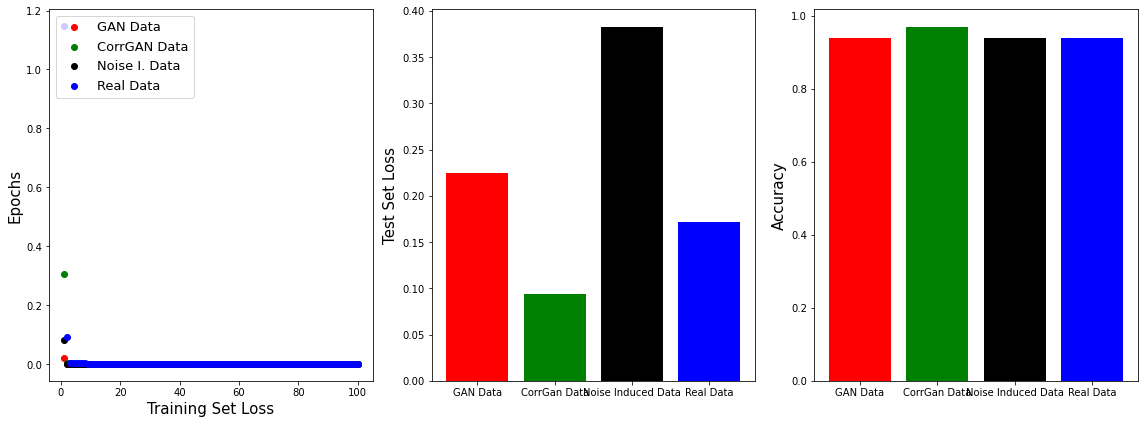

In [134]:
f, (axl, axc, axr) = plt.subplots(1,3,figsize=(16,6))
epochs=100
# Graph depicting deep learning model Loss
axl.scatter(range(1,epochs+1), pd.DataFrame(dl_loss_gen).mean(axis=1), label = 'GAN Data', color='Red')
axl.scatter(range(1,epochs+1), pd.DataFrame(dl_loss_corr).mean(axis=1), label = 'CorrGAN Data', color='Green')
axl.scatter(range(1,epochs+1), pd.DataFrame(dl_loss_noise).mean(axis=1), label = 'Noise I. Data', color='Black')
axl.scatter(range(1,epochs+1), pd.DataFrame(dl_loss_real).mean(axis=1), label = 'Real Data', color='Blue')
axl.legend(loc='upper left', fontsize=13)
axl.set_xlabel('Training Set Loss', fontsize=15)
axl.set_ylabel('Epochs', fontsize=15)

# Graph depicting deep learning model Loss of the test set
axc.bar(['GAN Data', 'CorrGan Data', 'Noise Induced Data', 'Real Data'],
    [np.mean(list(dl_losstest_gen.values())), np.mean(list(dl_losstest_corr.values())), 
     np.mean(list(dl_losstest_noise.values())), np.mean(list(dl_losstest_real.values()))],
            color=['red', 'green', 'black', 'blue'])
axc.set_ylabel('Test Set Loss', fontsize=15)

# Deep Learning model accuracy on predicting the test set class
axr.bar(['GAN Data', 'CorrGan Data', 'Noise Induced Data', 'Real Data'],
    [np.mean(list(dl_results_gen.values())), np.mean(list(dl_results_corr.values())), 
     np.mean(list(dl_results_noise.values())), np.mean(list(dl_results_real.values()))],
            color=['red', 'green', 'black', 'blue'])
axr.set_ylabel('Accuracy', fontsize=15)

plt.tight_layout()
plt.show()

#### Overall Results

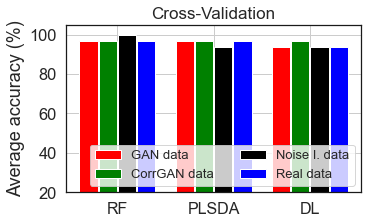

In [135]:
# Results
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.5):
        f, axu = plt.subplots(1, 1, figsize=(5, 3), constrained_layout=True)
        x = np.arange(3)  # the label locations
        labels = ['RF', 'PLSDA', 'DL']
        width = 0.19  # the width of the bars
        
        offset = - 0.3 + 0 * 0.2
        accuracy_stats = pd.DataFrame({'Average accuracy': [np.array(list(RF_results_gen.values())).mean()*100, 
                                                            np.array(list(PLSDA_results_gen.values())).mean()*100,
                                                            np.array(list(dl_results_gen.values())).mean()*100],
                                     'STD': [np.array(list(RF_results_gen.values())).std()*100, 
                                             np.array(list(PLSDA_results_gen.values())).std()*100,
                                             np.array(list(dl_results_gen.values())).std()*100]})
        rects = axu.bar(x + offset, accuracy_stats['Average accuracy'], width, label='GAN data', color='red')
        #axu.errorbar(x + offset, y=accuracy_stats['Average accuracy'], yerr=accuracy_stats['STD'],
        #                ls='none', ecolor='0.2', capsize=3)
        
        offset = - 0.3 + 1 * 0.2
        accuracy_stats = pd.DataFrame({'Average accuracy': [np.array(list(RF_results_corr.values())).mean()*100, 
                                                            np.array(list(PLSDA_results_corr.values())).mean()*100,
                                                            np.array(list(dl_results_corr.values())).mean()*100],
                                     'STD': [np.array(list(RF_results_corr.values())).std()*100, 
                                             np.array(list(PLSDA_results_corr.values())).std()*100,
                                             np.array(list(dl_results_corr.values())).std()*100]})
        rects = axu.bar(x + offset, accuracy_stats['Average accuracy'], width, label='CorrGAN data', color='green')
        #axu.errorbar(x + offset, y=accuracy_stats['Average accuracy'], yerr=accuracy_stats['STD'],
        #                ls='none', ecolor='0.2', capsize=3)
        
        offset = - 0.3 + 2 * 0.2
        accuracy_stats = pd.DataFrame({'Average accuracy': [np.array(list(RF_results_noise.values())).mean()*100, 
                                                            np.array(list(PLSDA_results_noise.values())).mean()*100,
                                                            np.array(list(dl_results_noise.values())).mean()*100],
                                     'STD': [np.array(list(RF_results_noise.values())).std()*100, 
                                             np.array(list(PLSDA_results_noise.values())).std()*100,
                                             np.array(list(dl_results_noise.values())).std()*100]})
        rects = axu.bar(x + offset, accuracy_stats['Average accuracy'],
                        width, label='Noise I. data', color='black')
        #axu.errorbar(x + offset, y=accuracy_stats['Average accuracy'], yerr=accuracy_stats['STD'],
        #                ls='none', ecolor='0.2', capsize=3)
        
        offset = - 0.3 + 3 * 0.2
        accuracy_stats = pd.DataFrame({'Average accuracy': [np.array(list(RF_results_real.values())).mean()*100, 
                                                            np.array(list(PLSDA_results_real.values())).mean()*100,
                                                            np.array(list(dl_results_real.values())).mean()*100],
                                     'STD': [np.array(list(RF_results_real.values())).std()*100, 
                                             np.array(list(PLSDA_results_real.values())).std()*100,
                                             np.array(list(dl_results_real.values())).std()*100]})
        rects = axu.bar(x + offset, accuracy_stats['Average accuracy'], width, label='Real data', color='blue')
        #axu.errorbar(x + offset, y=accuracy_stats['Average accuracy'], yerr=accuracy_stats['STD'],
         #               ls='none', ecolor='0.2', capsize=3)
        
        axu.set_xticks(x)
        axu.set_xticklabels(labels, fontsize=16)
        axu.set(ylabel='Average accuracy (%)', title='', ylim=(20,105))
        for spine in axu.spines.values():
            spine.set_edgecolor('0.1')
        
        axu.legend(loc='lower right', fontsize=13, ncol=2)
        plt.title('Cross-Validation', fontsize=17)
        plt.show()
        f.savefig('images/GDbin_AccuPlot.png' , dpi=300)

sMDiN Analysis

In [136]:
# Chemical Formula transformations (MDBs chosen)
MDBs = ['H2','CH2','CO2','O','CHOH','NCH','O(N-H-)','S','CONH','PO3H','NH3(O-)','SO3','CO', 'C2H2O', 'H2O']

gen_sMDiNs_repo = {}
real_sMDiNs_repo = {}
corr_sMDiNs_repo = {}
test_sMDiNs_repo = {}
noise_sMDiNs_repo = {}

gen_sMDiNs_res = {}
real_sMDiNs_res = {}
corr_sMDiNs_res = {}
test_sMDiNs_res = {}
noise_sMDiNs_res = {}

for i in generated_samples:
    gen_sMDiNs_repo[i] = sMDiN_building(MDiN_vitis, generated_samples[i][0])
    gen_sMDiNs_res[i] = sMDiN_analysis(gen_sMDiNs_repo[i])
    gen_sMDiNs_res[i]['WMDBI'] = WMDBI_calculation(gen_sMDiNs_res[i]['Degree'], generated_samples[i][1], gen_sMDiNs_repo[i])
    
    real_sMDiNs_repo[i] = sMDiN_building(MDiN_vitis, folds_train[i][0])
    real_sMDiNs_res[i] = sMDiN_analysis(real_sMDiNs_repo[i])
    real_sMDiNs_res[i]['WMDBI'] = WMDBI_calculation(real_sMDiNs_res[i]['Degree'], folds_train[i][1], real_sMDiNs_repo[i])
    
    corr_sMDiNs_repo[i] = sMDiN_building(MDiN_vitis, corr_generated_samples[i][0])
    corr_sMDiNs_res[i] = sMDiN_analysis(corr_sMDiNs_repo[i])
    corr_sMDiNs_res[i]['WMDBI'] = WMDBI_calculation(corr_sMDiNs_res[i]['Degree'], corr_generated_samples[i][1], 
                                                    corr_sMDiNs_repo[i])
    
    test_sMDiNs_repo[i] = sMDiN_building(MDiN_vitis, folds_test[i][0])
    test_sMDiNs_res[i] = sMDiN_analysis(test_sMDiNs_repo[i])
    
    noise_sMDiNs_repo[i] = sMDiN_building(MDiN_vitis, noise_generated_samples[i][0])
    noise_sMDiNs_res[i] = sMDiN_analysis(noise_sMDiNs_repo[i])
    noise_sMDiNs_res[i]['WMDBI'] = WMDBI_calculation(noise_sMDiNs_res[i]['Degree'], noise_generated_samples[i][1], 
                                                    noise_sMDiNs_repo[i])
    
    print('Fold', i, 'done.')

Fold 1 done.
Fold 2 done.
Fold 3 done.
Fold 4 done.
Fold 5 done.
Fold 6 done.
Fold 7 done.
Fold 8 done.
Fold 9 done.
Fold 10 done.
Fold 11 done.


In [137]:
sMDiN_results = {}
sMDiN_results['RF'] = {}
sMDiN_results['PLSDA'] = {}

for t, name in zip([gen_sMDiNs_res, real_sMDiNs_res, corr_sMDiNs_res, noise_sMDiNs_res], ['gen', 'real', 'corr', 'noise']):
    
    sMDiN_results['RF'][name] = {}
    sMDiN_results['PLSDA'][name] = {}
    for i in gen_sMDiNs_res:
        if name == 'gen':
            l = generated_samples[i][1]
        elif name == 'real':
            l = folds_train[i][1]
        elif name == 'noise':
            l = noise_generated_samples[i][1]
        else:
            l = corr_generated_samples[i][1]

        test_sMDiNs_res[i]['WMDBI'] = WMDBI_calculation(t[i]['Degree'], l, 
                                                    test_sMDiNs_repo[i], test=test_sMDiNs_res[i]['Degree'])
        sMDiN_results['RF'][name][i] = {}
        sMDiN_results['PLSDA'][name][i] = {}
        for n, metric in t[i].items():
            rf_mod = ma.RF_model(metric, l, return_cv=False, n_trees=200)
            sMDiN_results['RF'][name][i][n] = rf_mod.score(test_sMDiNs_res[i][n], folds_test[i][1])

            # Build y_true
            y_true = []
            for j in folds_test[i][1]:
                if j == 'vinifera':
                    y_true.append(1)
                else:
                    y_true.append(0)
            unique_labels = ['vinifera', 'wild']

            # Test with GAN model
            plsda = fit_PLSDA_model(metric, l, unique_labels, n_comp=4,
                            scale=False, encode2as1vector=True)
            # Obtain results with the test group
            y_pred = plsda.predict(test_sMDiNs_res[i][n])
            # Calculate accuracy
            accuracy = decision_rule(y_pred, y_true)
            sMDiN_results['PLSDA'][name][i][n] = accuracy
    print(name)

gen
real
corr
noise


In [138]:
final_rf_results = {}
final_rf_results['Real'] = pd.DataFrame.from_dict(sMDiN_results['RF']['real']).mean(axis=1)
final_rf_results['GAN'] = pd.DataFrame.from_dict(sMDiN_results['RF']['gen']).mean(axis=1)
final_rf_results['CorrGAN'] = pd.DataFrame.from_dict(sMDiN_results['RF']['corr']).mean(axis=1)
final_rf_results['Noise'] = pd.DataFrame.from_dict(sMDiN_results['RF']['noise']).mean(axis=1)

final_plsda_results = {}
final_plsda_results['Real'] = pd.DataFrame.from_dict(sMDiN_results['PLSDA']['real']).mean(axis=1)
final_plsda_results['GAN'] = pd.DataFrame.from_dict(sMDiN_results['PLSDA']['gen']).mean(axis=1)
final_plsda_results['CorrGAN'] = pd.DataFrame.from_dict(sMDiN_results['PLSDA']['corr']).mean(axis=1)
final_plsda_results['Noise'] = pd.DataFrame.from_dict(sMDiN_results['PLSDA']['noise']).mean(axis=1)

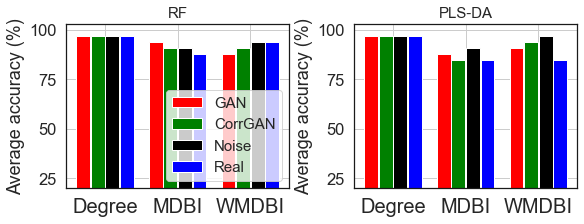

In [139]:
# Results
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.5):
        f, (axl, axr) = plt.subplots(1, 2, figsize=(8, 3), constrained_layout=True)
        x = np.arange(3)  # the label locations
        labels = ['Degree', 'MDBI', 'WMDBI']
        width = 0.19  # the width of the bars
        
        offset = - 0.3 + 0 * 0.2
        rects = axl.bar(x + offset, final_rf_results['GAN'].values*100,
                        width, label='GAN', color='Red')                             
        offset = - 0.3 + 1 * 0.2
        rects = axl.bar(x + offset, final_rf_results['CorrGAN'].values*100,
                        width, label='CorrGAN', color='Green')
        
        offset = - 0.3 + 2 * 0.2
        rects = axl.bar(x + offset, final_rf_results['Noise'].values*100,
                        width, label='Noise', color='Black') 
        
        offset = - 0.3 + 3 * 0.2
        rects = axl.bar(x + offset, final_rf_results['Real'].values*100,
                        width, label='Real', color='Blue') 
        axl.set_title('RF', fontsize=15)
        axl.set_xticks(x)
        axl.set_xticklabels(labels, fontsize=20)
        axl.set(ylabel='Average accuracy (%)', ylim=(20,103))
        for spine in axl.spines.values():
            spine.set_edgecolor('0.1')
        
        axl.legend(loc='lower right', fontsize=15)
        
        offset = - 0.3 + 0 * 0.2
        rects = axr.bar(x + offset, final_plsda_results['GAN'].values*100,
                        width, label='GAN', color='Red')                             
        offset = - 0.3 + 1 * 0.2
        rects = axr.bar(x + offset, final_plsda_results['CorrGAN'].values*100,
                        width, label='CorrGAN', color='Green') 
        
        offset = - 0.3 + 2 * 0.2
        rects = axr.bar(x + offset, final_plsda_results['Noise'].values*100,
                        width, label='Noise', color='Black') 
        
        offset = - 0.3 + 3 * 0.2
        rects = axr.bar(x + offset, final_plsda_results['Real'].values*100,
                        width, label='Real', color='Blue') 
        
        axr.set_title('PLS-DA', fontsize=15)
        axr.set_xticks(x)
        axr.set_xticklabels(labels, fontsize=20)
        axr.set(ylabel='Average accuracy (%)', ylim=(20,103))
        for spine in axr.spines.values():
            spine.set_edgecolor('0.1')
        plt.show()
        f.savefig('images/GDbin_sMDiNAccuPlot.png' , dpi=300)

### Optimizing with different parameters

In [ ]:
test_lrs = {1: 1e-5, 2:5e-5, 3: 1e-4, 4:5e-4, 5: 1e-3, 6:5e-3}

results = {}

for i, lr in test_lrs.items():
    
    gen_loss_all = []
    crit_loss_all = []
    saved_predictions = []
    accuracy = []
    coverage = []
    density = []
    crossLID = []
    corr1stcluster = []
    
    generator_optimizer = tf.keras.optimizers.RMSprop(lr)
    critic_optimizer = tf.keras.optimizers.RMSprop(lr)

    generator = generator_model(data_bin.shape[1], all_data.shape[1], 2, 256)
    critic = critic_model(data_bin.shape[1], 2, 1024)
    #gan = gan_model(generator, critic, generator_optimizer)

    training_montage(data_bin, lbls, 800, generator, critic, generator_optimizer, critic_optimizer,
                     input_realdata_dist, batch_size, grad_pen_weight=10, k_cov_den=20, k_crossLID=15)
    
    results[i]={'gen_loss': gen_loss_all, 'crit_loss': crit_loss_all,
                'saved_pred': saved_predictions,
                'coverage': coverage, 'density': density, 'crossLID': crossLID, 'corr1st_cluster': corr1stcluster}

In [ ]:
tf.debugging.set_log_device_placement(True)
test_lrs = {1: 1e-5, 2:5e-5, 3: 1e-4, 4:5e-4, 5: 1e-3, 6:5e-3}
test_opts = {1: tf.keras.optimizers.RMSprop(1e-3), 2:tf.keras.optimizers.Adadelta(1e-3),
             3: tf.keras.optimizers.Adam(1e-3), 4:tf.keras.optimizers.SGD(1e-3),
             5: tf.keras.optimizers.Ftrl(1e-3)}

results = {}

for i, opt in test_opts.items():
    
    gen_loss_all = []
    crit_loss_all = []
    saved_predictions = []
    accuracy = []
    coverage = []
    density = []
    crossLID = []
    corr1stcluster = []
    
    generator_optimizer = opt
    critic_optimizer = opt

    generator = generator_model(data_bin.shape[1], data_bin.shape[1], 2, 1024)
    critic = critic_model(data_bin.shape[1], 2, 256)
    #gan = gan_model(generator, critic, generator_optimizer)

    training_montage(data_bin, lbls, 1000, generator, critic, generator_optimizer, critic_optimizer,
                     input_realdata_dist, batch_size, grad_pen_weight=10, k_cov_den=20, k_crossLID=15)
    
    results[i]={'gen_loss': gen_loss_all, 'crit_loss': crit_loss_all, 'saved_pred': saved_predictions,
                'coverage': coverage, 'density': density, 'crossLID': crossLID, 'corr1st_cluster': corr1stcluster}

In [ ]:
import itertools
results = {}

n_hidden_nodes = [256, 512, 1024]
for n_hidden_gen, n_hidden_critic in itertools.product(n_hidden_nodes, n_hidden_nodes):
    
    gen_loss_all = []
    crit_loss_all = []
    saved_predictions = []
    accuracy = []
    coverage = []
    density = []
    crossLID = []
    corr1stcluster = []
    
    generator_optimizer = tf.keras.optimizers.RMSprop(5e-3)
    critic_optimizer = tf.keras.optimizers.RMSprop(5e-3)

    generator = generator_model(data_bin.shape[1], data_bin.shape[1], 2, n_hidden_gen)
    critic = critic_model(data_bin.shape[1], 2, n_hidden_critic)
    #gan = gan_model(generator, critic, generator_optimizer)

    training_montage(data_bin, lbls, 1000, generator, critic, generator_optimizer, critic_optimizer,
                     input_realdata_dist, batch_size, grad_pen_weight=10, k_cov_den=20, k_crossLID=15)
    
    results[(n_hidden_gen, n_hidden_critic)]={'gen_loss': gen_loss_all, 'crit_loss': crit_loss_all,
                'saved_pred': saved_predictions,
                'coverage': coverage, 'density': density, 'crossLID': crossLID, 'corr1st_cluster': corr1stcluster}